# **Modeling II**

Author: Wenyi (Tomas) Zhang

In [1]:
import time
import numpy as np
import pandas as pd 
from cta_classic_boosting import Classic_Config, Boosting_Classic, signal_classification, list_augmentation, train_bagged_tree_multi_seed, plot_residual_anomalies_on_close, list_augmentation, corr_analysis
from ic_augment import IC_Augment
from diagnosis import plot_pred_magnitude_diag, pred_magnitude_diag,  plot_true_magnitude_diag, plot_rolling_ic 
from factors_robust import treemodel_factors_augment
from cta_confidence import CTAStrategyEngine
from cta_light_boosting import Light_Config, LGBM_Classic
from cta_cat_boosting import CatBoost_Config, CatBoost_Classic

In the previous section, we constructed and validated a heterogeneous bagging framework. The results indicate that statistically significant trading signals can be observed across multiple configurations, with some settings exhibiting unusually high Sharpe ratios. However, as discussed earlier, relying on machine learning models as standalone trading rules is often fragile in practice, particularly when market structure, liquidity conditions, or trading regimes shift. As such, a more appropriate role for machine learning models is to serve as decision-support tools for traders, rather than fully autonomous trading systems.

Motivated by further research requests from Haitong Futures, this section extends the analysis to boosting, another classical ensemble learning paradigm. Owing to its sequential error-correction mechanism, boosting offers greater expressive power in principle, but is also more susceptible to noise amplification and structural instability, and is highly sensitive to parameter choices, data segmentation, and temporal dependence. Consequently, its application in quantitative trading requires substantially more cautious modeling assumptions and rigorous tuning and validation procedures.

在上一节中，我们构建并验证了异质化 bagging 框架，结果表明在多种参数配置下均能够观测到具有统计意义的交易信号。然而，正如前文所讨论的，将机器学习模型作为唯一交易规则在实际应用中往往较为脆弱，尤其在市场结构、流动性环境或交易制度发生变化时，其稳定性与可持续性面临显著挑战。因此，更为合理的定位是将机器学习模型视为交易员决策过程中的辅助工具，而非完全自治的交易系统。

基于海通期货进一步的研究需求，本节将扩展考察 boosting 这一经典的集成学习范式。由于 boosting 采用序列化、逐步修正误差的建模机制，其在理论上具备更强的函数逼近能力，但同时也更容易放大噪声与结构性变化所带来的不稳定性，对参数设定、样本切分及时间序列结构高度敏感。因此，在量化交易场景下，boosting 的应用需要建立在更加审慎的建模假设与严格的调参与验证策略之上。

**Boosting Algorithm Intuition**

Boosting algorithms are built upon additive models, where a strong predictor is constructed by sequentially combining multiple weak learners with assigned weights. AdaBoost is one of the earliest and most influential implementations of this idea. In the regression setting (AdaBoost.R2), the model can be written as

$$f(x) = \sum_{m=1}^{M} \alpha_m h_m(x)$$  where: $h_m(x)$ is the $m$-th weak learner, $\alpha_m$ is its corresponding weight  

At each iteration, the algorithm focuses increasingly on samples that were poorly predicted in previous rounds, allowing successive learners to correct accumulated bias. The procedure begins by assigning equal weights to all samples. After training the  m-th learner, a normalized relative error is computed for each observation:

$$e_{i,m} = \frac{|y_i - h_m(x_i)|}{\max_j |y_j - h_m(x_j)|}$$

At each iteration, the algorithm focuses increasingly on samples that were poorly predicted in previous rounds, allowing successive learners to correct accumulated bias.

The procedure begins by assigning equal weights to all samples. After training the  m-th learner, a normalized relative error is computed for each observation. The weighted error rate is then given by $$\varepsilon_m = \sum_{i=1}^{N} w_{i,m} \, e_{i,m}$$

Based on this error, the learner’s importance is determined as $$\beta_m = \frac{\varepsilon_m}{1 - \varepsilon_m}, \qquad\alpha_m = \ln \frac{1}{\beta_m}$$

Sample weights are subsequently updated via $$w_{i,m+1} = w_{i,m} \cdot \beta_m^{(1 - e_{i,m})}$$

so that observations with larger prediction errors receive higher emphasis in subsequent rounds. The final prediction is obtained using a weighted median of the individual learners’ outputs, rather than a simple weighted average, which enhances robustness against outliers.

For Ada Boosting, the space of tunable hyperparameters is relatively limited. Beyond the number of weak learners, the definition of the base learner itself, and the learning rate, there are few additional degrees of freedom for fine-grained optimization. As a result, AdaBoost is often employed in anomaly detection or interpretability-oriented settings, where the evolution of sample weights provides an intuitive indication of observations that are repeatedly deemed “hard to explain” during model iteration. That said, AdaBoost is highly sensitive to data size and noise. When the sample size is insufficient or the data quality is unstable, its error-driven reweighting mechanism can easily amplify random noise, leading to degraded performance or even complete model failure.

AdaBoost 的可调超参数空间相对有限。除弱学习器数量、基学习器的具体形式以及学习率之外，能够用于精细化优化的自由度并不多。因此，AdaBoost 更常被应用于异常检测或强调可解释性的场景中，其中样本权重在迭代过程中的演化可以直观反映出哪些观测值在模型训练中被反复判定为“难以解释”。
然而，AdaBoost 对样本规模和噪声水平高度敏感。当样本量不足或数据质量不稳定时，其基于误差的重加权机制容易放大随机噪声，从而导致模型性能明显下降，甚至出现训练失效的情况。

When AdaBoost was first introduced, it was often viewed as a heuristic method that improves weak classifiers by iteratively reweighting training samples. Later theoretical work revealed that this interpretation was incomplete: AdaBoost can be understood as performing stage-wise optimization of an implicitly defined exponential loss in function space. This insight laid the foundation for the gradient boosting framework, which generalizes boosting into a broad class of learning algorithms. In gradient boosting, any regression, classification, or ranking problem that can be expressed with a differentiable loss function—and thus admits computable gradients—can be tackled by sequentially fitting models to the negative gradient of the loss. Common choices include mean squared error (MSE) and mean absolute error (MAE) for regression, as well as cross-entropy for classification. As the ensemble grows, boosting progressively refines predictions on hard-to-fit samples, reshaping the decision boundary to increase the margin between samples and thereby improving predictive confidence.
Nevertheless, gradient boosting is not inherently immune to overfitting. Its performance is primarily governed by two factors: the size of the ensemble and the complexity of individual decision trees. Excessively complex trees tend to capture highly specific rules that apply to only a small subset of observations, leading to poor generalization. Consequently, practical implementations rely on explicit constraints on tree structure, such as minimum sample requirements for node splitting or leaf creation, and minimum impurity or error reduction thresholds (typically MSE in regression). Beyond controlling tree complexity, additional regularization techniques—most notably learning rate shrinkage and randomized strategies inspired by random forests—are commonly employed to enhance robustness and stability in gradient boosting models.



AdaBoost 在最初被提出时，通常被理解为一种通过不断调整样本权重来提升弱分类器性能的算法。然而，后续研究表明，其本质并非启发式的加权策略，而是在函数空间中逐步最小化一种可被反推得到的“指数损失函数（exponential loss）”。正是这一视角的确立，使得提升方法得以系统化，并直接催生了梯度提升（Gradient Boosting）框架。梯度提升将 Boosting 从特定算法推广为一类通用的函数逼近方法：只要回归、分类或排序问题能够用一个可微的损失函数来刻画，从而定义出明确的梯度方向，模型便可以通过逐步拟合负梯度来进行优化。常见的损失函数包括回归中的均方误差（MSE）和绝对误差（MAE），以及分类中的交叉熵损失。随着集成规模的不断扩大，Boosting 在持续修正“困难样本”预测误差的过程中，会逐步调整决策边界并扩大样本间隔（margin），从而提升整体预测置信度。
然而，Boosting 并非天然免疫于过拟合。梯度提升模型性能的两个核心驱动因素始终是集成中弱学习器的数量以及单个决策树的复杂度。若单棵树过于复杂，模型容易学习到仅对极少数样本有效的高度特化规则，进而损害泛化能力。因此，实践中通常通过限制树结构来抑制过拟合，例如设定节点继续分裂或成为叶节点所需的最小样本数，以及要求分裂带来的最小纯度或误差改进（回归中通常基于 MSE）。在此基础上，梯度提升还引入了多种额外的正则化手段，包括学习率收缩（shrinkage），以及借鉴随机森林思想的随机化策略，这些机制共同提升了模型在复杂数据环境下的稳定性。

Note: There also exists a related concept involving the Hessian beyond the exponential loss formulation. However, as it is not central to the scope of this project, we only provide a brief mention here and omit a detailed discussion.

**Diversity of Modeling Techniques**

Consistent with our heterogeneous bagging study, model diversity in this work is not obtained through aggressive hyperparameter tuning on validation data. Instead, diversity is introduced through deliberate choices in factor construction, rollover handling, and loss function specification. On this basis, we further incorporate two distinct boosting frameworks, each equipped with a predefined parameter grid, allowing us to explore structural variation in the learning process while constraining model complexity and limiting overfitting to out-of-sample performance.

与我们在异质化 Bagging 研究中的思路一致，本研究中的模型多样性并非来源于在验证集上进行激进的超参数调优，而是通过因子构建、换月处理及损失函数选择等建模层面的设计加以实现。在此基础上，我们进一步引入了两种不同的 Boosting 框架，并分别设定预定义的参数网格，在探索模型结构差异的同时控制模型复杂度，从而降低对样本外性能过度拟合的风险。

LightGBM:

Over years of development, XGBoost has also adopted histogram-based binning to accelerate training, although its implementation differs from that of LightGBM. As a result, the practical distinction between the two frameworks increasingly centers on tree growth strategy, namely level-wise versus leaf-wise expansion. LightGBM’s leaf-wise growth, combined with gradient-based sampling that focuses on data points with larger gradients, enables the construction of more asymmetric and deeper trees, often achieving faster convergence and stronger fitting capacity. This design is particularly effective when the dataset is large or when underlying patterns are subtle. However, the same imbalance inherent in leaf-wise growth can make the model more prone to overfitting, as it may aggressively capture noise in localized regions if regularization is insufficient.

随着算法的不断演进，XGBoost 也引入了基于直方图（histogram）的分桶机制以提升计算效率，尽管其实现方式与 LightGBM 并不完全相同。因此，在实际应用中，两者的主要差异逐渐集中在决策树的生长策略上，即按层生长（level-wise）与按叶子生长（leaf-wise）的区别。LightGBM 采用的 leaf-wise 生长方式，配合基于梯度大小的样本筛选机制，使模型能够生成结构更不对称、深度更灵活的树，从而在大规模数据或弱信号场景下更快收敛、拟合能力更强。然而，这种不平衡的生长方式也意味着模型更容易在局部区域过度拟合噪声，若缺乏足够的正则化约束，泛化性能可能受到影响。

Cat Boost:

CatBoost is another popular gradient boosting framework that introduces additional structural constraints and training schemes to improve robustness. Its use of symmetric (balanced) trees enforces a single shared split at each depth, which reduces model variance and limits path-specific overfitting. In addition, ordered boosting is designed to mitigate target leakage by ensuring that each sample is predicted using models trained on earlier observations only. These design choices can be beneficial in small or medium-sized tabular datasets, particularly when categorical variables are prominent or when subtle forms of data leakage significantly affect generalization.

However, these same constraints can become limiting in practice. Symmetric trees restrict local adaptivity by preventing different nodes at the same depth from selecting different split rules, which reduces expressive power and can lead to underfitting when signals are heterogeneous or highly localized. Ordered boosting also introduces additional computational overhead and offers limited benefit when time-aware validation schemes, such as rolling windows with embargo, are already in place. As a result, in noisy time-series or continuous-feature settings, CatBoost may incur higher training costs without delivering commensurate gains in out-of-sample performance.

CatBoost 是另一种常用的梯度提升框架，其通过引入额外的结构约束与训练机制来提升模型的稳健性。该方法采用对称树（亦称平衡树）结构，在同一树深度上强制使用统一的分裂规则，从而降低模型方差，并抑制路径层面的过拟合。此外，CatBoost 提出的 ordered boosting 机制通过保证每个样本仅基于“更早”的样本所训练出的模型进行预测，以减少目标泄露所带来的偏差。这些设计在样本规模较小或中等、类别特征占比较高，或对隐性数据泄露较为敏感的表格型数据中，往往能够带来更稳定的泛化表现。

然而，这些约束在实际应用中也可能成为限制因素。对称树结构限制了模型在局部区域内自适应选择分裂规则的能力，不同节点在同一深度无法采用不同的分裂方式，从而削弱了模型的表达能力；当数据中的信号具有明显异质性或高度局部化特征时，模型更容易出现欠拟合。同时，ordered boosting 会引入额外的计算开销，而在已经采用滚动窗口、purge 或 embargo 等时间感知验证策略的场景下，其带来的边际收益往往有限。因此，在以连续特征为主、噪声较大的时间序列任务中，CatBoost 可能需要付出更高的训练成本，却难以获得与之相匹配的样本外性能提升。

Within this structural-design framework—where diversity is introduced through differing modeling assumptions rather than intensive validation-set search—the availability of a sufficiently rich set of modeling tools increases the likelihood that a persistent signal, if present, can be uncovered. Conversely, when no such signal emerges, the outcome is more plausibly attributable to structural strain in the underlying asset or to strong exogenous influences, such as regime-level macroeconomic shocks. In these settings, marginal performance differences across learning algorithms are typically dominated by the asset’s inherent unpredictability rather than by deficiencies in model specification.

在这一以结构性设计为核心、通过不同建模假设而非验证集强搜索来引入多样性的框架下，只要市场中存在可持续的信号，具备足够结构覆盖的建模工具通常能够将其识别出来。若在此基础上仍难以观察到稳定信号，则更可能反映的是标的资产本身存在结构性约束，或受到宏观层面制度性冲击等强外生因素的主导影响。在这类情形下，不同学习算法之间的边际性能差异，往往被资产内在的不可预测性所掩盖，而非源于模型设定层面的不足。

**Delimma of Early Stopping**

In this study, the available sample size is relatively limited (approximately 2,600 observations), and tree-based models are highly sensitive to the order and extent of data exposure. As a result, introducing a separate validation set and merging it back into training can alter the decision rules learned by the model, without necessarily leading to more robust performance. In time-series settings, such practices may further weaken out-of-sample results due to objective misalignment and other confounding factors. For these reasons, we do not construct an additional validation set. Instead, rolling cross-validation with purge and embargo mechanisms is applied within the 90% training portion to preserve temporal relevance and enhance robustness. A subsequent mock trading procedure is then used as an independent out-of-sample evaluation. Under this setup, early stopping is not employed as an explicit training mechanism; rather, its effect is implicitly reflected through joint constraints on the learning rate and the number of weak learners during the third-level hyperparameter tuning, as discussed in the next section.

在本研究中，由于可用样本规模相对有限（约 2600 个数据点），且基于树的模型对数据暴露顺序具有较高敏感性，直接引入独立验证集并将其并入训练过程，往往会改变模型所学习到的决策规则，而不一定能够带来稳健的性能提升。在时间序列场景下，这种做法还可能因目标不一致以及其他复杂因素而削弱样本外表现。基于上述考虑，本文未额外划分独立验证集，而是在 90% 的训练数据内部采用带有 purge 与 embargo 机制的滚动交叉验证方法，以尽可能保持验证过程在时间结构上的相关性，并提升结果的稳健性；随后通过模拟交易（mock trading）作为独立的样本外测试环节。在此设定下，早停（early stopping）并未作为显式的训练机制使用，而是通过在第三级参数调优过程中对学习率与弱学习器数量的联合约束予以隐式体现，相关细节将在下一节中进一步说明。

**A sequential Problem**

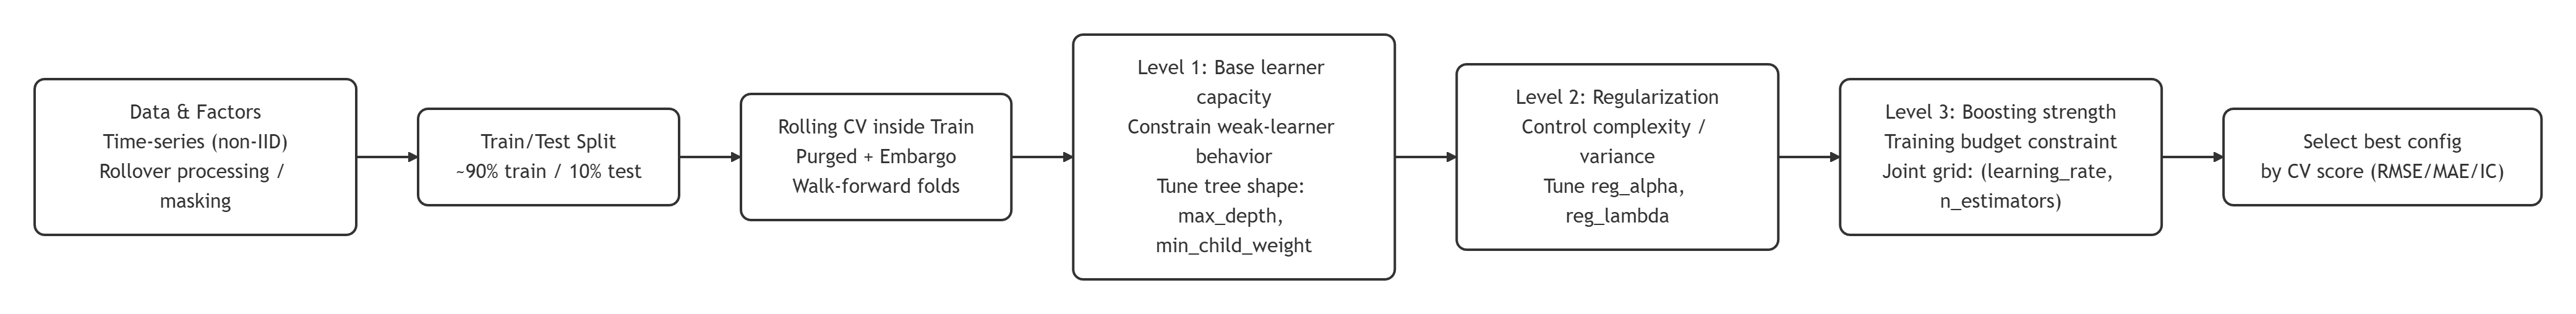

Given the inherent violation of the i.i.d. assumption in time-series data and the potential misalignment between standard predictive objectives and tradability in financial forecasting, aggressively searching over a large hyperparameter space within boosting frameworks entails substantial risk. As the search space and number of trials increase, cross-validation estimates under noisy conditions become increasingly susceptible to selection bias arising from multiple testing, leading to overly optimistic assessments of the best-performing configurations. Moreover, under non-stationarity, the “optimal” hyperparameters are often time-dependent, reflecting incidental adaptation to specific periods rather than stable structural relationships.

To address these issues, we adopt a sequential and hierarchical tuning strategy instead of unconstrained global search. At the first level, the capacity and structure of base learners are explicitly constrained so that each incremental update retains the characteristics of a weak learner, consistent in spirit with the original AdaBoost formulation. The second level introduces explicit regularization to further control model complexity. At the third level, boosting strength is governed through a predefined grid that jointly constrains the learning rate and the number of estimators, pairing smaller learning rates with larger ensembles and compensating larger learning rates with fewer estimators. This design effectively imposes a training budget constraint on the boosting process, yielding a regularization effect analogous to early stopping without relying on explicit stopping criteria.

It is worth noting that degeneration toward flat or near-zero predictions is not necessarily a direct consequence of objective misalignment, but more commonly arises from overly strong regularization, weak or noisy signals, or inappropriate loss functions and shrinkage settings. By deliberately reducing the degrees of freedom in hyperparameter tuning, our approach reflects a conservative research stance that prioritizes robustness and reproducibility over maximal in-sample or period-specific fitting performance in non-stationary financial time-series environments.

鉴于时间序列数据天然违反 i.i.d. 假设，且金融预测问题中常见的优化目标与可交易性之间可能存在偏离，在 Boosting 框架下对全部可用超参数进行大规模搜索往往存在显著风险。一方面，搜索空间越大、试验次数越多，在带噪声的交叉验证估计下越容易引入选择偏差（multiple testing bias），从而对最优参数的性能评估产生系统性乐观偏差；另一方面，在非平稳环境中，“最优”参数往往具有明显的时变特性，更可能反映特定时间区间的偶然适配，而非稳定的结构性规律。

基于上述考虑，本文未采用无约束的全局超参数搜索方法，而是引入了一种顺序化、分层式的参数调优策略。在第一级中，通过约束基学习器的容量与结构，使单轮增量更新保持“弱学习器”特性，从而在形式上与 AdaBoost 中对弱学习器的设定保持一致；第二级进一步引入显式正则化参数，以抑制模型复杂度并降低过拟合风险；在第三级中，则通过预定义的参数网格，对学习率与弱学习器数量进行联合约束，即以较小的学习率对应较大的集成规模，而较大的学习率则由较少的基学习器数量进行补偿。该设计在不依赖显式 early stopping 的前提下，对 Boosting 过程的训练预算形成约束，从而起到类似早停的正则化效果。

需要指出的是，预测结果退化为近似平坦序列并不必然源于目标函数错配，更常见的原因包括正则化或结构约束过强、标签噪声较大或信号极弱，以及不恰当的损失函数选择或过度收缩设置。在本研究中，通过减少超参数自由度并限制模型搜索空间，我们有意采取了一种偏保守的研究立场，其目标在于提升模型在非平稳金融时间序列中的稳健性与可复现性，而非追求在特定样本区间内的极致拟合表现。

#### **Boosting Specific Faliure Mode**

In an initial trial, we observed a distinct failure mode: under the proposed sequential tuning scheme, the model does not collapse into near-flat predictions, yet the rolling IC remains unstable and fails to translate into economically meaningful performance. Subsequent diagnostics suggest that this behavior is not primarily driven by implementation issues, but rather by the interaction between boosting dynamics and non-stationarity.

Although later trees in a boosting model can, in principle, compensate for errors introduced by earlier trees within an additive framework, such compensation implicitly relies on a relatively stable training distribution. When a regime shift occurs—an unavoidable feature of financial time-series forecasting—this distributional consistency is disrupted. As a result, residuals no longer carry the same structural meaning as in the historical regime, and the corrective updates applied by subsequent trees may become misdirected. Instead of refining stable signal components, the model may allocate capacity toward fitting transient or regime-specific noise. This mechanism can lead to persistent instability in rolling IC and weak economic interpretability, even when conventional predictive losses appear controlled.

In contrast, bagging methods reduce variance by averaging across independently trained models, which can make them less sensitive to individual anomalous observations. However, this does not imply inherent robustness to regime shifts: bagging can also fail under non-stationarity, albeit through different failure modes, such as delayed adaptation or signal dilution rather than sequential error propagation.

在初步试验中，我们观察到一种较为典型的失效模式：在顺序化调参框架下，模型并未出现预测“塌缩为近似平坦”的现象，但滚动 IC 依然表现出显著的不稳定性，且难以对应到具有经济意义的交易结果。进一步的诊断表明，这一现象并非主要由工程实现问题引起，而更可能源于 Boosting 机制在非平稳环境下的内在特性。

从理论上看，Boosting 作为加法模型，后续树确实可以在残差层面对早期树的误差进行补偿；但这一补偿机制隐含了一个前提，即训练分布在时间上的相对一致性。当不可避免的 regime shift 发生时，这一前提被破坏，残差的分布及其所代表的结构含义随之发生变化。在此情况下，后续树的“纠错”过程不再针对稳定信号，而更容易演化为对新噪声或短期结构的追逐，从而降低了模型的经济可解释性。最终，即便预测损失在统计意义上得到控制，模型仍可能表现为滚动 IC 持续失稳、交易价值有限。

相较之下，Bagging 方法通过对多个独立模型的结果进行平均，在降低方差和缓解异常样本影响方面通常具有优势。但这并不意味着其在非平稳环境下天然稳健：Bagging 同样可能在 regime shift 下失效，只是其失效形态更多体现为适应滞后或信号被平均稀释，而非 Boosting 中常见的误差逐步传播与放大。

Total runtime: 1.45 minutes


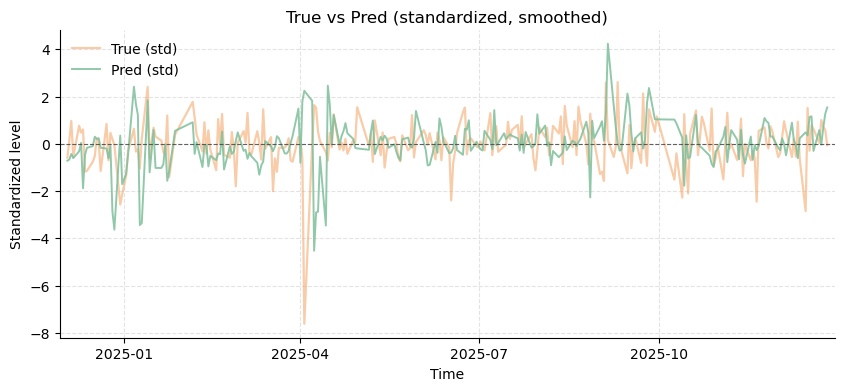

In [2]:
start = time.time()
cfg = Classic_Config()
br  = Boosting_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = False)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

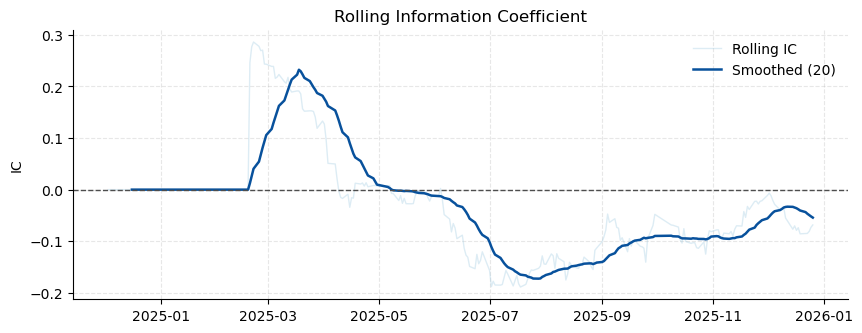

In [3]:
plot_rolling_ic(df['rolling_ic_series'])

In [4]:
df['rolling_ic_summary']

{'roll_ic_mean': -0.03266599046391078,
 'roll_ic_median': -0.03253404531643343,
 'roll_ic_q25': -0.10295371195779414,
 'roll_ic_q75': 0.0,
 'roll_ic_frac_pos': 0.17624521072796934,
 'roll_ic_vol': 0.10520279284493837,
 'roll_ic_mdd': -0.47508938529393996,
 'roll_ic_acf1': 0.981583706056624,
 'roll_ic_half_life': 37.290065438319374}

As summarized earlier, the rolling IC distribution is clearly unfavorable: both the mean and median are negative, the distribution is skewed toward the downside, the upper quartile is at zero, and only about 18% of windows exhibit positive IC, indicating weak and sporadic predictive alignment. Moreover, rolling IC displays high volatility, deep drawdowns, and strong persistence, as reflected by near-unit autocorrelation and a long half-life. Taken together, these characteristics suggest that predictive misalignment is regime-sensitive and sticky once it emerges. This pattern is consistent with a boosting-type failure mode under non-stationarity, where distributional shifts undermine residual-based correction and lead to prolonged periods of limited economic relevance without outright prediction collapse.

正如之前总结的，滚动 IC 的整体分布呈现出明显的不利特征：其均值与中位数均为负，分布向下偏移，上四分位数为零，且仅有约 18% 的时间窗口出现正 IC，表明模型的预测信号零散且缺乏持续性。同时，滚动 IC 具有较高波动率与较深回撤，并表现出接近单位根的自相关与较长的半衰期，说明一旦进入失配状态，往往会在时间上持续存在。综合来看，模型的预测一致性不仅整体偏弱，而且对 regime 变化高度敏感，并在恶化后表现出显著粘性。这一现象与非平稳环境下 Boosting 的典型失效模式相一致：分布漂移削弱了残差修正的有效性，使模型在未发生预测塌缩的情况下，长期处于经济意义有限的状态。

In [5]:
br.get_xgb_gain_importance()

gain
skew_direction_alignment       0.011882
high                           0.011338
flow_direction_persistence_10  0.010754
Slope_HalfDiff_10              0.009454
Residual_Vol_5                 0.009391
price_efficiency_under_volume  0.007662
Downside_Semivar_7             0.007238
mom_efficiency_fast            0.006922
ForceIndex_norm                0.006765
Return_ACF1_5                  0.005875
Vol_Mean_Reversion_5v7         0.005655
regime_switch_alpha24          0.005381
Range_to_RetVol_5              0.004981
mom_efficiency                 0.004954
Open_Pressure_Norm             0.004951
path_flip_rate10               0.004922
ret1                           0.004660
Range_Ratio                    0.004435
LinReg_Slope_5                 0.004394
mom_velocity                   0.004390
volume_shock_over_vol_10       0.004332
ret5                           0.004320
mom_oscillator                 0.004255
DC_Period_Slope_MidCycle       0.004220
Open_Gap                       0.004176
ATR_r_5                        0.004115
mom_convexity                  0.004020
OBV_Slope                      0.004006
Rolling_R2_10                  0.003960
trend_strength_oi              0.003875

The gain-based feature importance does not exhibit a clear thematic concentration. Top-ranked features span heterogeneous categories—including directional alignment, flow persistence, volatility, efficiency measures, regime indicators, and short-horizon returns—without a dominant factor family or consistent economic narrative. This dispersion suggests that the model is relying on a collection of weak, partially correlated signals rather than a coherent structural driver. In the context of boosting, such diffuse importance is consistent with residual-chasing behavior under non-stationarity, where the model incrementally fits local patterns instead of reinforcing a stable predictive theme. This lack of thematic consistency may therefore contribute to the observed instability in rolling IC and the weak economic interpretability of the resulting signals.

从基于 gain 的特征重要性结果来看，模型并未呈现出明显的主题集中性。排名靠前的特征分布在方向一致性、资金流持续性、波动率、效率度量、regime 指标以及短周期收益等多个不同维度，缺乏主导性的因子族或清晰的一致经济叙事。这种分散的特征权重结构表明，模型更可能是在依赖一组相互关联度有限的弱信号组合，而非围绕稳定的结构性驱动进行学习。在 Boosting 框架下，这种特征重要性的离散化特征往往与非平稳环境中的残差追逐行为相一致，即模型逐步拟合局部模式而未能形成可持续的预测主题，这也可能是其滚动 IC 不稳定、经济可解释性较弱的重要原因之一。

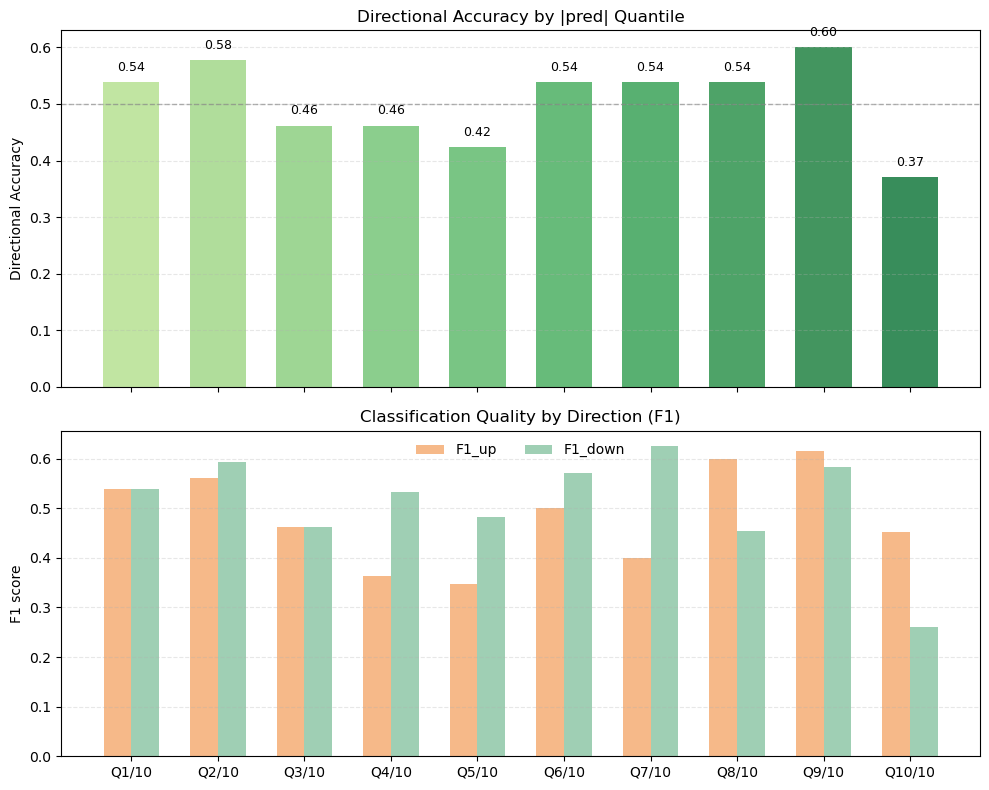

In [6]:
plot_pred_magnitude_diag(df['magnitude_table'])

As a baseline, the model does not exhibit a clear monotonic relationship between prediction magnitude and directional accuracy. While certain mid-to-high quantiles show locally elevated performance, this behavior is inconsistent and breaks down in the highest-confidence bucket, where directional accuracy deteriorates sharply. The lack of calibration between confidence and correctness, together with unstable F1 scores across directions, suggests that the signal is weak and regime-fragile rather than reliably predictive. As such, this baseline does not provide a robust foundation for thresholding or position sizing.

作为基线模型，其预测结果未能呈现出随预测强度单调改善的方向准确率特征。尽管在部分中高分位区间内方向准确率出现局部抬升，但该现象缺乏一致性，并在最高置信区间（Q10）中明显失效。结合多空方向 F1 指标在不同分位间的波动，可以看出模型预测置信度与实际正确性之间缺乏稳定对应关系，表明该信号整体较弱、对 regime 变化敏感，难以作为稳健的交易或仓位决策依据。

**Winzorize**

An attempt of mild winsorization (applied to input features only) was conducted; however, the core predictive deficiencies remain. While winsorization effectively suppresses extreme observations and improves tail-risk characteristics—reducing the rolling IC maximum drawdown from approximately −0.48 to −0.30 and increasing the fraction of positive rolling IC windows to about 39%—the overall mean IC remains negative (around −0.04), indicating persistently weak predictive alignment. Moreover, rolling IC exhibits near-unit first-order autocorrelation and a substantially prolonged half-life, suggesting that once misalignment occurs, it becomes more persistent rather than self-correcting, reflecting reduced adaptivity rather than genuine structural recovery.

Directional accuracy diagnostics further indicate that prediction magnitude is not monotonically associated with performance, with high-confidence bins failing to consistently outperform lower-confidence ones. Although feature importance becomes more economically interpretable—placing greater emphasis on volatility, asymmetry, and path-dependent structure—the learned patterns remain largely descriptive rather than actionable. Overall, mild winsorization improves stability and interpretability but does so at the cost of adaptivity, and it does not resolve the underlying structural misalignment induced by non-stationarity.

It is worth noting that, unless explicitly stated for experimental or diagnostic purposes, winsorization is not adopted as a default preprocessing step in this study. In financial time series, extreme observations are typically not the result of data entry errors but more often reflect genuine market events, regime transitions, or localized liquidity shocks. Aggressively truncating such observations may inadvertently remove economically meaningful signals or anomalous structures, thereby weakening the model’s ability to capture true market behavior.

Accordingly, winsorization is treated as an exploratory tool rather than a standard modeling assumption in this research. Its primary role is to assess model sensitivity to extreme inputs or to stabilize diagnostics under pronounced tail noise. While mild winsorization can, in certain cases, improve numerical stability and reduce tail-driven variance, it may also suppress informative spikes and impair adaptivity under regime shifts. For these reasons, winsorization is restricted to controlled experiments and robustness checks and is not incorporated into the primary modeling pipeline.

在此基础上我们尝试引入轻度 winsorization（仅作用于输入特征），但模型的核心预测问题依然存在。尽管 winsorization 有效抑制了极端样本、改善了尾部风险特征，使滚动 IC 的最大回撤由约 −0.48 收敛至 −0.30，并将滚动 IC 为正的比例提升至约 39%，但整体均值 IC 仍为负（约 −0.04），预测一致性依旧偏弱。同时，滚动 IC 的一阶自相关接近 1，半衰期显著拉长，表明模型在发生失配后表现出更强的时间粘性，反映的是适应性下降而非结构性修复。

方向准确率结果同样显示预测强度与预测质量之间缺乏稳定的单调关系，高置信度区间并未持续展现优势。尽管特征重要性在经济含义上更为集中，主要体现在波动性、非对称性与路径结构等维度，但这些模式更多反映的是市场行为的描述性特征，而非可交易的方向性信号。总体而言，winsorization 在一定程度上提升了模型的稳定性与可解释性，却是以牺牲对 regime 变化的适应能力为代价，未能解决非平稳环境下的结构性失配问题。

值得注意的是，除非在实验性分析或诊断性测试中明确说明，本文不将 winsorization 作为默认的数据预处理步骤。在金融时间序列中，极端观测值通常并非源于数据录入错误，而更可能反映真实的市场事件、regime 转换或局部流动性冲击。对这些观测进行激进截断，可能会误删具有经济意义的信号或异常结构，从而削弱模型对真实市场行为的刻画能力。

因此，winsorization 在本研究中被视为一种探索性工具，而非标准建模假设，其主要用途在于评估模型对极端输入的敏感性，或在强尾部噪声条件下稳定诊断结果。尽管轻度 winsorization 在某些情况下可以提升数值稳定性并降低尾部驱动的方差，但其同时可能抑制具有信息含量的尖峰特征，并削弱模型在 regime 变化下的适应能力。基于上述考虑，winsorization 仅用于受控实验与稳健性检验，而未被纳入主建模流程。

**MAE**

RMSE tends to disproportionately reward observations with large residuals due to its quadratic penalty, which can distort learning in the presence of heavy tails or regime shocks—both common features of financial time series. In contrast, MAE applies a linear penalty to errors and is therefore more robust to outliers, implicitly emphasizing median alignment rather than tail fitting. Under the baseline (unmasked) configuration, this robustness comes at a notable computational cost, with training time increasing to approximately 4.8 minutes.

From a diagnostic perspective, the MAE-based model exhibits a modest improvement in rolling IC behavior. The mean rolling IC becomes slightly positive (~0.006), the fraction of positive IC windows rises to about 42%, and both IC volatility and maximum drawdown are substantially reduced. In addition, the implied half-life shortens markedly, suggesting that periods of misalignment decay faster rather than persisting. Nevertheless, the median rolling IC remains at zero, indicating that overall predictive alignment is still weak.

Directional-accuracy-by-magnitude analysis is consistent with this view. While certain mid-quantiles display elevated accuracy, the relationship between prediction magnitude and performance remains non-monotonic, and high-confidence bins do not consistently dominate. As a result, confidence calibration improves only marginally and remains insufficient for robust thresholding or position sizing.

Feature importance under MAE appears more economically coherent, emphasizing volatility, liquidity, exhaustion, path structure, and short-horizon momentum or reversal effects. This suggests that the model captures meaningful aspects of market microstructure and return dispersion. However, the dispersion of gain across many features and the absence of a dominant factor theme indicate that these patterns remain primarily descriptive rather than decisively predictive.

Overall, replacing RMSE with MAE reduces distortion from extreme residuals and improves stability and interpretability, albeit at higher computational cost. While this change mitigates regime sensitivity and shortens misalignment persistence, it does not fundamentally resolve the lack of strong directional signal or the calibration required for economically actionable trading decisions.

RMSE 由于采用二次惩罚形式，往往会对高残差样本给予不成比例的权重，这在存在厚尾分布或 regime 冲击的金融时间序列中容易造成学习过程的扭曲。相比之下，MAE 对误差施加线性惩罚，在面对异常值时更为稳健，其隐含假设更偏向于刻画收益分布的中位结构而非尾部拟合。在基线（unmasked）设定下，这种稳健性是以更高的计算成本为代价的，整体训练时间上升至约 4.8 分钟。

从预测诊断结果来看，基于 MAE 的模型在滚动 IC 指标上呈现出一定程度的改善。滚动 IC 的均值转为轻微正值（约 0.006），IC 为正的窗口比例提升至约 42%，同时 IC 的波动率与最大回撤显著下降。此外，隐含半衰期明显缩短，表明预测失配状态更容易衰减而非长期滞留。然而，滚动 IC 的中位数仍为零，说明整体预测一致性依旧偏弱。

按预测强度分组的方向准确率分析亦与上述结论一致。尽管部分中等分位区间的表现有所提升，但预测幅度与预测质量之间仍缺乏稳定的单调关系，高置信度区间并未持续占优，因此模型的置信度校准能力仅有边际改善，尚不足以支持稳健的阈值或仓位决策。

在特征重要性层面，MAE 所对应的结果在经济含义上更为集中，主要体现在波动性、流动性、耗竭效应、路径结构以及短周期动量或反转特征上，反映出模型对市场微观结构和收益分布特征的刻画更为一致。然而，gain 在多种特征间分散、缺乏主导性因子主题，说明这些模式仍以描述性为主，而非形成稳定的方向预测能力。

总体而言，将损失函数从 RMSE 切换至 MAE 在一定程度上缓解了极端残差带来的扭曲，提升了模型的稳定性与可解释性，但也带来了更高的计算开销。尽管该调整降低了对 regime 冲击的敏感性并缩短了失配的持续时间，但并未从根本上解决方向性信号偏弱及预测置信度不足的问题，因而仍难以直接转化为具有经济意义的交易决策。

**LGBM**

Highly consistent behavior is also observed under LightGBM. Rather than revealing a new or stronger predictive structure. Compared with the more symmetric and conservative growth strategy of XGBoost, LightGBM employs leaf-wise tree growth and more aggressive splitting, which in principle should be better suited to mining localized, weak patterns in noisy environments. Nevertheless, even under this more “aggressive” modeling assumption, the model fails to produce stable or well-calibrated directional signals.

Under the baseline configuration, directional accuracy stratified by prediction magnitude again shows no clear monotonic relationship. While certain mid-quantiles exhibit localized improvements, high-confidence bins do not consistently dominate, indicating that prediction magnitude does not reliably map to predictive quality. As a result, the model output remains unsuitable for threshold-based or scaled trading decisions.

Rolling IC statistics further substantiate this conclusion. Under the RMSE objective, both the mean and median rolling IC are negative, volatility is high, and maximum drawdown is severe—worse than that observed under XG boosting—accompanied by near-unit autocorrelation and a long half-life. This reflects strong regime sensitivity and persistent misalignment once the model deviates.

Switching the loss function to MAE leads to a noticeable change in behavior. The mean and median rolling IC turn positive, the fraction of positive IC windows rises above 60%, and both IC volatility and drawdown decline substantially, with a markedly shorter half-life. These improvements indicate enhanced stability.

Despite these changes, the core conclusion remains unchanged. The model predominantly captures structural and descriptive characteristics of market behavior rather than strong, robust, and economically actionable directional signals. Overall, the LightGBM results do not revise earlier findings but instead reinforce them: under regime shifts, unmasked factor construction, and the assumptions inherent to boosting, any underlying signal—if present at all—is intrinsically constrained and unlikely to be “forced out” through more complex or more aggressive boosting architectures.

在 LightGBM 上同样可以观察到与前述模型高度一致的现象。这一结果并未指向新的或更强的预测结构。相较于 XGBoost 更为对称、保守的树生长方式，LightGBM 采用 leaf-wise 生长与更激进的划分策略，理论上更有能力在高噪声环境中挖掘局部、微弱的模式；然而，即便在这种更具“进攻性”的建模假设下，模型依然未能形成稳定、可校准的方向性信号。

在基线设定下，按预测强度分组的方向准确率依旧未呈现清晰的单调关系。尽管部分中等分位区间存在局部表现，但高置信度区间并未持续占优，表明预测强度无法可靠映射为预测质量，模型输出难以直接用于基于阈值或仓位放大的交易决策。

滚动 IC 统计结果进一步印证了这一判断。在 RMSE 损失下，滚动 IC 的均值与中位数均为负，波动率较高、最大回撤显著（劣于 XG Boosting），同时伴随接近单位根的自相关与较长的半衰期，反映出模型在 regime 变化下的高度敏感性与失配粘性。

当损失函数切换为 MAE 后，模型行为确实发生了显著变化：滚动 IC 的均值与中位数转为正值，IC 为正的窗口比例提升至 60% 以上，IC 波动率与最大回撤明显下降，半衰期显著缩短，说明模型稳定性有所改善。

尽管如此，核心结论并未改变：模型所捕捉到的主要仍是结构性与描述性的市场特征，而非强、稳健且可直接交易的方向性信号。总体而言，LightGBM 的结果并非对前述结论的修正，而是对其的进一步确认——在 regime shift、unmasked 因子计算以及 Boosting 机制本身假设 共同作用下，信号若存在，其强度本身即受到限制，难以通过更复杂或更激进的 Boosting 结构被“强行挖掘”出来。

**Disclaimer in Baseline Trail**

In the previous grid search, one may notice the absence of parameters such as gamma and feature subsampling ratios, which are often used as additional regularization mechanisms. These choices were made deliberately and, where appropriate, implemented through alternative means for the following reasons.

First, gain-based split constraints (e.g., gamma) are highly data-dependent. In weak and noisy time-series settings, imposing a fixed minimum gain threshold can prematurely halt tree growth, effectively collapsing the model into near-flat predictions. Such behavior is particularly undesirable when the underlying signal is subtle and unevenly distributed across time.

Second, feature subsampling differs fundamentally from bagging in this context. Although feature subsampling introduces randomness, all features are still exposed to the model across boosting iterations, making the process largely seed-driven. This randomness can increase the risk of over-tuning to specific sample paths while reducing the model’s ability to adapt under regime changes.

Given these considerations, randomness is instead introduced in a controlled manner via random_mode, and robustness is enhanced by training a bag of boosted models across different random seeds. When individual boosted models exhibit reasonable behavior, aggregating them through bagging provides a more stable and reproducible alternative than aggressively regularizing or selecting a single “best” configuration.

在前述的网格搜索中，可以注意到我们并未显式引入诸如 gamma 或特征子采样比例等常见的正则化参数。这一设计并非疏漏，而是经过权衡后有意为之，并在其他层面加以替代，其主要原因如下。

首先，基于 gain 的分裂约束（如 gamma）具有较强的数据依赖性。在弱信号、强噪声的时间序列环境中，固定的最小增益阈值往往会过早地截断树的生长过程，导致模型退化为近似平坦的预测形式。这种现象在信号本身细微且时变的场景下尤为具有破坏性。

其次，特征子采样在此类问题中与 Bagging 的作用机制并不等价。尽管特征子采样引入了一定随机性，但在 Boosting 框架下，所有特征仍会在不同轮次中暴露给模型，其随机性主要由随机种子驱动。这种随机扰动更容易诱发对特定样本路径的过拟合，同时削弱模型在 regime 变化下的后续适应能力。

基于上述考虑，我们选择将随机性以更可控的方式引入 random_mode，并通过对多个 Boosting 模型进行 Bagging 来提升整体稳健性。在单模型行为合理的前提下，这种“Boosting 的 Bagging”策略相比激进的正则化或单一最优模型选择，更有利于缓解不稳定性并提高结果的可复现性。

#### **Masked Session**

In notebook feature engineering, we noted that rollover boundaries may contain structural abnormalities and therefore introduced two alternative processing schemes: masking, where observations are set to NaN during factor computation but allowed to be forward-filled afterward, and discarding, where predictions around rollover points are excluded and the model focuses on the remaining samples.

Under bagging, these configurations do not lead to material differences in performance, as error decorrelation across independently trained models tends to dilute the impact of localized rollover effects. In contrast, under boosting, such design choices can meaningfully influence model behavior. Because boosting is a sequential, residual-driven procedure, the treatment of rollover-related observations may shift the model’s focus away from mechanisms explicitly associated with rollover dynamics, thereby altering how residuals are interpreted and corrected in subsequent iterations.

在 特征工程 notebook 中我们指出，合约 rollover 边界附近可能包含结构性异常，因此引入了两种处理方式：mask，即在因子计算阶段将相关观测设为 NaN，但允许后续前向填充；以及 discard，即在预测阶段直接跳过 rollover 附近的样本，仅对其余区间进行建模与评估。

在 Bagging 框架下，由于多模型之间的误差去相关机制，这两种配置对整体结果影响并不显著，局部的 rollover 异常往往被平均化处理。然而，在 Boosting 框架中，上述处理方式可能对模型学习路径产生实质影响。由于 Boosting 依赖残差的顺序修正，rollover 相关样本的处理方式会改变残差的结构，从而可能使模型的注意力偏离 rollover 行为本身所暴露的机制，进而影响后续弱学习器的纠错方向。

Total runtime: 4.85 minutes


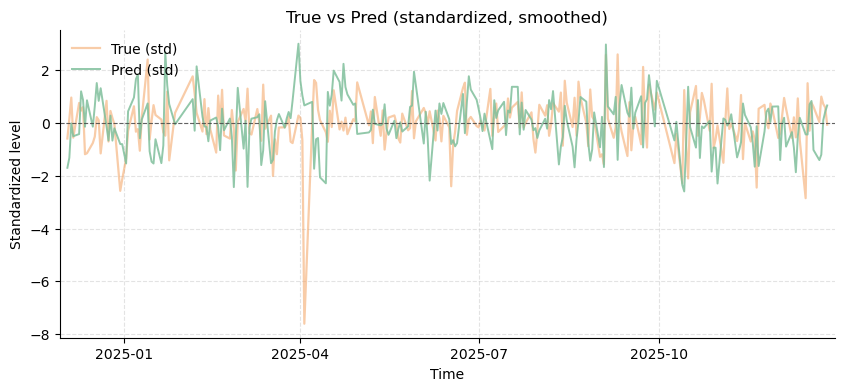

In [7]:
start = time.time()
cfg = Classic_Config()
br  = Boosting_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

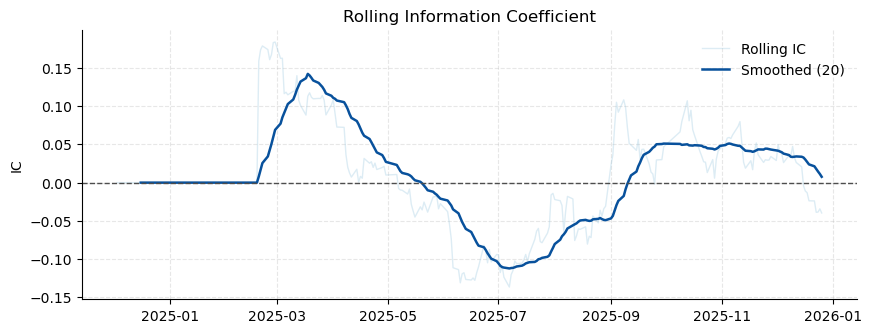

In [8]:
plot_rolling_ic(df['rolling_ic_series'])

In [9]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.007302601506819565,
 'roll_ic_median': 0.0,
 'roll_ic_q25': -0.03178186406084718,
 'roll_ic_q75': 0.0420995589372547,
 'roll_ic_frac_pos': 0.45977011494252873,
 'roll_ic_vol': 0.0690540621738626,
 'roll_ic_mdd': -0.32041122738636474,
 'roll_ic_acf1': 0.9698662984599767,
 'roll_ic_half_life': 22.654049931480223}


Comparing the masked and unmasked configurations reveals a clear trade-off between stability and apparent signal strength. Under the masked treatment, rolling IC statistics improve noticeably: the mean IC turns slightly positive (≈0.007 vs −0.033), the proportion of positive IC windows increases substantially (≈46% vs 18%), both volatility and maximum drawdown are reduced, and the IC half-life shortens. Together, these changes indicate enhanced stability and faster recovery following periods of misalignment, which is consistent with a reduced influence of rollover-related distortions.

对比 mask 与 unmasked 两种配置，可以清晰地看到稳定性与表观信号强度之间的权衡。在 mask 设定下，滚动 IC 表现出现明显改善：IC 均值由负转为略正（≈0.007 vs −0.033），IC 为正的窗口比例显著提升（约 46% vs 18%），同时波动率与最大回撤下降，IC 半衰期缩短。综合来看，这些变化表明模型稳定性增强、失配后的恢复速度加快，其表现与 rollover 相关扰动影响被削弱的情形是一致的。

In [10]:
br.get_xgb_gain_importance()

gain
Slope_HalfDiff_10              0.001723
ret1                           0.001285
IV_Parkinson_7                 0.000996
mom_velocity                   0.000955
pv_divergence                  0.000786
Downside_Semivar_7             0.000760
path_flip_rate10               0.000739
Range_Ratio                    0.000739
mom_efficiency                 0.000641
Price_Phase_Same_Direction     0.000623
oi_direction_persistence       0.000596
flow_direction_persistence_10  0.000595
skew_regime_shift              0.000581
exhaustion_alpha9              0.000574
low                            0.000573
trend_age_norm                 0.000569
Month_Cos                      0.000546
trend_age                      0.000525
skew_direction_alignment       0.000522
returns_skew_5bar              0.000512
VWAP_Dist_over_RV10            0.000511
high                           0.000497
High_Extreme_Flag              0.000493
Lower_Shadow_Frac              0.000472
regime_switch_alpha24          0.000458
HT_TREND_MODE                  0.000453
Vol_Composite_5_7              0.000446
Vol_Term_Structure_5_7         0.000436
volume_shock_over_vol_10       0.000433
ret7                           0.000431

This effect is also reflected in the feature importance profile. Under the masked configuration, gain values become markedly smaller and more evenly distributed across features, with no single factor dominating the split decisions. The model places relatively balanced weight on short-horizon price dynamics, volatility asymmetry, downside risk, and regime-related descriptors, indicating that learning is no longer driven by a small subset of rollover-sensitive variables.

Importantly, this diffusion of split importance should not be interpreted as a deficiency. Rather, it reflects a shift toward a more conservative and evenly regularized representation, in which no single mechanism is allowed to disproportionately influence the learning process. While this inevitably attenuates sharp, localized effects—some of which may be linked to rollover behavior—it also reduces the risk of over-reliance on structurally unstable patterns. In this sense, masking trades concentrated but fragile signal exposure for a more uniformly distributed, and potentially more robust, feature usage.

这一变化同样体现在特征重要性结构中。在 mask 设定下，各特征的 gain 数值整体显著降低，且分布更加均匀，不再由少数特征主导分裂决策。模型的注意力较为平均地分配在短期价格变化、波动不对称性、下行风险以及 regime 描述性因子上，表明学习过程不再依赖对 rollover 敏感的局部机制。

需要强调的是，这种分裂权重的“均匀化”并不应被视为模型能力下降。相反，它反映了一种更为保守、正则化程度更高的建模状态：模型避免让单一机制在训练过程中占据过高权重。尽管这会削弱部分尖锐、局部的效应（其中一些可能与 rollover 行为相关），但同时也降低了对结构性不稳定模式的依赖风险。从这个角度看，mask 本质上是在以牺牲集中度为代价，换取更均衡、更稳健的特征使用结构。

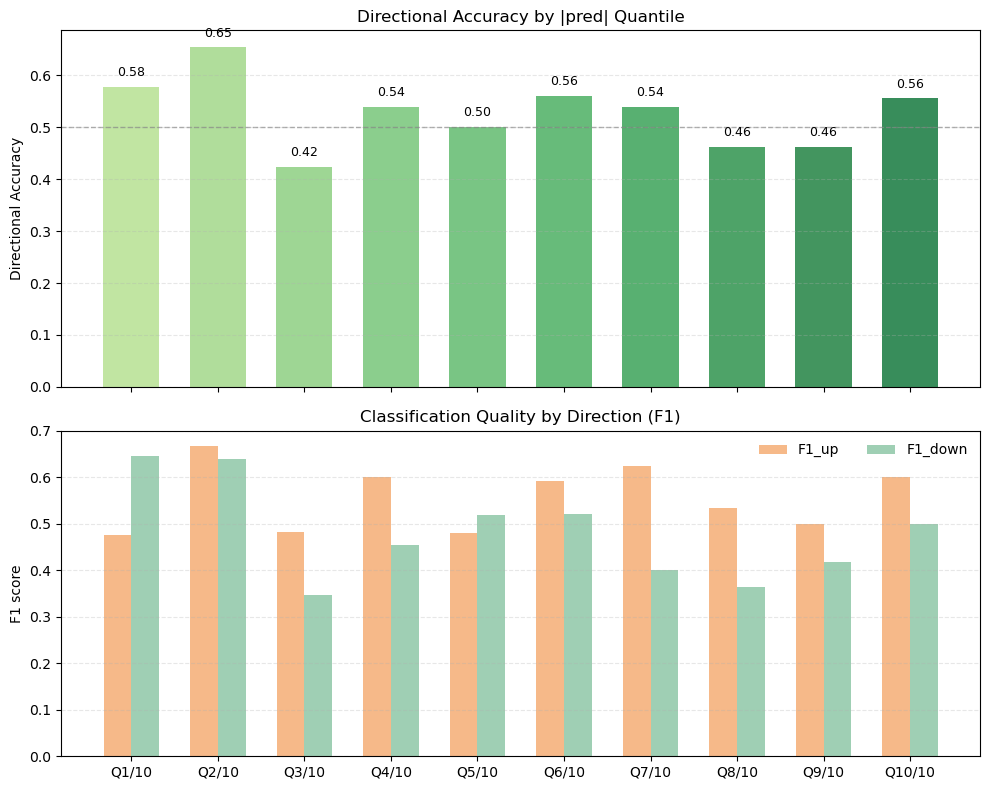

In [11]:
plot_pred_magnitude_diag(df['magnitude_table'])

The prediction-magnitude diagnostics highlight a clear difference between the masked and unmasked configurations. Under the masked setup, directional accuracy is relatively compressed across quantiles: mid-range bins perform reasonably, but high-confidence bins do not consistently dominate. This indicates a more conservative and evenly calibrated model, where predictive power is distributed rather than concentrated. Correspondingly, F1 scores remain balanced across directions but do not exhibit strong peaks, suggesting stability without strong conviction.

In contrast, the unmasked configuration shows more polarized behavior. Certain high-confidence bins achieve stronger directional accuracy, while others—especially at the extremes—degrade sharply. This reflects sharper but less reliable confidence formation, consistent with stronger exposure to rollover-related distortions. Overall, masking improves stability and calibration at the expense of suppressing extreme, and potentially fragile, signals.

预测强度分位诊断显示，mask 与 unmasked 配置在模型行为上存在明显差异。在 mask 设定下，各分位的方向准确率较为收敛，中等分位表现尚可，但高置信度区间并未持续占优，说明模型整体更为保守，预测能力分布更均匀。对应的多空 F1 值较为平衡，但缺乏明显峰值，体现出稳定但低确信度的特征。

相比之下，unmasked 配置呈现出更强的极化特征：部分高置信度分位表现突出，而极端区间则明显失效。这表明 unmasked 处理允许更强的局部确信度形成，但代价是预测校准不稳，更容易受到 rollover 相关结构的干扰。总体而言，mask 提升了稳定性与校准性，但抑制了尖锐且可能脆弱的信号。

**MAE**

Relative to RMSE, MAE induces milder parameter updates and exhibits greater robustness. By applying a linear penalty to errors, MAE reduces the influence of extreme residuals on the learning process, resulting in smoother and more stable training dynamics. However, when rollover-related structures are removed or attenuated through masking or forward-fill treatments, this robustness can become a constraint. Under such conditions, the remaining predictable signals tend to be weaker and more diffuse, rather than concentrated in large-residual regions. As a result, MAE may fail to generate gradients of sufficient magnitude to drive effective learning, leading to inferior predictive performance. The absence of a uniformly dominant parameter configuration across different data treatments indicates that MAE’s optimal bias–variance trade-off is highly context-dependent rather than universally optimal.

与 RMSE 相比，MAE 的更新方式更为温和，但也更具稳健性。由于 MAE 对误差采用线性惩罚，其对极端残差的敏感度较低，从而减弱了异常值对模型学习过程的影响，使训练过程更加平滑。然而，当与 rollover 相关的结构被移除，或因 mask / forward-fill 处理而被削弱时，这种稳健性反而可能成为限制因素。在此情况下，数据中剩余的可预测信号通常更弱且更加分散，不再集中于大残差区域，导致 MAE 难以提供足够强的梯度来驱动有效学习，进而表现出相对较弱的预测能力。不同处理设定下并不存在统一占优的参数组合，这表明 MAE 的最优偏差–方差权衡具有显著的情境依赖性，而非通用解。

**LGBM**

The early hypothesis can be supported to some degree by the LightGBM configuration, which applies a more aggressive tree growth strategy. By adopting leaf-wise expansion and allowing deeper, localized splits, LightGBM is structurally better suited to probe weak and fragmented patterns that may not be accessible under more conservative, symmetric tree growth schemes. The results shown below are therefore consistent with the idea that, if predictive structure exists, it is unlikely to be strong or globally uniform, but instead requires more expressive and adaptive modeling assumptions to be revealed.

早期提出的假设在一定程度上得到了 LightGBM 配置的支持。由于 LightGBM 采用更为激进的树生长方式（leaf-wise growth），允许在局部区域进行更深层次的划分，其结构上更有能力挖掘弱且分散的模式，这些模式在更为保守、对称的树生长假设下往往难以显现。因此，下文结果与这样一种判断是一致的：若预测结构确实存在，其形式更可能是细微且局部化的，而非强且全局一致的信号。

Total runtime: 2.06 minutes


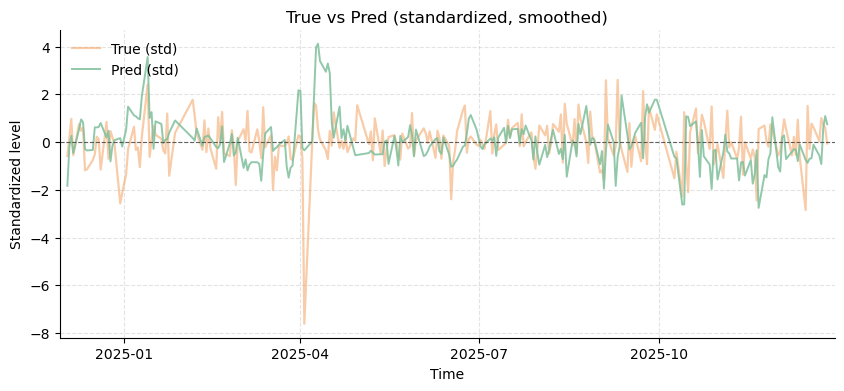

In [12]:
start = time.time()
cfg = Light_Config()
br  = LGBM_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

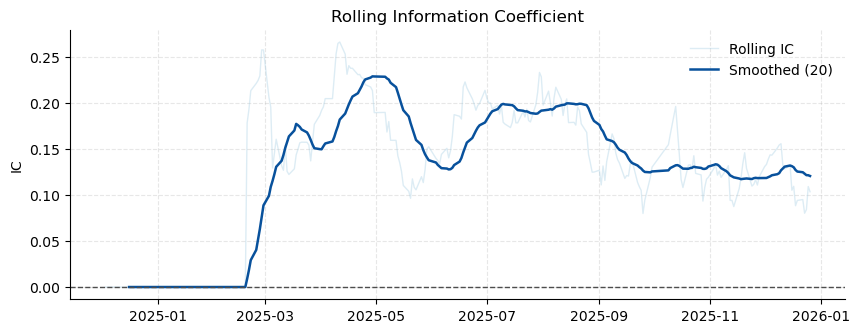

In [13]:
plot_rolling_ic(df['rolling_ic_series'])

In [14]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.12983275706071304,
 'roll_ic_median': 0.135951070342382,
 'roll_ic_q25': 0.10544642823606097,
 'roll_ic_q75': 0.18699927272024205,
 'roll_ic_frac_pos': 0.8122605363984674,
 'roll_ic_vol': 0.07371451419865764,
 'roll_ic_mdd': -0.1859858285366735,
 'roll_ic_acf1': 0.9718979433049539,
 'roll_ic_half_life': 24.31713409294798}

Turning to the rolling IC behavior, once rollover-related distortions are removed through masking, LightGBM exhibits a markedly stronger and more persistent positive IC profile. The rolling IC remains decisively above zero for extended periods, with a high fraction of positive windows and relatively controlled drawdowns, indicating that the extracted signal is not purely episodic. This suggests that technical-analysis-style signals do exist in the data, but their manifestation is conditional: they are easily obscured by microstructural noise and only become visible when both distortion handling and sufficiently aggressive local mining are applied. Importantly, this does not contradict earlier findings; rather, it clarifies that signal presence is fragile and configuration-dependent, rather than universally exploitable.

进一步观察滚动 IC 的表现可以发现，在通过 mask 处理移除 rollover 相关扰动后，LightGBM 的滚动 IC 呈现出显著更强且更具持续性的正向特征。IC 在较长时间区间内稳定为正，正向窗口比例较高，且回撤相对可控，说明该信号并非偶发性噪声。这表明技术分析类信号确实存在，但其可见性具有明显条件性：在微观结构噪声未被处理或模型表达能力不足的情况下，这类信号容易被掩盖；只有在扰动被削弱、并结合更具进攻性的局部挖掘方式时，信号才会显现出来。这一结果并非推翻前述结论，而是进一步强调信号的脆弱性与配置依赖性。

In [15]:
br.get_xgb_gain_importance()

gain
volume                    0.284625
pv_divergence             0.280549
IV_Parkinson_7            0.243541
TRIX_like                 0.241462
ret7                      0.187008
volume_shock_over_vol_10  0.123711
oi_direction_persistence  0.122523
LinReg_Residual_Z_10      0.121031
open                      0.098041
Open_Gap                  0.090204
Lower_Shadow_Frac         0.087286
Slope_ACF1_10             0.079509
Residual_Vol_5            0.075586
mr_inst_z_S               0.068960
Body_Ratio                0.068593
Open_Pressure_Norm        0.066678
skew_regime_shift         0.066450
ATR_r_5                   0.064512
skew_convexity_5_7        0.061082
Realized_Quarticity_5     0.058879
skew5_acceleration        0.057334
Range_CV_5                0.053743
volume_entropy_10         0.052193
Ret_Var_Corr_7            0.052152
Rolling_R2_5              0.051421
OBV_Slope                 0.048593
returns_skew_5bar         0.047036
LongCycle_Phase_Velocity  0.047030
LinReg_Residual_Z_5       0.046840
trend_age_norm            0.046077

Feature importance profile is materially different from earlier cases and suggests a more coherent underlying structure. The dominant contributors are no longer scattered across weak, loosely related indicators, but instead cluster around volume dynamics, volatility measures, price–volume divergence, and medium-horizon return structure. In particular, the prominence of volume, price–volume divergence, Parkinson volatility, and volatility-of-volatility terms points to a regime where liquidity conditions and volatility state, rather than short-term directional momentum, are driving predictability.

Importantly, this pattern is consistent with a market-state or microstructure-driven signal rather than a pure directional forecasting signal. The model appears to be learning when price movements are informative—conditional on volume, volatility, and path geometry—rather than directly predicting price direction itself.

特征重要性结果与此前明显不同，显示出更为一致且具有经济含义的结构。重要性不再分散于零散、弱相关的指标之中，而是明显集中在成交量动态、波动率刻画、价量背离以及中期收益结构等维度上。尤其是成交量、价量背离、Parkinson 波动率、波动率的波动等特征占据主导，表明可预测性更多来源于流动性与波动状态，而非短期方向性动量。需要强调的是，这更像是一种“市场状态 / 微观结构驱动”的信号，而非直接的方向预测信号。模型学习的重点并不是简单判断涨跌方向，而是在特定的成交量、波动率与路径结构条件下，识别哪些价格变动具有信息含量。

In [16]:
df['lag_ic']

{-10: 0.00883096186681844,
 -9: -0.11838960739012706,
 -8: -0.07205546935091613,
 -7: 0.03904786837706667,
 -6: -0.042430668133395084,
 -5: 0.0758990901808194,
 -4: 0.026641395575061077,
 -3: -0.0466733910766125,
 -2: 0.050550831946180784,
 -1: 0.10701705874119666,
 0: 0.13459479890119533,
 1: 0.06344267723578068,
 2: -0.014798212472631076,
 3: -0.013072770017842862,
 4: 0.026130977965794947,
 5: -0.007638332570382236,
 6: 0.06251519800833719,
 7: 0.0032927702219040797,
 8: -0.10488609872382554,
 9: 0.011623747809439826,
 10: 0.0053530639347372415}

The lag IC profile shows a clear peak at lag 0, followed by a rapid and symmetric decay across positive and negative lags. This indicates that the predictive signal is primarily contemporaneous, with limited lead–lag structure and no obvious evidence of information leakage.

Residual diagnostics are generally well behaved. Autocorrelations of both residuals and squared residuals remain small across tested lags, and Ljung–Box p-values are comfortably above conventional significance levels, suggesting no strong remaining serial dependence. Overall, the residual structure is consistent with an approximately white-noise process.

滞后 IC 在 0 阶附近达到峰值，并在正负滞后方向上快速、近似对称地衰减，说明模型所捕捉的信号主要是当期相关的，未表现出明显的前瞻性结构，也未发现显著的信息泄露迹象。残差诊断整体表现良好。残差及其平方的自相关在各阶滞后下均较小，Ljung–Box 检验的 p 值明显高于常用显著性水平，表明残差中不存在显著的序列相关性。整体来看，残差结构接近白噪声假设。

In [17]:
df['residuals']['summary']['ljungbox_p']

{1: 0.964312526080962,
 5: 0.9144516398418234,
 10: 0.7696985303912272,
 20: 0.2872668654440428}

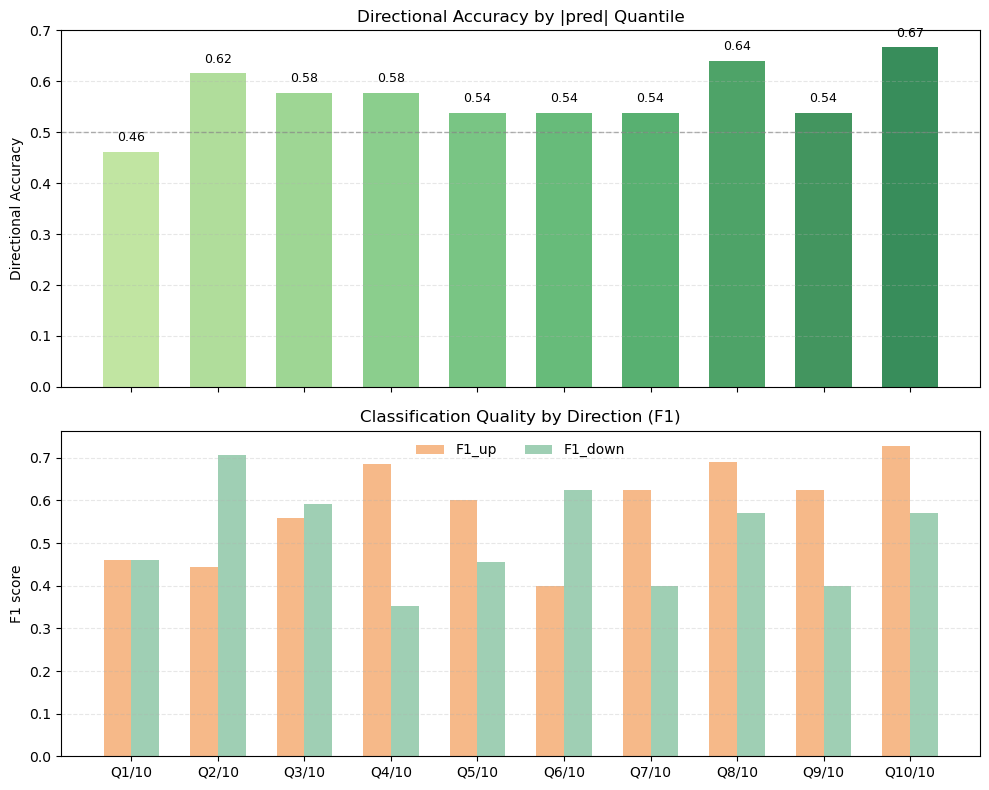

In [18]:
plot_pred_magnitude_diag(df['magnitude_table'])

At the signal level, both prediction-magnitude and realized-return conditioning show improved directional consistency, and a simple sign-based ensemble already delivers materially better performance than buy-and-hold. This supports the earlier hypothesis that, once rollover-induced distortions are controlled, technical signals are present in a subtle form and benefit from more aggressive, leaf-wise partitioning rather than conservative symmetric splits.

That said, it is important to emphasize that the backtesting framework here is intentionally naive and diagnostic in nature. Position sizing, transaction cost modeling, execution constraints, and regime-aware risk controls are deliberately simplified. These results should therefore be interpreted as evidence of signal existence and structure, not as a production-ready strategy. (see Notebook: Modeling I).

从信号层面看，无论是按预测强度还是按真实收益幅度分组，方向一致性均有所改善；即便是简单的符号型集成，也已经显著优于买入并持有。这进一步支持了前述判断：在剔除 rollover 相关扭曲后，技术信号确实存在，但其形式细微，更依赖于激进、leaf-wise 的划分方式，而非保守的对称生长。

需要特别说明的是，这里的回测框架是刻意简化、偏诊断性的。仓位管理、交易成本、执行约束以及 regime 感知的风险控制均未充分建模。因此，这些结果更多用于说明信号的存在性与结构特征，而非可直接落地的交易策略（见 Notebook：Modeling I）。

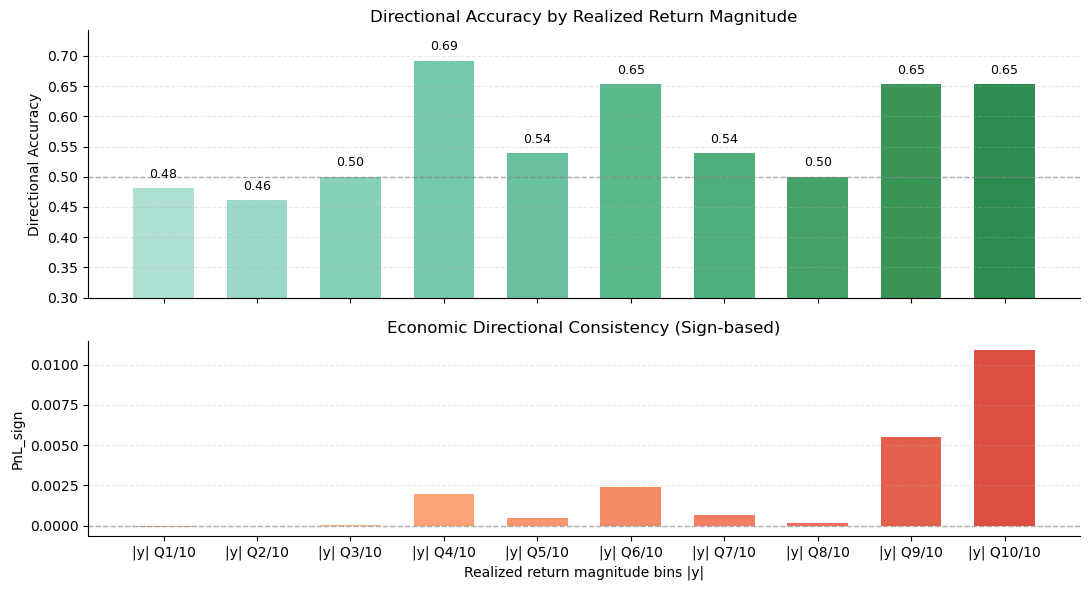

In [19]:
plot_true_magnitude_diag(df['true_mag_table'])

Sign of Ensemble only
=== Backtest summary ===
Sample size        : 260 obs
Directional Acc.   : 0.569
IC (Spearman)      : 0.151
IC (Pearson)       : 0.152
Trade days         : 80
Total turnover     : 159.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 54.54%
  Ann. vol         : 21.78%
  Sharpe           : 2.50
  Sortino          : 4.28
  Max drawdown     : -13.91%

Strategy (net after fees):
  Ann. return      : 46.84%
  Ann. vol         : 21.82%
  Sharpe           : 2.15
  Sortino          : 3.69
  Max drawdown     : -14.52%

Buy & Hold:
  Ann. return      : 24.21%
  Ann. vol         : 22.00%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


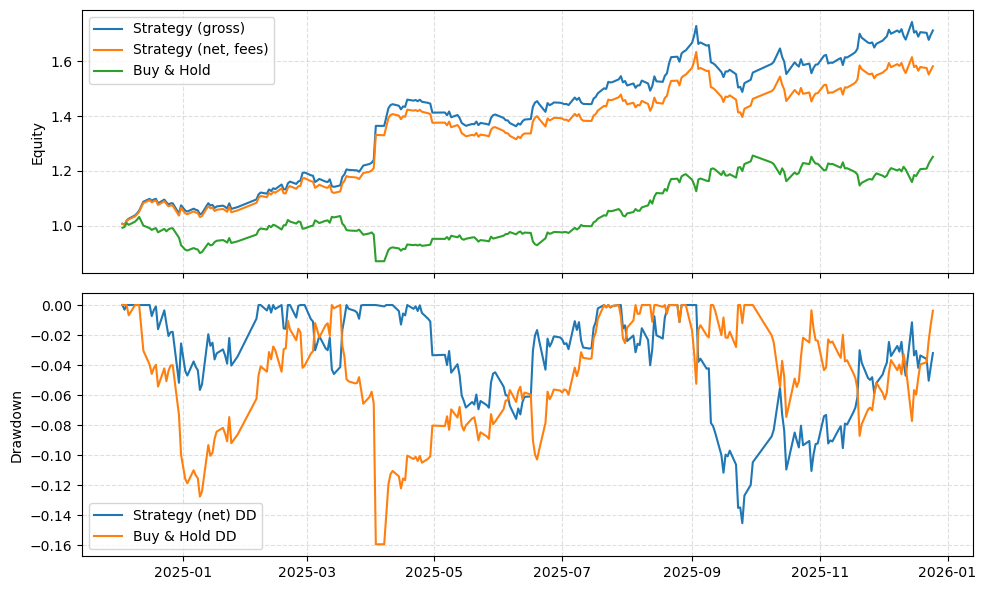

In [20]:
kimson = CTAStrategyEngine(tree = br, ticker = 'ic_main', cls = treemodel_factors_augment, strategy = 'raw_ensemble')
kimson.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'],light = False, mask = True)
kimson.compute()
q = kimson.generate(naive_backtest = True)

**MAE**

An MAE-based variant was also evaluated and demonstrates a meaningful improvement over the corresponding XGBoost implementation. However, its performance remains inferior to the RMSE-based LightGBM version, consistent with the earlier discussion: while MAE provides greater robustness through linear error penalization, it is less effective at amplifying the weak but informative residual structures that appear to drive signal extraction in this setting.

我们同时评估了基于 MAE 的版本，其表现相较于对应的 XGBoost 实现有明显提升。然而，其整体效果仍弱于基于 RMSE 的 LightGBM 版本，这与前文分析一致：MAE 由于采用线性误差惩罚，虽然提升了稳健性，但在当前场景下不如 RMSE 那样能够有效放大并利用那些微弱但具有信息含量的残差结构。

#### **Discard**

A similar pattern is also observed under the discard configuration. This suggests that observations adjacent to rollover boundaries act as a systematic source of disturbance for boosting-based models. Unlike bagging methods, boosting lacks an explicit error-decorrelation mechanism across learners; as a result, localized anomalies around roll transitions can disproportionately influence early splits and propagate through subsequent updates. Removing or excluding these roll-adjacent points therefore leads to more stable learning dynamics, indicating that rollover effects interact unfavorably with the sequential error-correcting nature of boosting.

在 discard 配置下同样可以观察到类似的现象。这表明，合约换月边界附近的样本点很可能构成了 Boosting 模型中的系统性扰动源。与 Bagging 不同，Boosting 缺乏显式的误差去相关机制，换月附近的局部异常一旦影响早期树的分裂规则，便可能在后续迭代中被持续放大。通过移除或避开这些换月相邻样本，模型的学习过程明显更加稳定，说明 rollover 效应与 Boosting 的序列化纠错结构存在不利交互。

Total runtime: 2.06 minutes


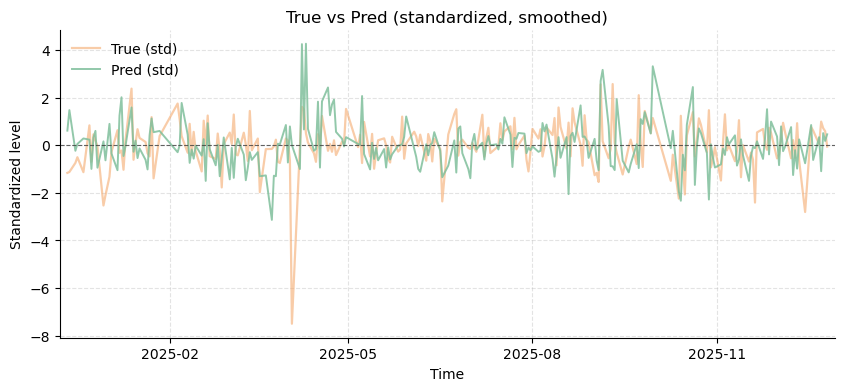

In [21]:
start = time.time()
cfg = Classic_Config()
br  = Boosting_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False, discard = True, pad = 1)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = False)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

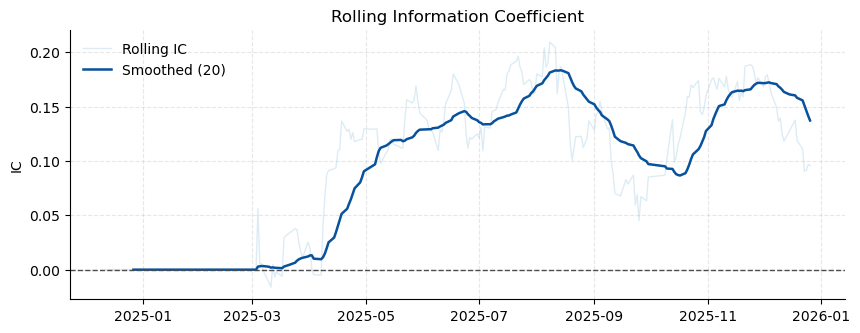

In [22]:
plot_rolling_ic(df['rolling_ic_series'])

In [23]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.09852218706207787,
 'roll_ic_median': 0.119587461420609,
 'roll_ic_q25': 0.009596336439556562,
 'roll_ic_q75': 0.15559485946747387,
 'roll_ic_frac_pos': 0.7663934426229508,
 'roll_ic_vol': 0.06796500960616143,
 'roll_ic_mdd': -0.16424039802554202,
 'roll_ic_acf1': 0.9812334899740682,
 'roll_ic_half_life': 36.587658912017524}

The rolling IC statistics remain consistently positive overall: the median is approximately 0.12, the fraction of windows with positive IC reaches about 77%, and the drawdown profile is markedly improved. The volatility of IC is moderate, indicating that the captured signal is not merely episodic, but exhibits a degree of persistence over time. Meanwhile, feature importance is more evenly distributed, suggesting that the model does not rely on a single dominant factor, but instead captures a set of dispersed, low-amplitude signals with coherent structural characteristics.

rolling IC 统计结果整体保持为正：其中位数约为 0.12，IC 为正的窗口比例约为 77%，回撤特征也明显改善。IC 的波动率处于中等水平，表明模型捕捉到的信号并非偶发，而是在时间维度上具有一定持续性。同时，特征重要性呈现出较为均衡的分布，说明模型并未依赖单一主导因子，而是刻画了一组分散、幅度较弱但具有结构一致性的信号特征。

In [24]:
br.get_xgb_gain_importance()

gain
close                          0.001305
open                           0.001281
alpha12_volflip_norm           0.001278
Downside_Semivar_7             0.001221
Residual_Vol_5                 0.001084
ret5                           0.000834
Return_ACF1_5                  0.000602
High_Volatility_Regime         0.000594
ATR_r_5                        0.000584
Range_Ratio                    0.000566
IV_Parkinson_7                 0.000553
mom_convexity                  0.000530
regime_switch_alpha24          0.000528
volume_shock_over_vol_10       0.000498
Open_Gap                       0.000486
Day_Sin                        0.000486
volume                         0.000471
ret1                           0.000465
Vol_of_Vol_7                   0.000460
trend_consistency_signed       0.000457
low                            0.000457
exhaustion_alpha9              0.000454
TRIX_like                      0.000453
Vol_Asymmetry_5                0.000444
alpha35_liquidity_rebound      0.000441
price_efficiency_under_volume  0.000414
skew_direction_alignment       0.000408
Range_CV_5                     0.000395
mom_ocillator_fast             0.000390
alpha43_volspike_reversal      0.000388

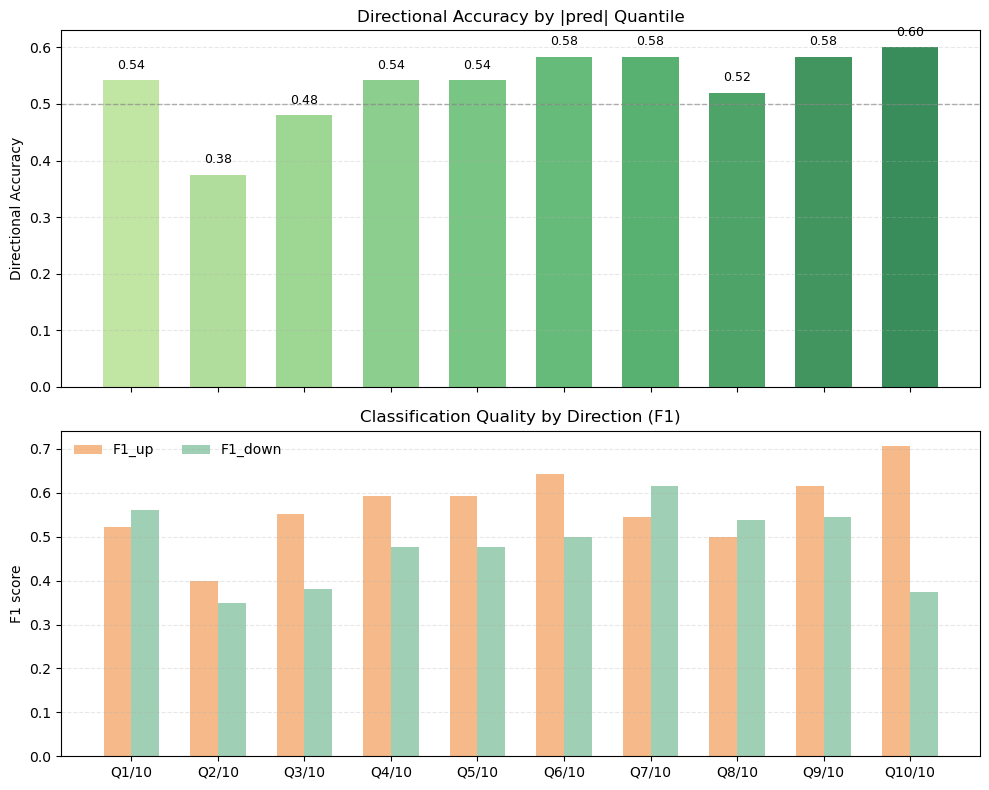

In [25]:
plot_pred_magnitude_diag(df['magnitude_table'])

Overall, the results are statistically and economically reasonable and internally consistent. When grouped by prediction strength, directional accuracy generally remains above the random baseline, with no evidence of pathological overfitting or model failure. Although a strictly monotonic relationship is absent, performance in high-confidence buckets does not deteriorate and shows stronger directional alignment when realized returns are economically significant. Sign-based economic consistency is mainly concentrated in the high-confidence tail, indicating that signals are infrequent but tend to be more reliable when they do occur.

整体结果在统计与经济含义上是合理且自洽的。按预测强度分组后，方向准确率整体维持在随机水平之上，未出现异常拟合或失效现象。尽管不存在严格的单调关系，但高置信度区间的表现并未恶化，并在真实收益幅度较大时显示出更好的方向一致性。基于符号的经济一致性主要集中在高置信度尾部，说明信号并不频繁，但在出现时更具可靠性。

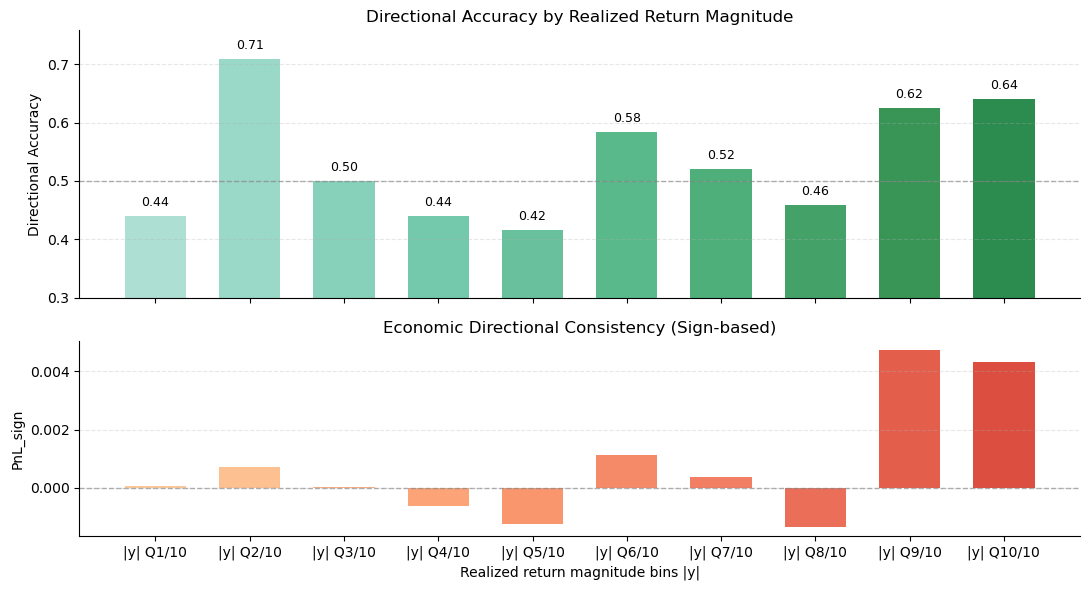

In [26]:
plot_true_magnitude_diag(df['true_mag_table'])

**Winsorization**

Under the discard configuration, applying winsorization results in a pronounced deterioration in performance: directional accuracy falls to 0.457, and both Spearman IC (−0.096) and Pearson IC (−0.069) turn clearly negative. This behavior is consistent with our earlier discussion—winsorizing economically meaningful factors can be detrimental, especially when rollover effects have already been removed. In this context, winsorization is more likely suppressing informative market structure rather than eliminating noise, further weakening the model’s directional predictive ability.

在 discard 配置下引入 winsorization 后，模型表现出现明显恶化：方向准确率下降至 0.457，Spearman IC（−0.096）与 Pearson IC（−0.069）均转为显著负值。这一结果与前文分析一致——在 rollover 效应已被剔除的情况下，对具有经济含义的因子进行 winsorization 往往是有害的。在该设定中，winsorization 更可能压制真实的市场结构信号，而非单纯去除噪声，从而进一步削弱模型的方向预测能力。

**MAE & LGBM**

In [27]:
from splitters import RollingEmbargoSplit

As discussed earlier, once rollover effects are removed, the remaining signal becomes weaker and more subtle, which is consistent with the behavior observed under MAE. Under the discard configuration, LightGBM performs particularly poorly, and this outcome is closely tied to a sharp reduction in effective sample size. After discarding rollover-adjacent observations, the usable dataset is reduced to approximately 2188 data points, which materially constrains both model fitting and cross-validation.

In this reduced-sample setting, applying a uniform rolling cross-validation splitter—training from observation 2000 with a purge gap of 5, embargo gap of 5, and step size of 65—becomes especially problematic. With only ~2188 observations available, this configuration yields very few effective folds, causing the validation process to concentrate on a narrow and highly overlapping region of the time series. As a result, model selection becomes overly adapted to specific local regimes rather than learning parameters that generalize across time, weakening out-of-sample robustness.

After adjusting the splitter to a more appropriate configuration, performance statistics improve, supporting the interpretation that the earlier degradation was driven in part by the interaction between discard-induced data reduction and an unsuitable validation scheme, rather than pure signal absence. Nevertheless, performance remains weaker than under the masked configuration, consistent with the hypothesis that discard overly suppresses rollover-related structure and leaves the model with a diminished and fragile signal to exploit.

如前文所述，在移除 rollover 效应后，数据中剩余的预测信号本身就更加细微、强度有限，这一点在 MAE 框架下表现得尤为明显。在 discard 配置中，LightGBM 的表现明显偏弱，而这一结果与有效样本量的显著下降高度相关。discard 处理后，可用于建模的数据点仅约为 2188 个，这对模型训练与交叉验证都构成了实质性约束。

在如此受限的样本规模下，若继续采用统一的滚动交叉验证划分方式（例如从第 2000 个样本开始训练，purge gap 为 5，embargo gap 为 5，step 为 65），可形成的有效折叠数量将非常有限，且验证区间在时间上高度重叠。由此导致的结果并非“验证不足”，而是模型选择过程过度适配于某些特定时间区段或局部 regime，而非学习具有时间泛化能力的参数配置，从而削弱了样本外表现的稳健性。

在将 splitter 调整为更合理的配置后，相关统计指标出现改善，这表明此前的性能退化在一定程度上源于 discard 引入的数据压缩与验证方案不匹配之间的交互作用，而非信号完全缺失。然而，即便如此，其整体表现仍弱于 mask 设定，这与 discard 对 rollover 相关有效结构产生过度抑制的判断是一致的，使模型只能在更弱、更脆弱的信号基础上进行学习。

Total runtime: 1.11 minutes


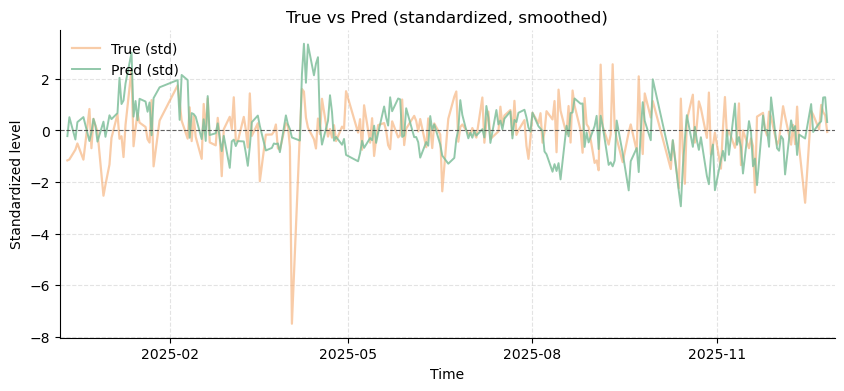

In [28]:
start = time.time()
cfg = Light_Config(splitter = RollingEmbargoSplit(train_size=1800, test_size=60,purge_gap=5, embargo_gap=5, step=65))
br  = LGBM_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False, discard = True, pad = 1)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = False)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

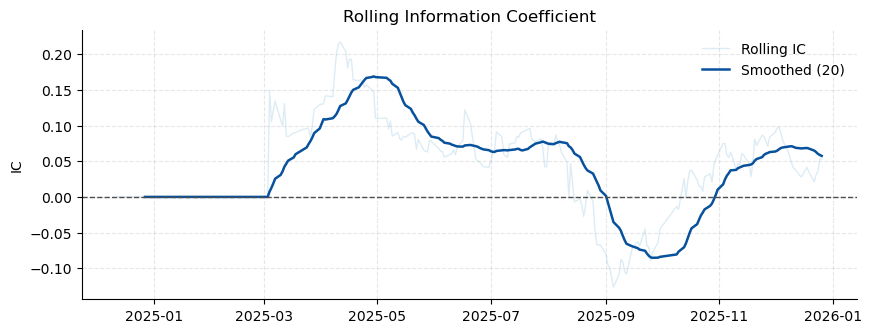

In [29]:
plot_rolling_ic(df['rolling_ic_series'])

In [30]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.04526299228661772,
 'roll_ic_median': 0.05160303263539398,
 'roll_ic_q25': 0.0,
 'roll_ic_q75': 0.08441693988656582,
 'roll_ic_frac_pos': 0.6639344262295082,
 'roll_ic_vol': 0.06498335906326459,
 'roll_ic_mdd': -0.3436064750109019,
 'roll_ic_acf1': 0.9643018823481168,
 'roll_ic_half_life': 19.068237949918053}

The rolling IC statistics are positive on average, with a median around 0.05 and roughly two-thirds of rolling windows showing positive IC. IC volatility is moderate, and the estimated half-life is relatively short, indicating that misalignment tends to dissipate rather than persist. Despite the reduced sample size and constraints imposed by the validation scheme, the overall profile remains internally consistent and shows no signs of pathological behavior.

滚动 IC 在平均意义上保持为正，其中位数约为 0.05，约三分之二的滚动窗口呈现正 IC。IC 的波动率处于中等水平，且估计的半衰期较短，表明一旦出现失配，其影响并不会长期持续。尽管样本规模受限且验证设定较为严格，整体统计特征依然自洽，未表现出明显的异常或病态行为。

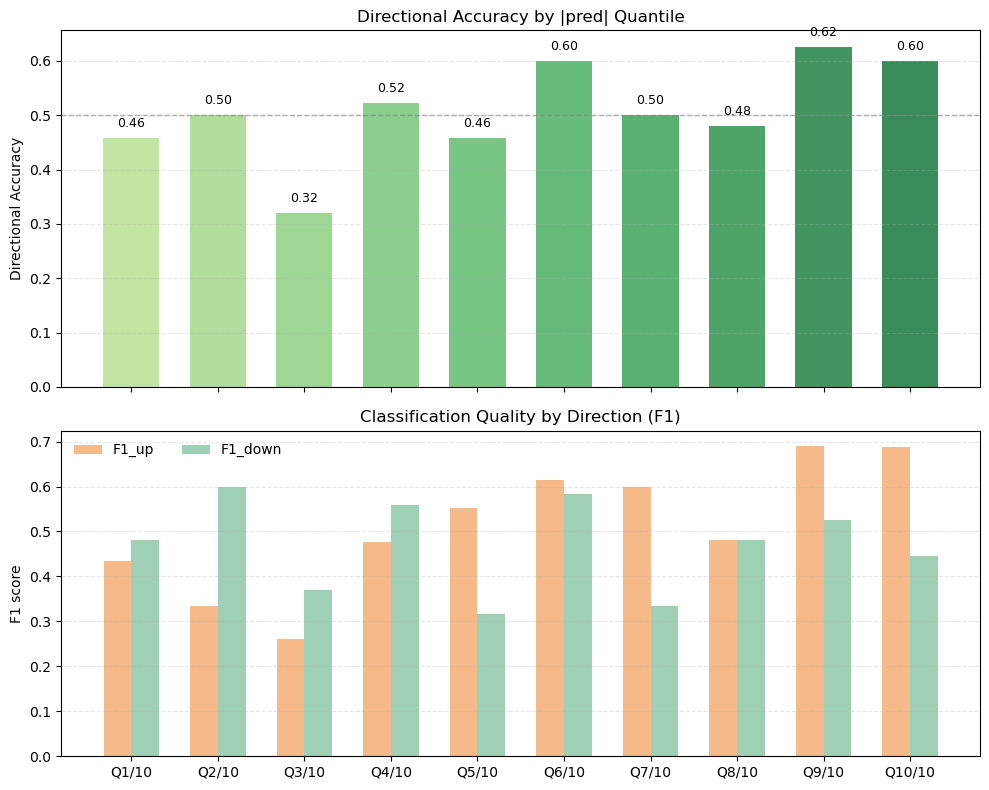

In [31]:
plot_pred_magnitude_diag(df['magnitude_table'])

The quantile-based diagnostics are broadly consistent with earlier findings. Directional accuracy remains above random across most prediction-strength bins, with no signs of pathological concentration or collapse. While monotonicity is not strict, higher-confidence bins do not deteriorate and tend to exhibit more stable F1 behavior.

When conditioning on realized return magnitude, directional accuracy improves in larger-move regimes, and sign-based economic consistency is concentrated in the high-magnitude tail. This suggests that the signal is episodic rather than pervasive, but becomes more reliable when market moves are sufficiently large, aligning with the view that the model captures weak yet economically meaningful structure rather than uniform predictability.

按预测强度与真实收益幅度分组后的结果与前文结论保持一致。整体方向准确率在大多数分位区间均高于随机水平，未出现异常集中或失效现象。尽管不存在严格的单调关系，但高置信度区间的表现并未恶化，F1 指标也相对稳定。

在真实收益幅度较大的区间内，方向准确率明显提升，且基于符号的经济一致性主要集中于高幅度尾部。这表明信号并非持续存在，而是在市场波动较大时更具可靠性，支持模型捕捉的是弱但具有经济含义的结构性信号，而非普适的方向预测。

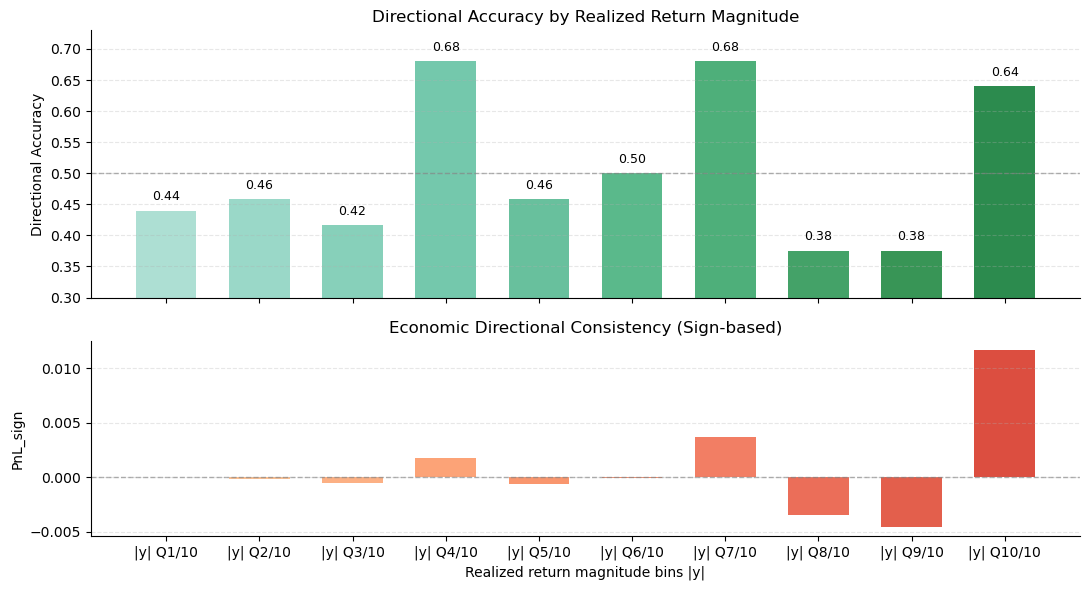

In [32]:
plot_true_magnitude_diag(df['true_mag_table'])

**CATBoost Analysis**

CatBoost entails relatively high computational cost, particularly under time-series–aware validation and repeated retraining. As a result, the hyperparameter search space is deliberately reduced compared with earlier boosting implementations. This computational constraint is also the primary reason why CatBoost has not yet been explored extensively in our framework. Nevertheless, a limited set of experiments is conducted to assess whether the additional computational overhead translates into meaningful performance improvements.

CatBoost 在计算开销方面相对较高，尤其是在引入时间序列约束的验证方式以及多次重复训练的场景下更为明显。因此，相较于此前的 boosting 实现，本次对超参数搜索空间进行了有意识的收缩。受限于计算成本，CatBoost 尚未在当前框架中进行大规模探索；但仍将通过有限的实验，评估其额外的计算开销是否能够带来具有实际意义的性能提升。

Total runtime: 9.62 minutes


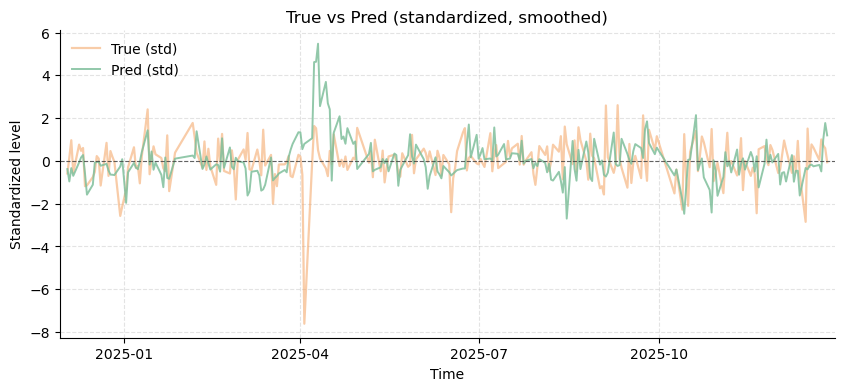

In [33]:
start = time.time()
cfg = CatBoost_Config()
br  = CatBoost_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True)
br.prep()
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

As observed, the total runtime increases to approximately 9.58 minutes even under a deliberately reduced hyperparameter grid, compared with around one minute for histogram-based boosting. This substantial computational overhead renders CatBoost relatively costly in the current setting, which reasonably justifies limiting the experiment to a single representative configuration rather than conducting large-scale batch training.

可以看到，即使在显著收缩超参数搜索空间的情况下，总运行时间仍上升至约 9.58 分钟，而基于 histogram 的 boosting 方案仅需约 1 分钟。如此显著的计算成本使 CatBoost 在当前框架下显得较为昂贵，也合理解释了为何本次仅采用单一代表性配置进行验证，而未进行大规模批量训练。

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

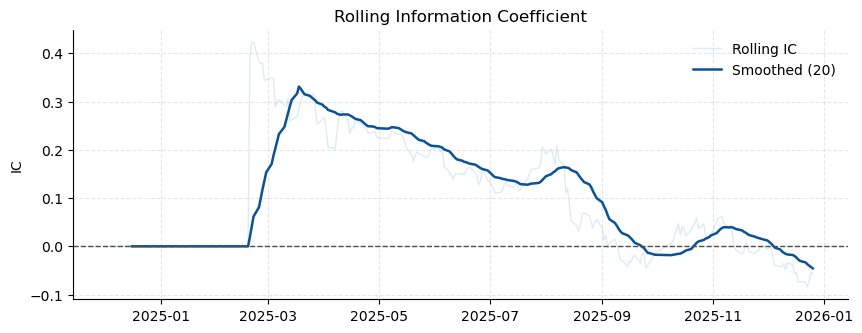

In [34]:
plot_rolling_ic(df['rolling_ic_series'])

In [35]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.10169718325752553,
 'roll_ic_median': 0.05151049084967726,
 'roll_ic_q25': 0.0,
 'roll_ic_q75': 0.19857367023945294,
 'roll_ic_frac_pos': 0.6398467432950191,
 'roll_ic_vol': 0.12122179897903967,
 'roll_ic_mdd': -0.5076045620725684,
 'roll_ic_acf1': 0.9730634881493733,
 'roll_ic_half_life': 25.384475003716844}

Rolling IC exhibits a clear life-cycle pattern: a strong initial ramp-up followed by gradual decay and eventual loss of effectiveness. The high IC autocorrelation and long half-life indicate slow structural adaptation, consistent with the conservative nature of ordered boosting. While the signal is stable and non-noisy, it lacks responsiveness to regime transitions, limiting its suitability as a primary CTA signal.

Rolling IC 呈现出明显的阶段性特征：前期快速上升，中期缓慢衰减，后期逐步失效。较高的 IC 自相关与较长的半衰期表明模型更新节奏偏慢，符合 Ordered boosting 的保守特性。整体信号具备稳定性且非噪声，但对市场状态变化的响应不足，限制了其作为主力 CTA 信号的适用性。

In [36]:
br.get_xgb_gain_importance().head(30)

feature  importance
0                   pv_divergence    6.324652
1               skew_regime_shift    6.068108
2                  mom_oscillator    3.120676
3                    mom_velocity    2.959241
4               Lower_Shadow_Frac    2.806087
5        oi_direction_persistence    2.769025
6                     Range_Ratio    2.760408
7                            high    2.614287
8               exhaustion_alpha9    2.502743
9                          volume    2.316847
10                        ATR_r_5    2.293111
11                      TRIX_like    2.215518
12                            low    2.131717
13          regime_switch_alpha24    2.101732
14                      OBV_Slope    1.869337
15                LinReg_Slope_10    1.829651
16       trend_consistency_signed    1.743146
17                 trend_age_norm    1.734220
18                           open    1.677557
19                 Residual_Vol_5    1.530922
20             Open_Pressure_Norm    1.480914
21                 Ret_Var_Corr_7    1.470237
22               path_flip_rate20    1.408907
23                           ret5    1.388938
24  price_efficiency_under_volume    1.376980
25                   Rolling_R2_5    1.340047
26         Vol_Term_Structure_5_7    1.265555
27           alpha12_volflip_norm    1.255221
28                           ret7    1.177153
29             mom_ocillator_fast    1.122649

The feature importance ranking is reasonable both statistically and in terms of economic intuition, with no evident signs of anomalies or overfitting. The model primarily exploits structural and regime-related information rather than short-term noise signals, which is highly consistent with the training characteristics of CatBoost and the observed slow evolution of the rolling IC.

特征重要性排序在统计意义和经济直觉上都是合理的，不存在明显异常或过拟合迹象。模型更偏向于利用结构性与状态型信息，而非短期噪声信号，这与 CatBoost 的训练特性以及 rolling IC 的缓慢演化行为高度一致。

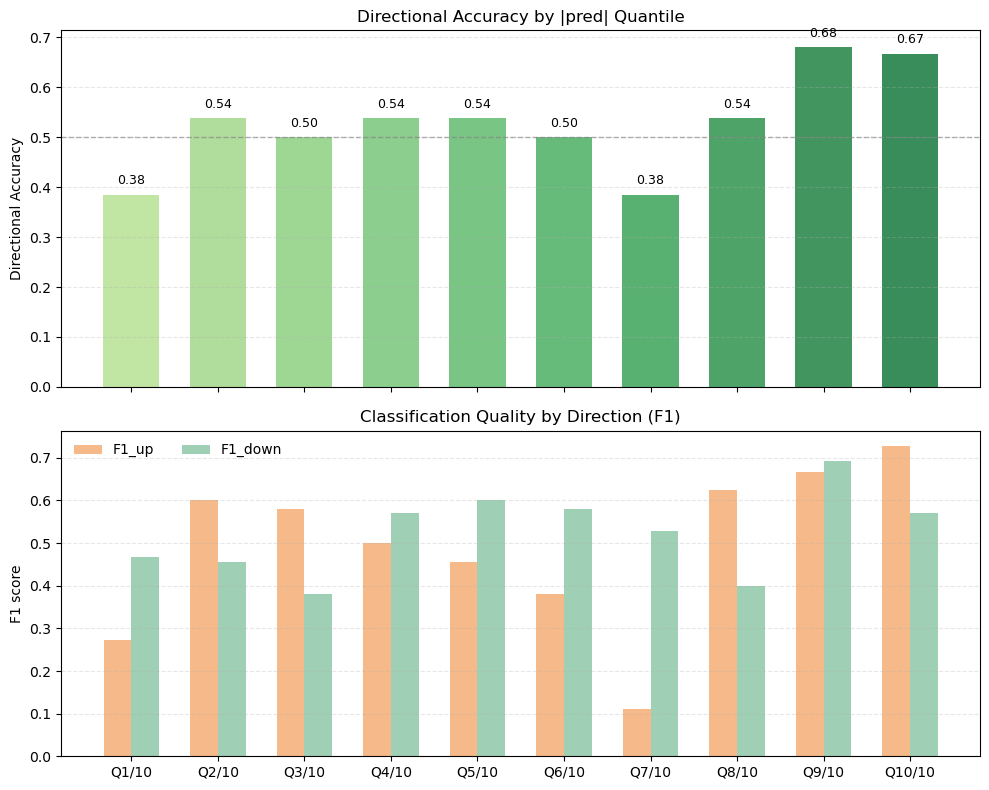

In [37]:
plot_pred_magnitude_diag(df['magnitude_table'])

CatBoost exhibits strong confidence calibration: it performs reliably only when prediction magnitude is high, avoids over-commitment in ambiguous regions, and favors structural confirmation over short-term aggressiveness. As a result, its directional accuracy is concentrated in the upper prediction quantiles, making it unsuitable as a full-coverage CTA signal but well-suited as a high-confidence filter or ensemble stabilizer.

CatBoost 的预测表现呈现出明显的置信度分层特征：仅在高 |pred| 区间内具备显著方向优势，在中低强度信号区域则主动收敛，避免过度交易。这一行为模式使其不适合作为覆盖全区间的主力 CTA 信号，但非常适合作为强信号过滤器或集成模型中的稳健锚点。

Nevertheless, when performance is examined across realized return magnitude bins, the resulting patterns appear fragmented and lack a clear monotonic structure, suggesting that the observed differences are unlikely to be driven by systematic advantages in capturing large or economically dominant price moves. This behavior may be partly attributable to CatBoost’s more balanced tree-growing strategy, in which splitting rules are applied uniformly across tree levels. Such a conservative inductive bias emphasizes stability and regularization over the aggressive extraction of weak or localized signals. In addition, the observed performance may also reflect the fact that CatBoost was not subjected to an equally exhaustive hyperparameter search as other boosting models, as certain regions of the search space were intentionally excluded due to its substantially higher computational cost under grid-based tuning. Taken together, these overlapping factors and practical computational constraints make it difficult to conclusively isolate the precise source of the performance differences at this stage.

然而，当从真实收益幅度分组的角度考察模型表现时，各区间结果较为离散，且未呈现出清晰的单调结构，这表明相关差异并非主要来源于对大幅度、经济意义更强行情的系统性刻画能力。该现象可能部分源于 CatBoost 更为均衡的树生长策略，即在各个树层级上采用相对统一的分裂规则。这种偏保守的归纳偏置更强调模型稳定性与正则化，而非对弱信号或局部结构的激进提取。此外，当前结果也可能受到超参数搜索覆盖不足的影响；由于基于网格的调参计算成本显著更高，CatBoost 的部分参数空间在实验中被有意排除。综合上述因素及实际算力约束，目前尚难以对性能差异的具体来源作出明确区分。

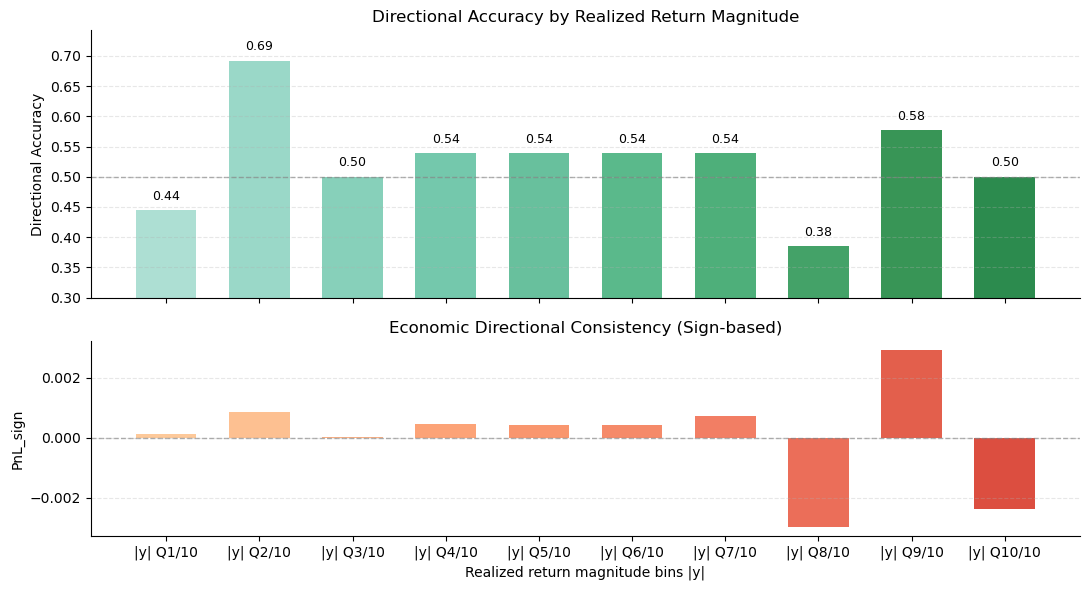

In [38]:
plot_true_magnitude_diag(df['true_mag_table'])

#### **Expert Boosting**

To address the specific failure mode discussed above—namely, the tendency for early trees to become anchored to incorrect patterns that later trees are unable to effectively correct—a viable engineering mitigation is to train models on cleaner, theme-consistent subsets of factors rather than on a single, highly heterogeneous factor library. By first constructing models that focus on individual structural themes and subsequently combining or selecting across themes, structural diversity can be preserved while reducing within-model heterogeneity, thereby improving the model’s adaptability to evolving structures and its overall robustness.

针对前文所讨论的特定失效模式——即早期树结构一旦固化在错误模式上，后续树难以对其进行有效修正——一种可行的工程化缓解方案是基于更加“干净”的主题化因子子集进行模型训练，而非直接引入完整且高度异质的因子库。通过优先构建聚焦于单一结构主题的模型，并在不同主题之间进行组合或筛选，可以在保留结构多样性的同时，有效降低单一模型内部的异质性，从而提升模型对结构变化的适应能力与整体稳健性。

**Factor Themes**

| `add_*` Module   | Theme Name                              | Information Captured                                                  | Typical Factors                                                             | Possible Expert Construction                                                                                         | Context                     |
| ---------------- | --------------------------------------- | --------------------------------------------------------------------- | -------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------- |
| `add_mom`        | Momentum / Path Dynamics            | Directional displacement, smoothness, jumps, phase acceleration       | `ret5`, `mom_velocity`, `mom_oscillator`, `path_flip_rate20`, `mom_convexity`          | Train a **short-horizon momentum expert** using only momentum & path features; apply higher weight to recent windows | Trending markets, momentum continuation regimes |
| `add_trend`      | Trend Structure / Persistence       | Trend strength, age, skew asymmetry, exhaustion                       | `trend_consistency_signed`, `trend_age_norm`, `exhaustion_alpha9`, `skew_regime_shift` | Train a **slow structural trend expert** with longer windows and stronger regularization                             | Sustained trends, low-chop environments         |
| `add_volatility` | Volatility Level & Regime           | Vol magnitude, clustering, asymmetry, volatility shocks               | `ATR_r_5`, `Vol_Term_Structure_5_7`, `Vol_Spike_Regime`, `Downside_Semivar_7`          | Build a **risk / regime expert** that predicts *when* signals should be trusted, not direction                       | Regime shifts, pre/post shock periods           |
| `add_cycle`      | Cycle / Phase Geometry              | Hilbert phase, cycle stability, turning points                        | `Phase_Velocity`, `Cycle_Regime`, `Cycle_Turning_Point`, `Phase_Signal_Reliable`       | Train a **cycle-timing expert** with strict masking and low tree depth                                               | Mean-reverting or oscillatory markets           |
| `add_flow`       | Order Flow & Participation         | Volume–price interaction, liquidity pressure, participation imbalance | `pv_divergence`, `OBV_Slope`, `volume_entropy_10`, `price_efficiency_under_volume`     | Train a **flow-confirmation expert**; often best used as a filter                                                    | Breakouts, accumulation/distribution phases     |
| `add_reg`        | Local Regression / Microstructure   | Local slope, residual volatility, fit quality                         | `LinReg_Slope_10`, `Rolling_R2_5`, `Residual_Vol_5`                                    | Use as a **local structure validator** or secondary expert                                                           | Stable microstructure, low noise windows        |
| `add_intra_day`  | Intraday Geometry / Session Effects | Candle shape, gap pressure, intrabar extremes                         | `Lower_Shadow_Frac`, `Range_Ratio`, `Open_Pressure_Norm`                               | Build an **intraday timing expert** (often classification-style)                                                     | Intraday strategies, session boundaries         |
| `add_time`       | Calendar / Time Regime             | Seasonality, session encoding, time geometry                          | `Day_Sin`, `Month_End`, `Trading_Hour_Index`                                           | Usually **not standalone**; used as conditioning features                                                            | Calendar effects, session-dependent behavior    |
| `add_roll`       | Contract Roll & Transition Effects  | Roll proximity, post-roll instability                                 | `is_near_roll`, `post_roll_vol_decay`, `roll_price_efficiency`                         | Train a **roll-aware expert** or use as a *gate*                                                                     | Futures around roll dates                       |


Based on previous validation results, all features are properly lagged by one bar, with the exception of OHLC, volume, and open interest (where open and open interest can, in principle, be observed earlier). In the expert boosting setup, we therefore start from a feature set that excludes OHLC-type variables, which in theory allows the decision time to shift earlier. However, given the limitations of the current research environment and implementation assumptions, further justification and verification are still required.

基于此前的验证结果，除 OHLC、成交量及持仓量外，其余特征均已严格进行了一期滞后处理（其中 open 与 open interest 在技术上可较早获取）。在 expert boosting 的设计中，我们因此从不包含 OHLC 类变量的特征集合出发，理论上可将决策时间前移。但受限于当前研究环境及实现假设，该结论仍需进一步论证与验证。

**Failure Configuration Reassessment**

In earlier experiments, XGBoost models without masking (mask = False) exhibited pronounced instability and lacked clear economic interpretability. Before introducing more complex expert structures, we first examine whether the hypotheses proposed above can deliver substantive improvements. As an initial exploration, we focus on a classical momentum-based factor family. Given time and computational constraints, exhaustively testing all factor categories and simply comparing “which performs better” would be neither methodologically rigorous nor economically well grounded. In particular, under heterogeneous asset and structural conditions—where a single factor family is often insufficient to independently drive meaningful improvements—it would be inappropriate to attribute model failure to a specific technique based solely on performance under a restricted experimental setting. Accordingly, at the current stage, the observation of stable and economically meaningful performance improvements is sufficient to serve as a positive signal, indicating that the proposed approach retains potential viability even in cases where joint training over heterogeneous factor sets fails.

在此前的实验中，未加掩码（mask = False）的 XGBoost 模型表现出较强的不稳定性，且缺乏清晰的经济解释。在进一步引入更复杂的专家结构之前，我们首先检验前文提出的假设是否能够带来实质性的改进。作为初步探索，本研究从经典的动量因子类别入手。受时间与计算资源限制，逐一测试所有因子类别并简单比较“哪一类效果更好”，在方法论上并不严谨，在经济解释上也难以成立。尤其是在不同资产与不同结构条件下，单一因子类别本身往往难以独立驱动显著改进的情况下，仅依据某一受限设定下的表现便将模型失效归因于某一具体技术，显然并不恰当。因此，在当前阶段，只要能够观察到稳定且具有经济意义的性能改善，便已足以作为积极信号，表明该方法在整体异质因子联合训练失效的情形下，仍具备潜在的可行性。

Total runtime: 0.28 minutes


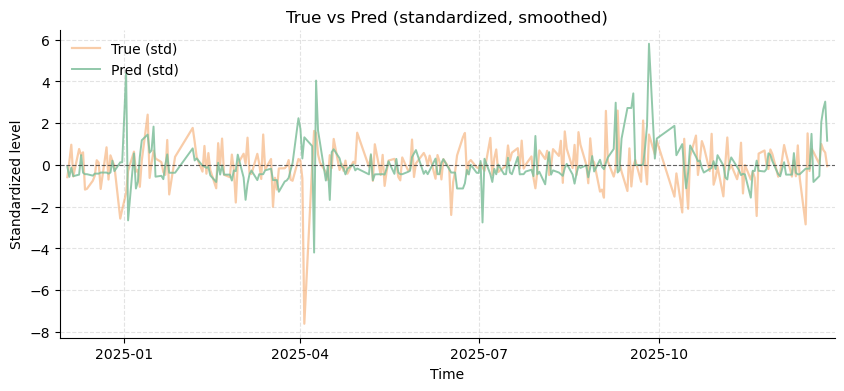

In [39]:
start = time.time()
cfg = Classic_Config()
br  = Boosting_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
br.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = False)
br.prep(list_augmentation(family=('mom',), augment=False, verbose=False,)[0])
br.split()               
br.tune_level1()
br.tune_level2()
br.tune_level3()
df = br.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

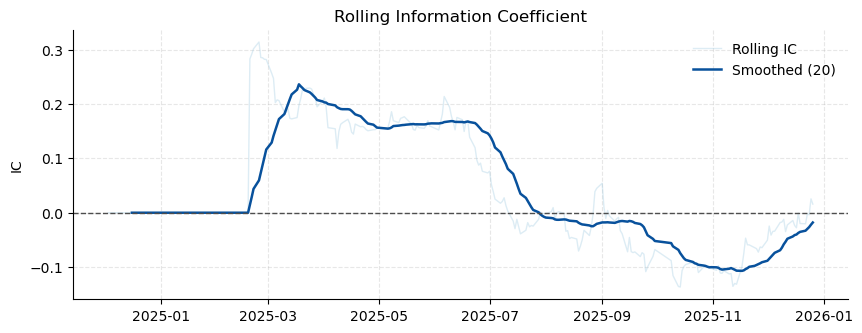

In [40]:
plot_rolling_ic(df['rolling_ic_series'])

In [41]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.04122150748284708,
 'roll_ic_median': 0.0,
 'roll_ic_q25': -0.032958120611563425,
 'roll_ic_q75': 0.15625708963920276,
 'roll_ic_frac_pos': 0.41762452107279696,
 'roll_ic_vol': 0.11030166740687801,
 'roll_ic_mdd': -0.45056173198411054,
 'roll_ic_acf1': 0.9799954275090433,
 'roll_ic_half_life': 34.301696510078905}

From an information coefficient (IC) perspective, the momentum-only configuration shows a clear improvement relative to the fully heterogeneous setup. Specifically, the rolling mean IC increases from −0.033 to +0.041, while the fraction of windows with positive IC rises from 17.6% to 41.8%, indicating that the systematic negative bias observed previously has been largely removed. The median IC, however, remains close to zero, and the IC distribution continues to exhibit high volatility (IC std ≈ 0.11) and strong persistence (ACF(1) ≈ 0.98), together with sizable drawdowns (IC MDD around −45%). These statistics suggest that while momentum alone restores conditional predictive validity, its contribution remains strongly regime-dependent and insufficient as a standalone component.

从信息系数（IC）的统计表现来看，动量单一配置相较于完全异质化特征组合呈现出明显改善。具体而言，滚动平均 IC 由 −0.033 提升至 +0.041，IC 为正的窗口占比也从 17.6% 上升至 41.8%，表明此前存在的系统性负偏差已基本消除。然而，IC 的中位数仍接近于零，且 IC 分布依旧表现出较高的波动性（标准差约为 0.11）和显著的自相关性（ACF(1) 约 0.98），同时伴随着较大的回撤幅度（IC 最大回撤约 −45%）。这些统计特征说明，尽管动量因子在一定条件下恢复了预测有效性，其效果仍具有较强的状态依赖性，尚不足以作为独立的预测组件。

In [42]:
br.get_xgb_gain_importance().head(30)

gain
mom5_unexpected        0.005923
path_flip_rate20       0.003951
path_flip_rate10       0.003805
mom_oscillator         0.003254
mom_efficiency         0.002596
ret5                   0.002535
mom_acf_decay          0.002508
mom_velocity           0.002444
TRIX_like              0.002351
mom_ocillator_fast     0.002332
sign_variance          0.002284
path_entropy           0.002167
trend_probability_ema  0.002127
RSI_14_Log_Spaced      0.001947
ret1                   0.001910
ret7                   0.001847
mom_efficiency_fast    0.001789
mom_half_life          0.001683
KD_Diff_logclose       0.001639
mom_convexity          0.001627
ret5_volatility_adj    0.001250
trend_probability      0.000559

From the XGBoost gain decomposition, the momentum-only configuration exhibits uniformly low split gains, with the highest individual feature contributing approximately 0.006 in average loss reduction and the majority of features clustered in the 0.001–0.003 range. This flat and rapidly decaying importance profile indicates that predictive information is weakly distributed across features, rather than concentrated in a small set of dominant signals.

从 XGBoost 的 gain 分解结果来看，动量类因子的分裂增益整体处于较低水平，单个特征对损失函数的平均改进幅度最高约为 0.006，其余大多数特征集中在 0.001–0.003 区间内，且重要性分布快速衰减。该特征表明预测信息在因子之间呈现出分散而非集中的结构。

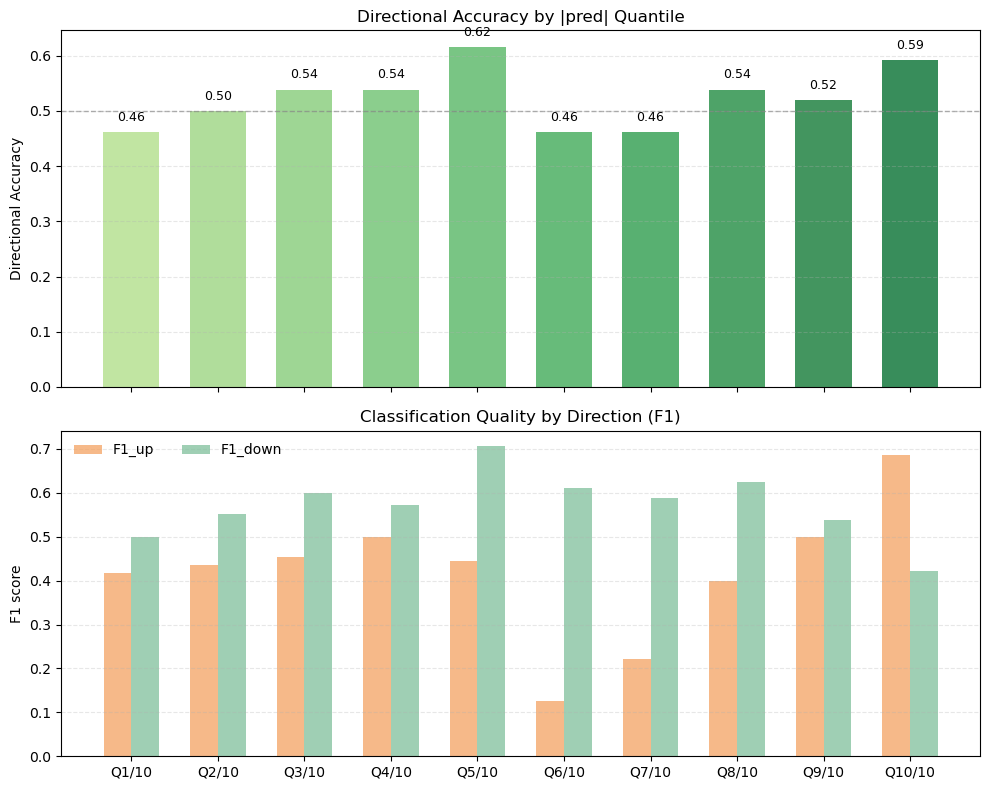

In [43]:
plot_pred_magnitude_diag(df['magnitude_table'])

Directional accuracy fluctuates around the random baseline, ranging from 0.46 to 0.59 across signal deciles, indicating conditional rather than uniform predictive validity. F1 decomposition reveals strong asymmetry: downside classification is consistently stronger (F1_down ≈ 0.55–0.71) while upside performance is weak in mid-deciles (F1_up as low as 0.12–0.22), only recovering in the highest decile (0.69). Conditioning on realized return magnitude further shows that directional accuracy peaks for economically meaningful but non-extreme moves (up to 0.65), while sign-based PnL becomes negative in the largest-magnitude buckets (down to −0.006), highlighting pronounced regime dependence and payoff asymmetry. Overall, the results suggest that while the momentum-only expert restores conditional predictive structure, it remains insufficient as a standalone component and primarily captures downside-dominant regimes rather than balanced directional alpha.

方向准确率在各信号分位间围绕随机水平波动，区间约为 0.46–0.59，表明预测能力具有明显的条件性而非全局稳定性。F1 指标显示出显著的不对称结构：下跌方向识别能力稳定且较强（F1_down ≈ 0.55–0.71），而上涨方向在中等分位显著偏弱（F1_up 最低约 0.12–0.22），仅在最高分位回升至 约 0.69。在按真实收益幅度分组后，方向准确率在具有经济意义但非极端的区间达到峰值（最高 约 0.65），而在最大幅度区间中，符号化 PnL 转为负值（最低 约 −0.006），反映出明显的制度依赖性与收益结构不对称。总体而言，纯动量专家在恢复条件性预测结构方面是有效的，但作为单一组件仍显不足，其主要刻画的是偏向下行的状态而非均衡的方向性 alpha。

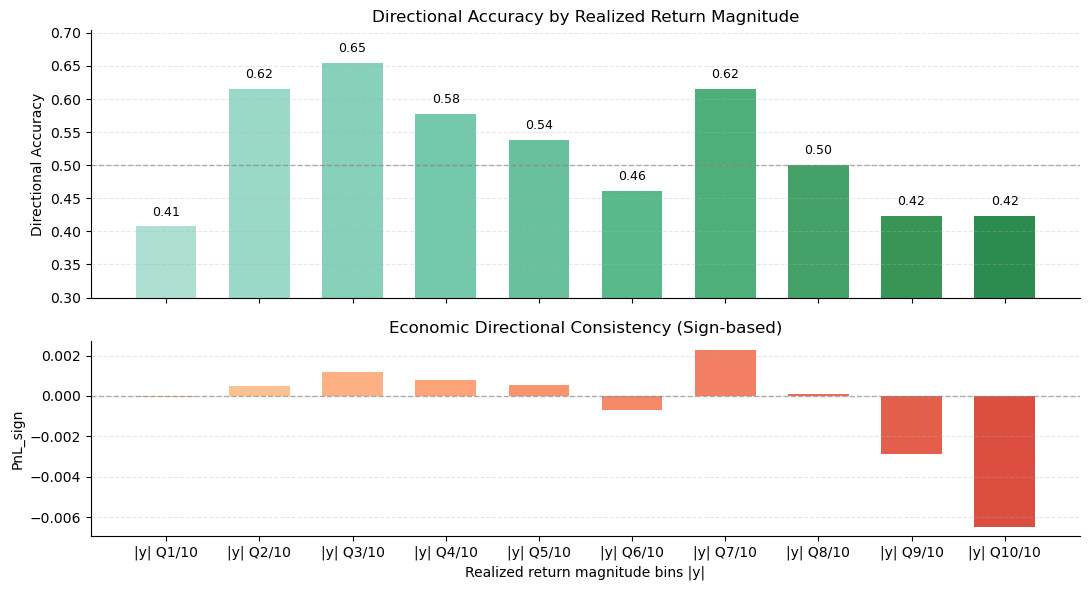

In [44]:
plot_true_magnitude_diag(df['true_mag_table'])

Based on the momentum-only experiments, heterogeneous factor sets under a mismatched optimization objective are likely one of the contributors to model instability. At the same time, single-factor-class experts tend to exhibit strong conditional dependence and lack robustness as standalone components.

Under this context, directly proceeding to explicit gating experiments is not feasible, both in terms of computational efficiency and statistical reliability. As a pragmatic intermediate solution, we instead combine a small number of semantically consistent or complementary factor families, apply masking to reduce structural distortions, and adopt models with higher expressive capacity (e.g., LightGBM), allowing conditional interactions to be learned implicitly by the model itself.

Other configurations are temporarily omitted, and the analysis largely follows prior findings on the IC500 dataset. These conclusions are therefore not assumed to generalize across assets, and their extensibility to other instruments remains an open empirical question.

就动量实验结果而言，在优化目标存在错配的情况下，引入高度异质的因子集合，很可能是导致模型表现不稳定的原因之一；与此同时，单一因子类别构成的专家模型往往呈现出明显的条件依赖性，难以作为稳健的独立组件。

在此背景下，直接开展显式的门控（gating）实验，在计算效率与统计可靠性两个层面均不具备现实可行性。作为务实的中间方案，我们选择将少量语义一致或互补的因子族进行组合，并通过 masking 降低结构性扭曲，同时引入表达能力更强的模型（如 LightGBM），以期由模型自身隐式学习条件交互关系。

其余配置方案暂不展开讨论，相关分析沿袭此前针对 IC500 数据的研究结论，但并不假设其对其他资产具有必然的延展性。

**Roll and Macro**

Although roll-related and macro features were not incorporated into the bagging framework—since they primarily act as state or contextual variables and contribute little to error decorrelation in ensemble learning—they were nonetheless constructed and evaluated for the IC500 universe. Due to limited research resources, further iterative development and systematic experimentation on these features have been temporarily suspended. Consequently, the roll and macro factor set included in this study is intentionally kept minimal, and no further expansion will be undertaken unless additional research capacity becomes available and the direction is formally re-approved.

尽管换月（roll）与宏观类特征并未被纳入 Bagging 框架中（其主要起到状态或上下文刻画的作用，对于集成模型中误差去相关的帮助有限），我们仍针对 IC500 品种对相关特征进行了构建与初步评估。受限于研究资源，当前阶段尚无法对该类特征进行系统性的迭代优化与深入实验。因此，本文中所使用的换月与宏观特征集合被有意控制在较为有限的范围内，除非后续研究资源得到补充并经正式重新立项，否则不再进一步扩展。

**Roll**

is_near_roll
This indicator flags observations that fall within the predefined roll window. It is used to signal periods of reduced price reliability and potential microstructure distortion around contract switches, allowing the model to adjust its behavior accordingly. Under masking, it also serves as an explicit indicator that forward-filling is occurring.

该指标用于标记处于预定义换月窗口内的观测点，用以提示合约切换期间价格可靠性下降及潜在的微观结构扰动，从而帮助模型在该阶段调整行为。在启用 masking 的情况下，该变量同时作为前向填充（forward fill）发生的显式标识。

post_roll_vol_decay
This factor captures short-horizon return behavior immediately after a roll using a segment-aware exponential smoothing scheme. It reflects the temporary volatility adjustment following a contract transition and the speed at which price dynamics return to normal.

该因子通过分段感知的指数平滑方式刻画换月后短期收益行为，反映合约切换完成后短暂的波动调整过程，以及价格行为回归正常状态的速度。

**Macro**


Breadth-up reflects cross-sectional market participation by measuring the proportion of index constituents moving in the same direction, and is therefore treated as a market state or conditioning variable rather than a direct alpha signal. The basis factor captures the relative pricing between the index future and its spot reference, conveying information about carry conditions and short-term market expectations; however, its stability may be affected by data alignment and spot proxy construction, particularly around roll periods. Similarly, credit spread and related macro-style indicators are economically meaningful but are currently used only in a supportive role due to limitations in data construction and update consistency. In addition, categorical indicators that flag forward-filling or data adjustments are included to signal potential changes in data reliability, rather than to drive directional forecasts. As such, these variables are retained conservatively and are not emphasized as core predictive features in the current iteration.

Breadth-up 用于刻画指数成分股的横截面参与程度，反映市场上涨或下跌是否具有广泛一致性，因此主要作为市场状态或条件变量使用，而非直接的预测因子。Basis 描述期货与现货之间的相对定价关系，包含一定的持有成本与短期市场预期信息，但受限于平台层面的数据对齐与现货代理质量问题，尤其在换月阶段，其稳定性仍需进一步验证。类似地，credit spread 等宏观或跨市场指标在经济含义上是合理的，但由于数据构造与更新频率的限制，目前仅作为辅助性状态信息保留。此外，用于指示前向填充或数据修复发生的类别型变量 (avil)，主要用于提示潜在的数据可靠性变化，而非直接参与方向性预测。在当前阶段，这类因子均被谨慎使用，未作为核心 alpha 信号重点依赖。

**Conditioned Momentum Expert**

We construct the first expert by combining momentum, flow, and intraday features, motivated by their consistency in both time horizon and economic interpretation. Momentum characterizes short-term directional persistence and path dynamics; flow reflects whether such direction is supported by trading activity and market participation; and intraday features describe microstructure and execution-related patterns within individual bars. Taken together, these components express a coherent short-horizon directional hypothesis rather than competing signals, making it reasonable to model them jointly and allow the learner to capture their nonlinear interactions. This design choice is inherently subjective and not unique, and its effectiveness may vary across assets and sampling frequencies, necessitating asset-specific validation.

我们将动量、成交流以及日内结构特征组合构建第一个专家，主要基于它们在时间尺度和经济含义上的一致性。动量刻画短期方向延续性与路径结构，成交流反映该方向是否得到交易活跃度与市场参与的支持，而日内特征则描述单根 K 线内的微观结构与执行相关行为。三者共同构成了一个短周期方向性假设，而非相互竞争的信号，因此将其联合建模并交由模型学习其非线性交互关系是合理的。需要指出的是，这种专家划分本身具有一定主观性，也并非唯一选择，其适用性可能随资产类别和频率而变化，因而仍需在具体资产层面进行验证。

Total runtime: 0.75 minutes


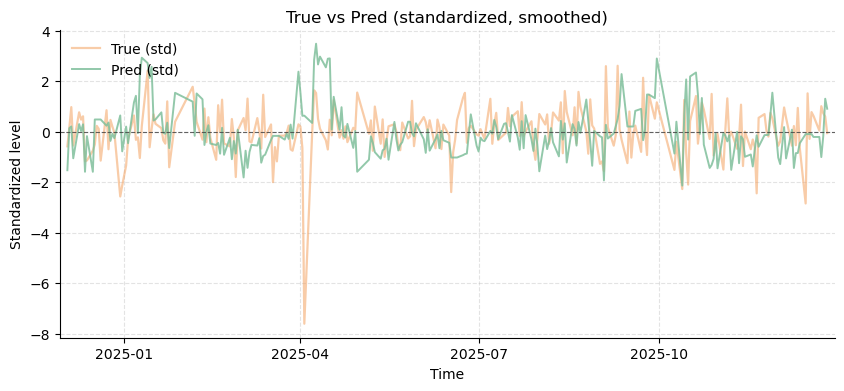

In [45]:
start = time.time()
cfg = Light_Config()
mom  = LGBM_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
mom.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True, roll_encode = True)
mom.prep(feature_list = list_augmentation(family=('mom','flow', 'intra'), to_add = ['is_near_roll', 'post_roll_vol_decay'], augment=False, verbose=False,)[0])
mom.split()               
mom.tune_level1()
mom.tune_level2()
mom.tune_level3()
df = mom.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

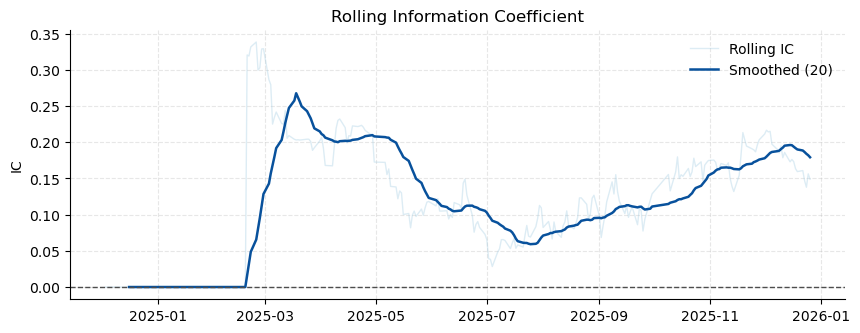

In [46]:
plot_rolling_ic(df['rolling_ic_series'])

In [47]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.12133903933738298,
 'roll_ic_median': 0.11821093893076283,
 'roll_ic_q25': 0.06846477065588971,
 'roll_ic_q75': 0.17983387720278923,
 'roll_ic_frac_pos': 0.8122605363984674,
 'roll_ic_vol': 0.08173479780916548,
 'roll_ic_mdd': -0.3102967699664753,
 'roll_ic_acf1': 0.9560068183390835,
 'roll_ic_half_life': 15.40661432446829}

The rolling IC shows a mean around 0.12 with a similar median and ~81% positive windows, indicating stable and persistent predictive power. IC volatility is moderate, and the half-life of ~15 bars is consistent with a short- to medium-horizon expert that remains adaptive without being overly slow.

该模型的滚动 IC 均值约为 0.12，中位数接近，且约 81% 的窗口为正，表明信号具有稳定且持续的预测能力。IC 波动处于可控水平，半衰期约 15 个周期，符合短中期专家的特征，既具备持久性，又不过度迟滞，整体表现健康。

In [48]:
df['lag_ic']

{-10: -0.06086721765189111,
 -9: -0.07326945497889252,
 -8: -0.15103343728680826,
 -7: -0.06377627847129243,
 -6: -0.07510490793769847,
 -5: -0.07599992060783807,
 -4: -0.0424109955706996,
 -3: -0.09640786483848826,
 -2: 0.09273156169153246,
 -1: -1.945880954149404e-05,
 0: 0.15429766760735067,
 1: 0.05133199818783774,
 2: 0.009356282449441918,
 3: 0.08537398109160295,
 4: 0.08997746754951585,
 5: -0.048956863672702314,
 6: 0.05557057277334824,
 7: 0.024901203283132726,
 8: -0.03154446850173624,
 9: 0.01946266852590765,
 10: 0.012566591285440847}

Negative lags (−10 to −1) are mostly negative, suggesting the signal is not driven by look-ahead effects. The IC peaks at lag 0 (~0.15), indicating contemporaneous predictive strength, while positive lags (1–4) remain positive but decay, consistent with short-term persistence rather than long-lived leakage.

负滞后（-10 到 -1）整体偏负，说明信号并非“事后相关”；在 lag = 0 处 IC 达到峰值（约 0.15），表明预测力主要集中在当期；正滞后（1–4）仍保持正相关但逐步衰减，反映出信号存在一定延续性，但不会长期滞留。

The Ljung–Box p-values at multiple lags (1, 5, 10, 20) are all comfortably above standard significance thresholds, indicating no statistically significant residual autocorrelation.

这些 Ljung–Box p 值在不同滞后阶数（1、5、10、20）下均明显高于常用显著性水平，说明残差中未检测到显著的自相关结构。

In [49]:
df['residuals']['summary']['ljungbox_p']

{1: 0.8127377412693845,
 5: 0.7957764274945724,
 10: 0.7993191775961037,
 20: 0.33999813661357753}

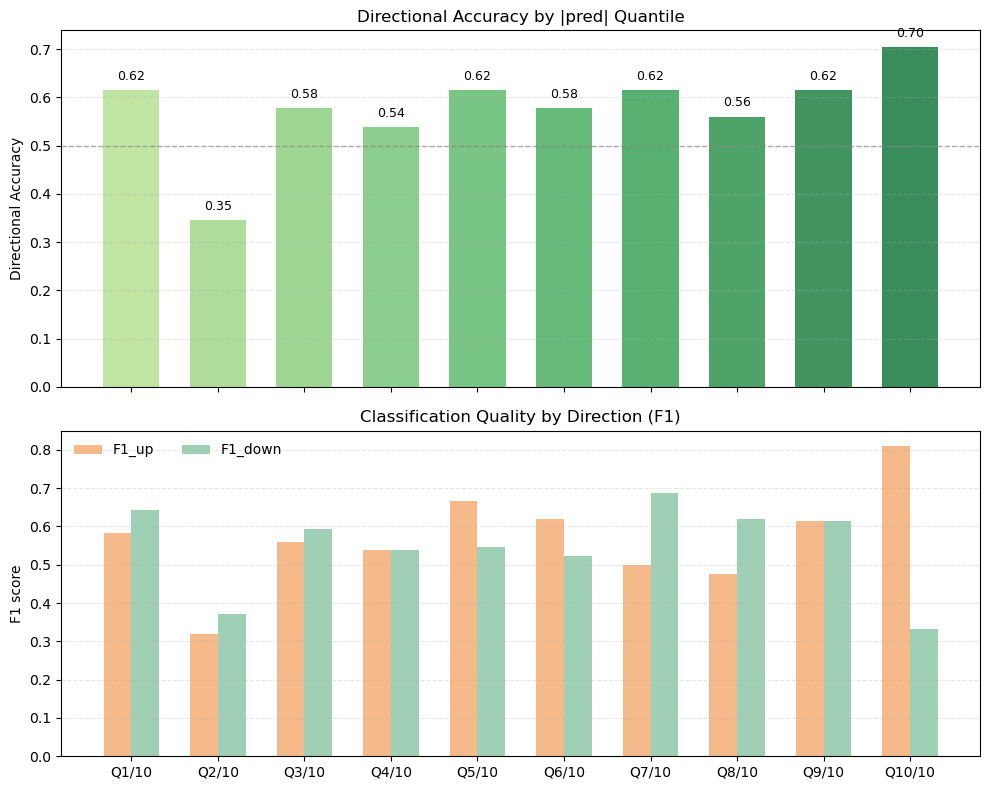

In [50]:
plot_pred_magnitude_diag(df['magnitude_table'])

Model performance improves with signal strength: directional accuracy increases in higher |pred| quantiles, classification quality remains reasonably balanced between up and down moves, and both accuracy and sign-based PnL are strongest in larger realized return bins. Together, this suggests the model’s confidence ranking is informative and that it tends to align with economically meaningful price moves, contributing primarily in higher-impact regimes rather than through frequent small or noise-driven trades.

模型表现随信号强度增强而改善：在预测绝对值较高的分位区间中方向准确率更高，上下方向的分类质量总体均衡，而在实际收益幅度较大的区间中，方向准确率与基于符号的收益均表现更好。整体来看，模型的信号强弱排序具有信息含量，主要在具有经济意义的行情中发挥作用，而非依赖高频、小幅波动获取收益。

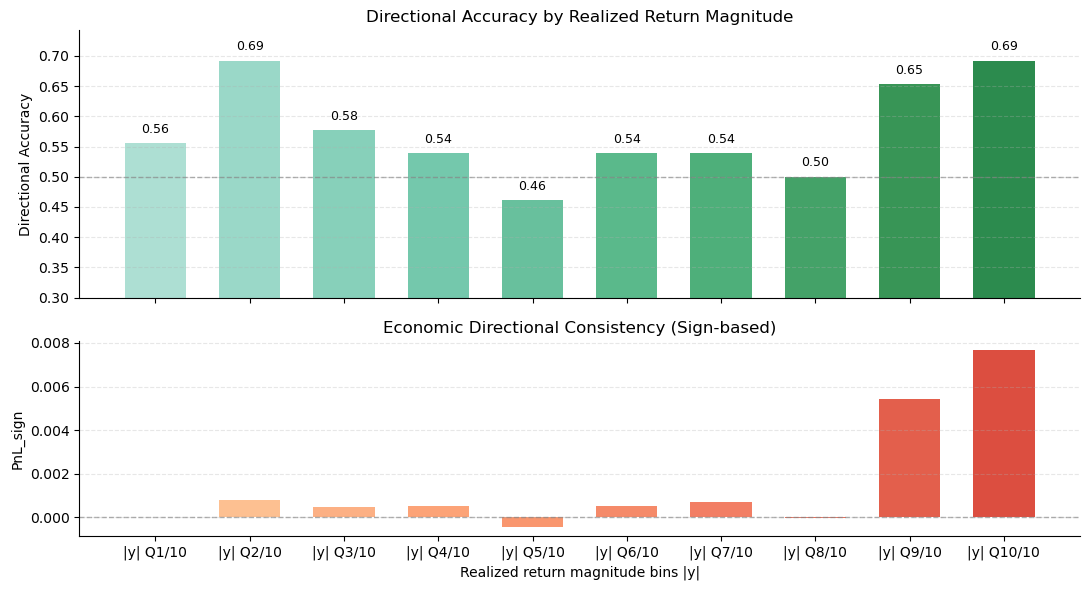

In [51]:
plot_true_magnitude_diag(df['true_mag_table'])

Sign of Ensemble only
=== Backtest summary ===
Sample size        : 260 obs
Directional Acc.   : 0.577
IC (Spearman)      : 0.145
IC (Pearson)       : 0.117
Trade days         : 100
Total turnover     : 199.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 40.18%
  Ann. vol         : 21.91%
  Sharpe           : 1.83
  Sortino          : 2.25
  Max drawdown     : -10.77%

Strategy (net after fees):
  Ann. return      : 30.53%
  Ann. vol         : 21.95%
  Sharpe           : 1.39
  Sortino          : 1.72
  Max drawdown     : -10.77%

Buy & Hold:
  Ann. return      : 24.21%
  Ann. vol         : 22.00%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


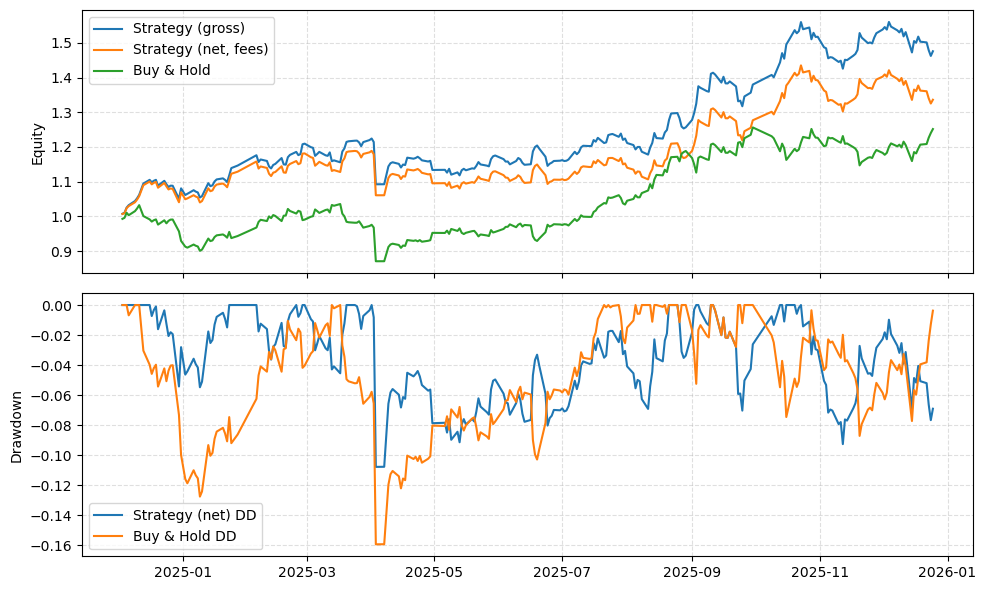

In [52]:
model01 = CTAStrategyEngine(tree = mom, ticker = 'ic_main', cls = treemodel_factors_augment, strategy = 'raw_ensemble')
model01.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'],light = False, mask = True, roll_encode = True)
model01.prep(feature_list = mom.artifacts['feature_cols'])
model01.compute()
q = model01.generate(naive_backtest = True)

Overall, the results suggest a solid and well-behaved signal: despite only moderate directional accuracy and IC, the strategy achieves superior risk-adjusted performance relative to buy-and-hold, with higher returns, improved Sharpe, and a meaningfully smaller maximum drawdown. The moderate positive correlation with the market indicates some exposure to broad market movements, but not dominance by beta, implying the strategy adds incremental alpha while maintaining diversification benefits.

总体来看，该策略在风险调整后表现优于基准：在方向准确率和 IC 处于中等水平的前提下，实现了更高的年化收益和 Sharpe，比买入并持有具有更低的最大回撤，说明收益主要来自较为稳定的方向判断与仓位管理，而非单纯依赖市场 beta。同时，策略与市场的相关性为中等偏低，表明其具备一定的独立性与分散化价值，但仍保留部分顺周期暴露，整体表现符合一个“有信息含量、但不激进”的信号特征。

In [53]:
corr_analysis(q)

Corr(strat, market): 0.22271901761925714


**Controlled trend**

We construct the second expert as a controlled trend module focused on medium- to lower-frequency directional opportunities. Trend features form the backbone, while flow and volatility are introduced as conditioning variables to assess whether the trend is supported by trading activity and whether the prevailing risk regime is suitable for deployment. Roll-related and breadth signals further state-condition the trend, helping to avoid over-exposure during structurally noisy periods or when market participation is weak. The intent is not to maximize raw trend strength, but to deploy trend signals more robustly across varying market states.

我们将第二个专家构建为一个以受控趋势（controlled trend)为核心的结构，重点刻画中低频方向性机会。该专家以趋势因子为主轴，引入流动性与波动率作为条件约束，用于判断趋势是否得到交易行为支持以及当前风险环境是否适合介入。同时，通过加入换月相关与广度类变量，对趋势信号进行状态化修正，避免在结构性噪声或参与度不足的阶段过度暴露。整体目标并非放大单一趋势强度，而是在不同市场状态下更稳健地筛选和执行趋势。

Total runtime: 0.92 minutes


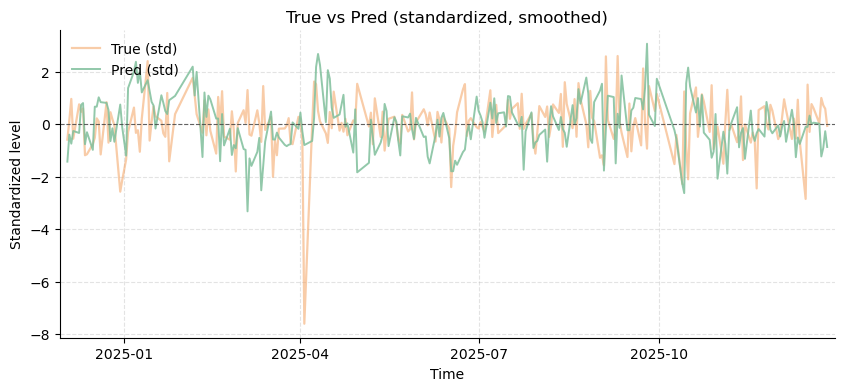

In [54]:
start = time.time()
cfg = Light_Config()
trend  = LGBM_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
trend.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True, roll_encode = True, augmentor = IC_Augment)
trend.prep(list_augmentation(family=('trend','flow', 'vol'), to_add = ['is_near_roll', 'post_roll_vol_decay', 'breadth_ma10', 'breadth_ma10_avail'], augment=False, verbose=False,)[0])
trend.split()               
trend.tune_level1()
trend.tune_level2()
trend.tune_level3()
df = trend.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

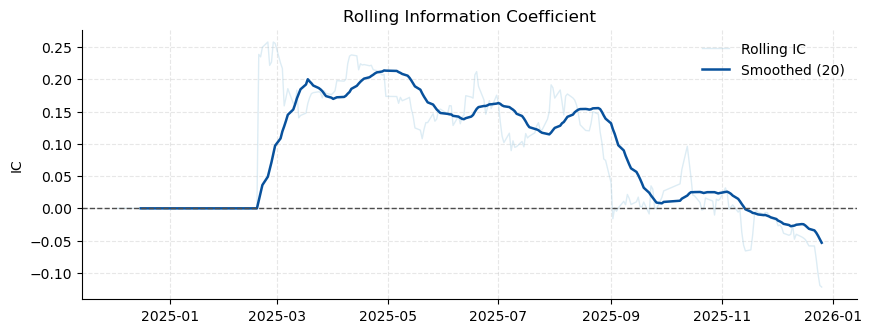

In [55]:
plot_rolling_ic(df['rolling_ic_series'])

In [56]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.08115041677624743,
 'roll_ic_median': 0.09454957854779868,
 'roll_ic_q25': 0.0,
 'roll_ic_q75': 0.16521041995198,
 'roll_ic_frac_pos': 0.6475095785440613,
 'roll_ic_vol': 0.09248886145193788,
 'roll_ic_mdd': -0.3798424973792002,
 'roll_ic_acf1': 0.9748790718768424,
 'roll_ic_half_life': 27.24437609050537}

The rolling IC shows moderate but stable signal quality (mean 0.081, median 0.095), with about 65% of windows positive, indicating a persistent directional bias rather than pure noise. IC persistence is strong (ACF(1) ≈ 0.97, half-life ≈ 27), consistent with a slow, regime-dependent trend expert. At the same time, IC volatility (0.092) and a relatively deep IC drawdown (-0.38) suggest sensitivity to regime shifts. Overall, this profile is adequate for a controlled trend component, but it should be used within an ensemble or gating framework rather than as a standalone alpha.

滚动 IC 表现为中等但稳定（均值 0.081，中位数 0.095），约 65% 的窗口为正，说明信号具有一定持续性而非纯噪声。IC 的时间依赖性较强（ACF(1) ≈ 0.97，半衰期约 27），符合慢速、具备状态依赖的趋势型专家特征。但 IC 波动（0.092）和较深的回撤（-0.38）表明其对市场状态切换较为敏感。总体来看，该结果适合作为受控的趋势模块，应在集成或门控框架中使用，而不宜单独作为核心因子。

In [57]:
df['lag_ic']

{-10: 0.032753967704404516,
 -9: -0.06406602468917358,
 -8: -0.04400071656131015,
 -7: 0.052939577263300314,
 -6: -0.023720132041873017,
 -5: -0.018463909847718035,
 -4: -0.09895818513156762,
 -3: -0.11053255591450885,
 -2: 0.1356605283674886,
 -1: 0.09615444028628209,
 0: 0.054821490491352,
 1: 0.012582581941859043,
 2: 0.07188276766530026,
 3: 0.10621805240122119,
 4: 0.04435052217996195,
 5: 0.02815113240224539,
 6: 0.037465657445643945,
 7: 0.08567105404080468,
 8: -0.045912534691089704,
 9: -0.019228952234697158,
 10: -0.03739331238347681}

For this trend expert, the lag-IC profile indicates slow-moving, persistent predictability rather than fast reaction. Predictive power is spread across several adjacent lags instead of being concentrated at lag 0, and the high residual autocorrelation (ACF(1) ≈ 0.97 with a slow decay) confirms strong temporal persistence. This behavior is characteristic of a trend-following signal that evolves gradually and remains informative over extended windows, rather than a short-horizon reactive component.

对于该趋势专家，lag-IC 结果体现的是缓慢变化、具有持续性的预测能力，而非快速反应型信号。有效 IC 并未集中在单一滞后点，而是在多个相邻滞后区间内持续存在，同时残差自相关衰减较慢（ACF(1)≈0.97），说明信号具有明显的时间连续性。这种特征符合趋势型信号逐步形成、在较长时间窗口内保持有效性的行为，而不是短周期的动量或反转信号。

In [58]:
df['residuals']['summary']['ljungbox_p']

{1: 0.9705444852367823,
 5: 0.6090027859699007,
 10: 0.5755804334134886,
 20: 0.13168193191021935}

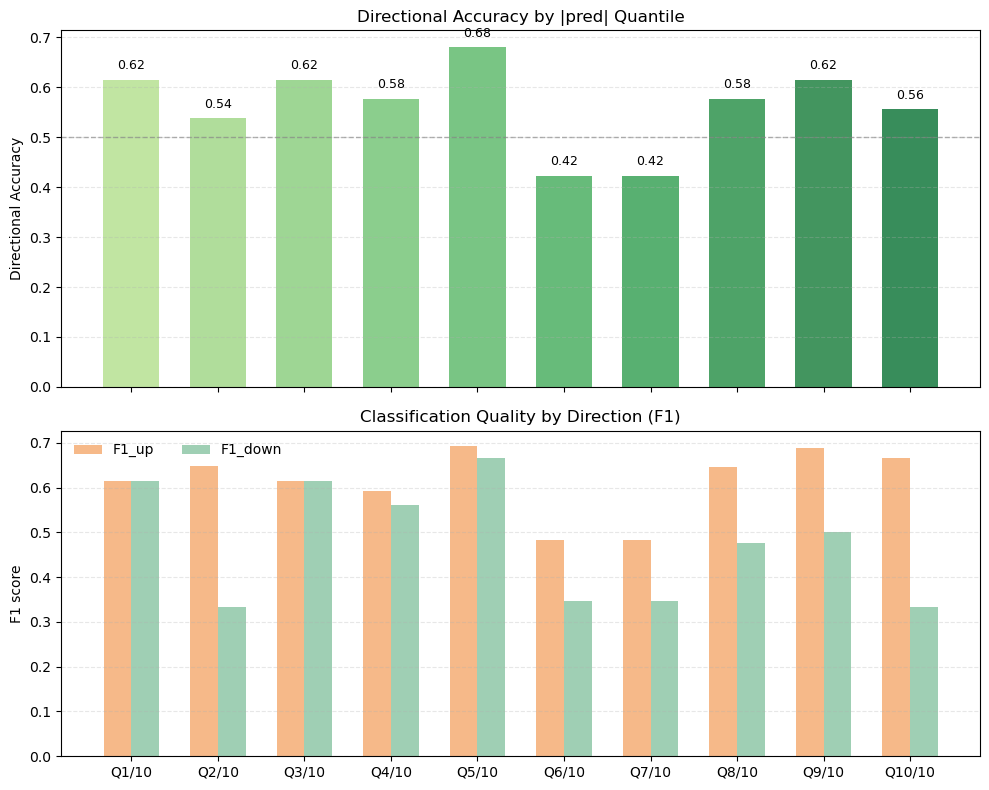

In [59]:
plot_pred_magnitude_diag(df['magnitude_table'])

Directional accuracy stays above 0.55 across most prediction and realized-return bins, with a clear improvement in the higher-magnitude buckets (|y| top deciles reaching ~0.65–0.69), which suggests the model is more reliable when the move is economically meaningful rather than noisy. The F1 split shows stronger performance on the “up” side in high-confidence bins, while downside detection is more mixed, which is typical for trend-biased constructions. The economic directional consistency increases monotonically toward large moves, indicating that profits are primarily generated during stronger trends rather than frequent small fluctuations. This pattern aligns with a slower, regime-conditioned trend signal rather than a fast reactive one, and is acceptable given the expert’s intended role in the ensemble.

方向准确率在大多数预测分位和真实收益分组中维持在 0.55 以上，并且在高波动 / 大幅度收益区间（|y| 高分位达到约 0.65–0.69）明显提升，说明模型主要在具有经济意义的趋势行情中发挥作用。F1 指标显示高置信区间内对上涨方向的刻画更稳定，而下行识别相对偏弱，这与趋势导向模型的常见行为一致。经济一致性指标在大收益区间呈现单调上升，表明收益主要来自趋势阶段而非频繁的小波动。这一表现更像是偏慢、具备状态约束的趋势信号，而非快速反应型模型，作为组合中的趋势专家是合理且可接受的。

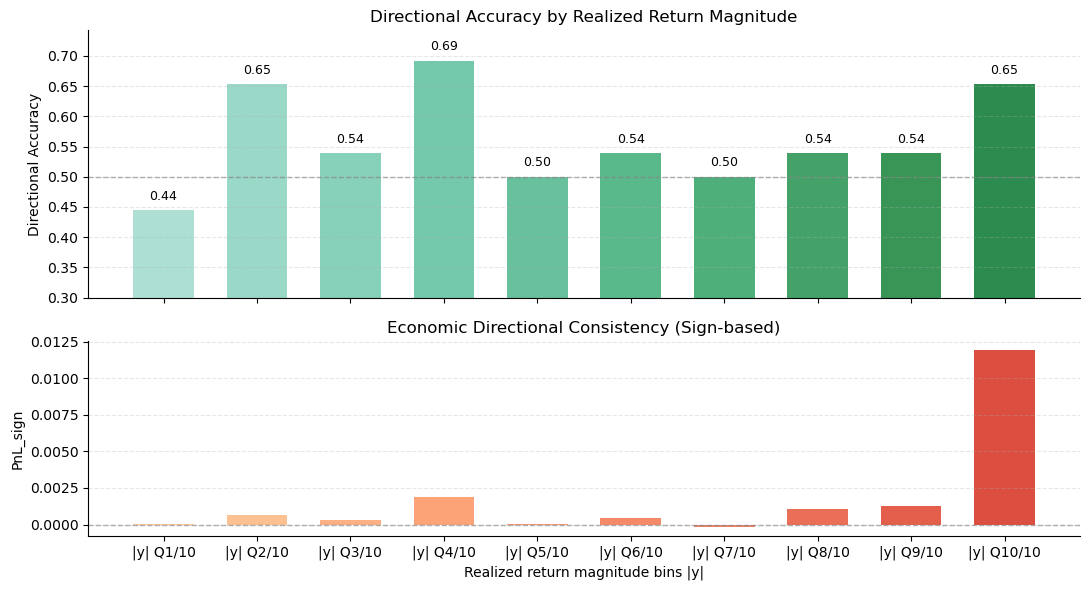

In [60]:
plot_true_magnitude_diag(df['true_mag_table'])

Despite only moderate directional accuracy (≈0.56) and IC around 0.10, the strategy delivers strong risk-adjusted performance (net Sharpe ≈1.6, max drawdown <10%) with a market correlation close to zero (-0.02). That combination indicates the signal is extracting structured returns rather than riding the market trend. The near-zero to slightly negative correlation suggests the expert is transitioning toward an anti-trend or conditional-trend profile, where profits come from timing and regime control instead of beta exposure. From an ensemble perspective, this is a desirable building block rather than a weakness.

尽管方向准确率（≈0.56）和 IC（≈0.10）并不极端，但策略在风险调整后表现突出（净 Sharpe 约 1.6，最大回撤低于 10%），且与市场的相关性接近于零（-0.02）。这说明收益主要来源于结构性信号，而非简单跟随市场趋势。接近零甚至略为负的相关性表明该专家正在向“反趋势 / 条件趋势”形态演化，其价值在于择时与状态控制，而不是承担 beta。作为组合中的一个专家，这种特性是加分项。

Sign of Ensemble only
=== Backtest summary ===
Sample size        : 260 obs
Directional Acc.   : 0.562
IC (Spearman)      : 0.094
IC (Pearson)       : 0.115
Trade days         : 83
Total turnover     : 165.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 43.86%
  Ann. vol         : 21.88%
  Sharpe           : 2.00
  Sortino          : 3.64
  Max drawdown     : -8.84%

Strategy (net after fees):
  Ann. return      : 35.86%
  Ann. vol         : 21.94%
  Sharpe           : 1.63
  Sortino          : 2.95
  Max drawdown     : -9.83%

Buy & Hold:
  Ann. return      : 24.21%
  Ann. vol         : 22.00%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


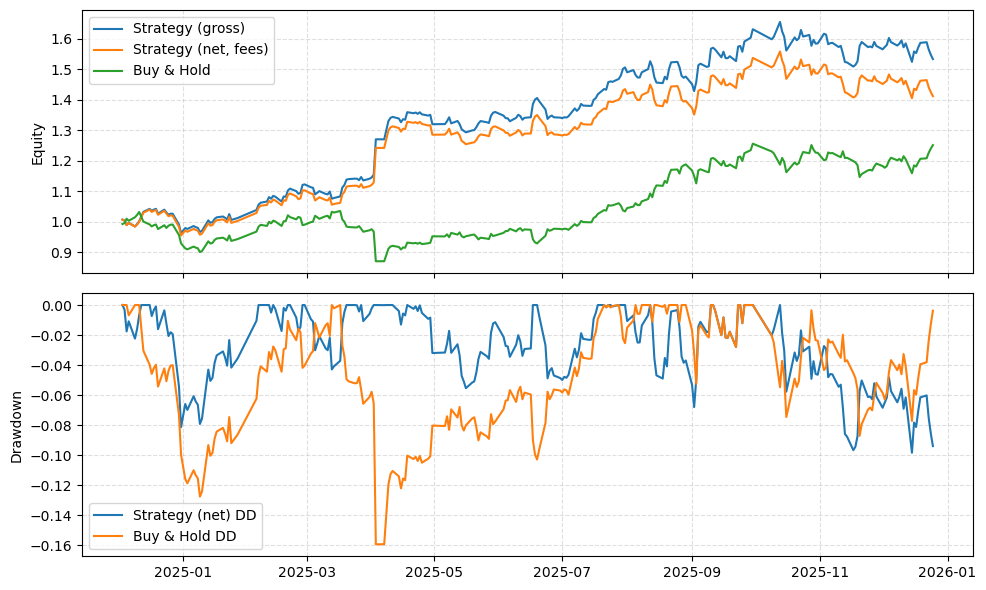

In [61]:
model02 = CTAStrategyEngine(tree = trend, ticker = 'ic_main', cls = treemodel_factors_augment, strategy = 'raw_ensemble')
model02.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'],light = False, mask = True, roll_encode = True, augmentor = IC_Augment)
model02.prep(feature_list = trend.artifacts['feature_cols'])
model02.compute()
q = model02.generate(naive_backtest = True)

In [62]:
corr_analysis(q)

Corr(strat, market): -0.020037038739409763


**Anti - Trend**

Despite being conceptually appealing, anti-trend strategies are inherently more difficult to model and interpret. Their effectiveness is often highly conditional on market regime, volatility state, and microstructure dynamics, which makes the resulting signals less stable and harder to attribute to a single economic mechanism. As a result, anti-trend models tend to offer fewer direct insights than trend-following or momentum-based approaches and require more careful validation and risk control. Based on earlier results showing that a combination of trend and regression-based features can induce anti-trend behavior, we construct the model by retaining trend signals while introducing several risk- and regime-related components. Specifically, cycle, regression, and volatility features are used to interrupt trend continuation, while time features are included to encode temporal awareness and structural effects. This design allows the model to preserve directional information while selectively suppressing trend exposure under unfavorable conditions.

尽管反趋势的思想在逻辑上较为理想，但其建模难度和可解释性明显高于顺趋势策略。反趋势信号通常对市场状态、波动环境以及微观结构高度敏感，表现具有较强的条件依赖性，难以归因于单一清晰的经济机制。因此，相比趋势或动量类模型，反趋势模型往往提供的直观解释较少，也更依赖于严格的验证与风险控制。 基于此前结果表明，趋势因子与回归类特征的组合往往会诱导出反趋势行为，我们在模型中保留趋势信号的同时，引入多类风险与状态相关因子。其中，周期、回归与波动率特征用于对趋势延续形成干扰，而时间特征用于刻画时间感知与结构性效应。该设计在保留方向信息的同时，使模型能够在不利环境下有选择地削弱趋势敞口。

Total runtime: 1.00 minutes


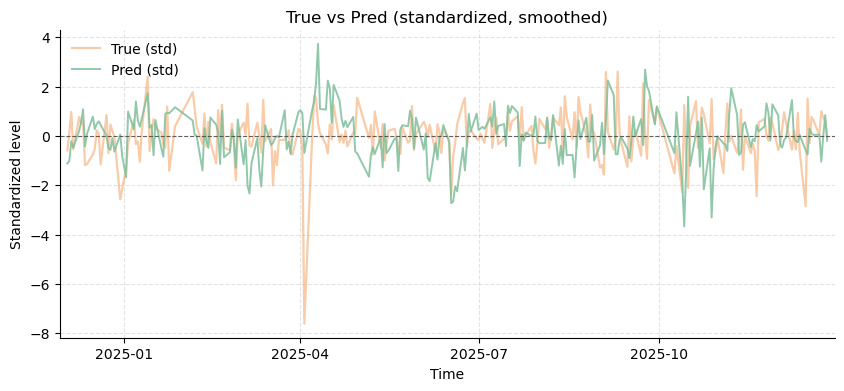

In [63]:
start = time.time()
cfg = Light_Config()
reverse  = LGBM_Classic(ticker="ic_main", cls= treemodel_factors_augment, verbose= False, tune_cfg=cfg, random_mode = False)
reverse.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'], light = False, mask = True, roll_encode = True, augmentor = IC_Augment)
reverse.prep( list_augmentation(family=('trend','cycle', 'time', 'reg', 'vol'), to_add = ['is_near_roll', 'post_roll_vol_decay'], augment=False, verbose=False,)[0])
reverse.split()               
reverse.tune_level1()
reverse.tune_level2()
reverse.tune_level3()
df = reverse.diag(bins = 10)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

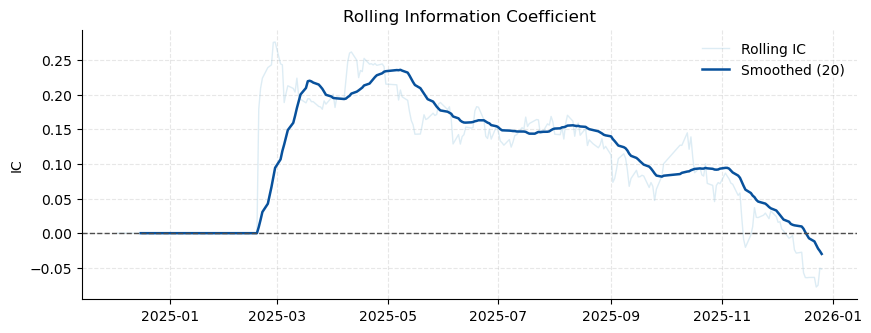

In [64]:
plot_rolling_ic(df['rolling_ic_series'])

In [65]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.10474036259518295,
 'roll_ic_median': 0.12707172814108333,
 'roll_ic_q25': 0.0,
 'roll_ic_q75': 0.170971021113242,
 'roll_ic_frac_pos': 0.7432950191570882,
 'roll_ic_vol': 0.08760604106482733,
 'roll_ic_mdd': -0.3537433329853433,
 'roll_ic_acf1': 0.9810489361267564,
 'roll_ic_half_life': 36.22795548801446}

The rolling IC statistics of the anti-trend component exhibit a clearly positive central tendency, with a mean IC of approximately 0.105, a median of 0.127, and nearly 74% of rolling windows showing positive IC. This indicates that the signal contains statistically meaningful directional information rather than pure noise. However, the IC distribution is highly asymmetric, with a lower quartile at zero and a substantially higher upper quartile, suggesting that the signal is active only in specific market regimes rather than continuously.

At the same time, IC volatility and drawdown are non-negligible, which explains the relatively weaker standalone performance of the anti-trend model under uniform aggregation. Most notably, the IC series exhibits extremely strong persistence, with a first-order autocorrelation close to 0.98 and an estimated half-life of approximately 36 windows. This behavior indicates pronounced regime dependence: once the anti-trend signal becomes effective (or ineffective), its state tends to persist. As a result, the anti-trend component is ill-suited for naive voting schemes, but remains a viable candidate for conditional activation or risk-adjusted weighting within an expert-based ensemble.

反趋势模型的滚动 IC 统计呈现出明显为正的中心特征，其平均 IC 约为 0.105，中位数约为 0.127，且约 74% 的滚动窗口 IC 为正，表明该信号并非随机噪声，而是具备统计意义上的方向性信息。然而，其 IC 分布具有显著的不对称性：下四分位数为 0，而上四分位数明显更高，说明该信号并非持续生效，而是仅在特定市场状态下发挥作用。

与此同时，IC 的波动率与回撤幅度并不低，这也解释了反趋势模型在单独使用或等权聚合时表现相对不稳定的原因。尤为重要的是，该 IC 序列表现出极强的持续性，其一阶自相关接近 0.98，对应的半衰期约为 36 个窗口。这一特征表明反趋势信号具有显著的状态依赖性：一旦进入有效或失效阶段，其状态往往会持续一段时间。因此，反趋势模型并不适合直接纳入简单投票机制，但在具备条件触发或风险调整加权的专家集成框架下，仍然具备潜在的应用价值。

In [66]:
df['lag_ic']

{-10: 0.05201290077784102,
 -9: -0.04325030013580161,
 -8: -0.10365897938646998,
 -7: 0.08637837382626636,
 -6: -0.09498103867531264,
 -5: -0.00555118448157473,
 -4: -0.06529527870780924,
 -3: -0.16025559279563442,
 -2: 0.040277384463430974,
 -1: 0.03539355953149056,
 0: 0.0789944722295341,
 1: -0.004753370270611649,
 2: 0.05635753310171914,
 3: 0.05832802566129866,
 4: 0.029956989186498955,
 5: 0.0036149576562142364,
 6: 0.11717592056507643,
 7: -0.004036783242131934,
 8: -0.032912881937188686,
 9: -0.006112947044871521,
 10: 0.01981331815594764}

In [67]:
df['residuals']['summary']['ljungbox_p']

{1: 0.9058952921529202,
 5: 0.7716163393609697,
 10: 0.7513780828313174,
 20: 0.26978823801540347}

The lagged IC profile does not exhibit a sharp peak at zero lag, with IC values fluctuating in both sign and magnitude across nearby leads and lags. This indicates that the signal is highly sensitive to timing and alignment, and that misalignment can readily invert its directional effect. Positive IC re-emerges at medium positive lags, suggesting that the signal’s predictive content may materialize with delay rather than immediately. The Ljung–Box p-values remain comfortably above conventional significance levels across all tested lags, indicating no statistically significant residual autocorrelation and suggesting that the residuals are consistent with white noise.

从滞后 IC 分布来看，该信号在零滞后处并未呈现出明显峰值，IC 在相邻滞后区间内正负交替、波动较大，表明其对时间对齐高度敏感，且在错位情况下容易出现方向翻转。与此同时，在中等正向滞后（如 +6）处 IC 再次转为较为显著的正值，说明该信号的预测作用可能并非即时体现，而是存在一定延迟。 Ljung–Box 检验在各个滞后阶数下的 p 值均显著高于常用显著性水平，未发现残差存在统计显著的自相关性，说明残差行为整体上接近白噪声。

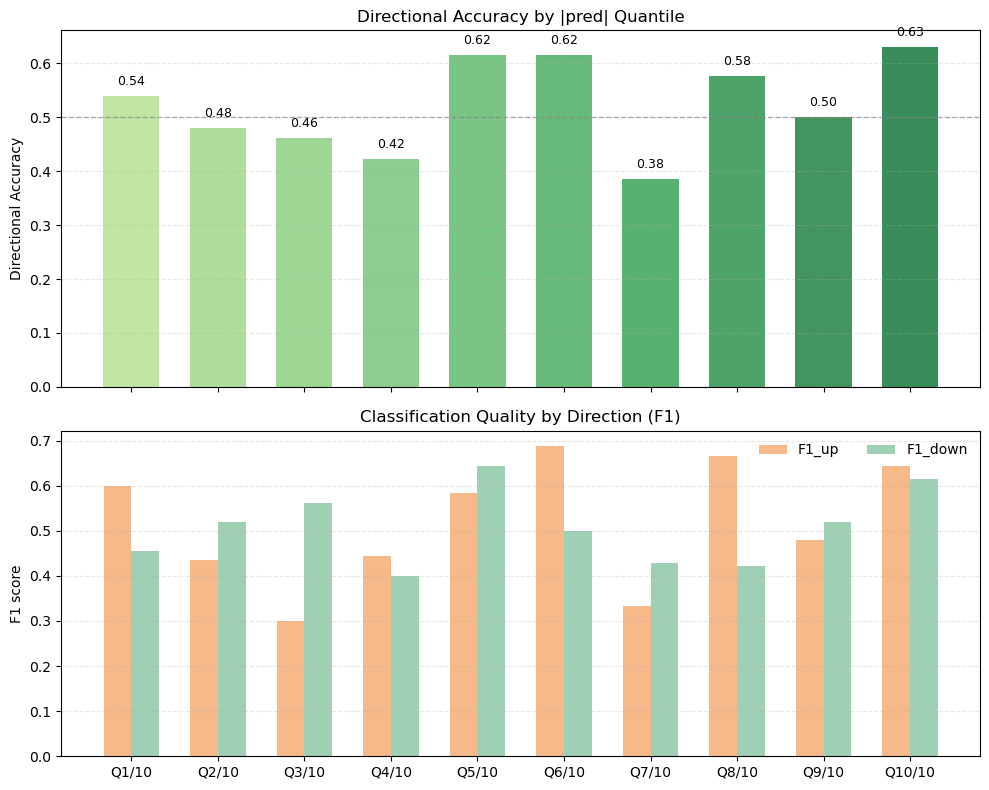

In [68]:
plot_pred_magnitude_diag(df['magnitude_table'])

The diagnostic results indicate that the signal exhibits strong conditional behavior rather than uniform predictive power. Directional accuracy improves markedly in the higher |pred| quantiles, reaching above 0.6 in the most confident bins, while remaining close to random in low-confidence regions. This suggests that the signal is informative primarily when its internal confidence is high.

Classification quality, as measured by F1 scores, remains reasonably balanced across directions, indicating that the model does not rely on a trivial directional bias. Moreover, directional accuracy increases with realized return magnitude, and economic consistency becomes clearly positive in the largest-move bins. These patterns imply that the signal is economically selective, contributing value mainly during large and meaningful market moves. Overall, the evidence supports interpreting this component as a regime-dependent, confidence-aware expert rather than a uniformly active predictor.

相关诊断结果表明，该信号并不具备均匀的预测能力，而是呈现出显著的条件性特征。随着 |pred| 分位数的上升，方向准确率明显改善，在高置信度区间可达到 0.6 以上，而在低置信度区间则接近随机水平，说明该信号仅在自身置信度较高时才具备有效信息量。

从 F1 指标来看，多空方向的分类质量整体较为平衡，并不存在明显的方向性偏置。同时，方向准确率随实际收益幅度增加而提升，且在大幅波动区间内的经济方向一致性显著为正。这表明该信号的经济价值主要集中于少数但重要的市场阶段，而非频繁的小幅波动。综合来看，该模型更适合作为一个具有状态依赖性的、基于置信度激活的专家组件，而非持续生效的通用预测器。

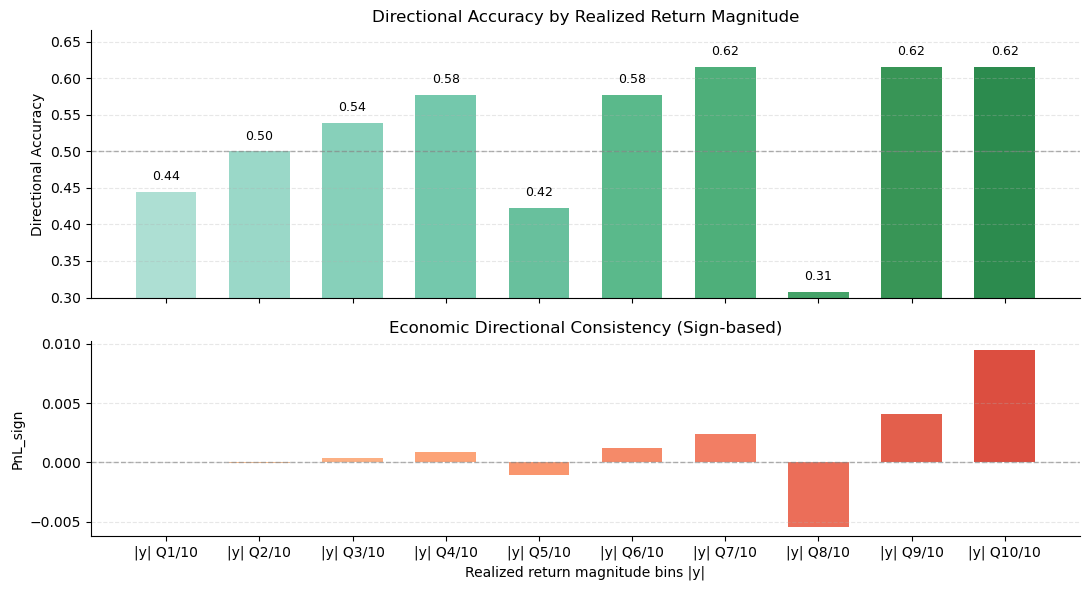

In [69]:
plot_true_magnitude_diag(df['true_mag_table'])

Based on the naïve backtest results (see prior disclaimer), the strategy achieves a directional accuracy of 0.523 with a modest yet positive IC (Spearman ≈ 0.068), indicating the presence of statistically meaningful directional information despite its deliberately constrained design. Gross performance reaches an annualized return of approximately 29.5% with a Sharpe ratio of 1.34 (before fees), outperforming buy-and-hold on a gross basis. After accounting for transaction costs, performance declines to a net Sharpe of 0.92. While this reduction reflects the impact of turnover and execution frictions inherent to the setup, the resulting risk-adjusted performance remains within a competitive range.

The equity curve exhibits relatively steady appreciation with intermittent drawdowns, and the drawdown profile suggests improved downside control relative to buy-and-hold over most of the sample period. In addition, the observed negative correlation with the market (approximately −0.27) is consistent with the intended anti-trend orientation of the model, indicating partial diversification benefits rather than pure directional exposure.

It is important to emphasize that this configuration relies on sign-based ensemble output and intentionally avoids further structural or objective-level optimization. In particular, although directly optimizing the loss function with respect to IC (i.e., using IC as the evaluation metric) can, in practice, lead to higher Sharpe ratios and stronger overall performance—and this has been verified in separate experiments—we deliberately refrain from doing so here. This choice is motivated by methodological consistency: adopting an IC-optimized objective would diverge from the training setup applied to other expert models within the framework, thereby complicating cross-model comparison and interpretation. Readers may assess this trade-off independently if desired.

Overall, these results should be interpreted as evidence of feasibility rather than optimality. The ability of a simplified anti-trend model to deliver stable and economically interpretable improvements—even under conservative design choices—suggests that the approach remains viable, while leaving room for further refinement within a unified expert-model training regime.

基于上述 naïve backtest 结果（具体说明见前文免责声明），该策略的方向准确率为 0.523，Spearman IC 约为 0.068。尽管模型结构刻意受限，结果仍表明信号中包含具有统计意义的方向性信息。在不考虑交易成本的情况下，策略年化收益约为 29.5%，Sharpe 比率为 1.34，整体表现优于买入并持有；在计入交易成本后，净 Sharpe 降至 0.92。该回落反映了当前设定下换手率与执行成本对收益的影响，但在风险调整后层面，其表现仍处于相对可接受的区间。

从净值曲线来看，策略整体呈现出较为平稳的上行趋势，并伴随阶段性回撤；相较于买入并持有，其在大多数样本区间内表现出更好的下行控制能力。此外，策略与市场收益之间的相关系数约为 −0.27，与其反趋势设计初衷相一致，体现出一定的分散化特征，而非单纯的方向性暴露。

需要强调的是，该配置采用的是基于方向（sign）的集成输出，并有意避免在结构层面或目标函数层面进行进一步优化。尽管在实际操作中，直接以 IC 作为优化目标（即将 loss / evaluation metric 设为 IC）通常可以带来更高的 Sharpe 比率和更优的整体表现，且相关结果已在其他实验中得到验证，但在此我们选择不采用该设定。这一取舍主要出于方法一致性的考虑：引入 IC 优化将使其训练目标与框架中其他专家模型产生偏离，从而增加横向比较与结果解释的复杂性。相关权衡可由读者自行评估。

总体而言，上述结果应被视为对方法可行性的验证，而非对性能上界的刻画。即便在较为保守的设计约束下，简化的反趋势模型仍能够实现稳定且具有经济解释意义的改进，表明该方法在统一的专家模型训练框架内仍具备进一步深化与优化的空间。

Sign of Ensemble only
=== Backtest summary ===
Sample size        : 260 obs
Directional Acc.   : 0.523
IC (Spearman)      : 0.068
IC (Pearson)       : 0.088
Trade days         : 96
Total turnover     : 191.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 29.50%
  Ann. vol         : 21.97%
  Sharpe           : 1.34
  Sortino          : 2.40
  Max drawdown     : -11.32%

Strategy (net after fees):
  Ann. return      : 20.24%
  Ann. vol         : 21.98%
  Sharpe           : 0.92
  Sortino          : 1.64
  Max drawdown     : -13.08%

Buy & Hold:
  Ann. return      : 24.21%
  Ann. vol         : 22.00%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


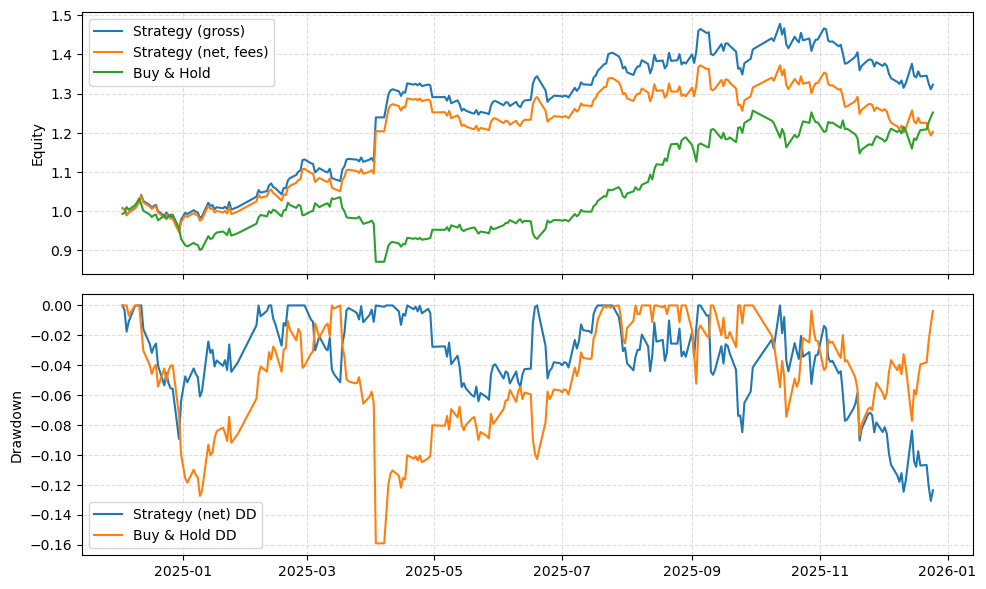

In [70]:
model03 = CTAStrategyEngine(tree = reverse, ticker = 'ic_main', cls = treemodel_factors_augment, strategy = 'raw_ensemble')
model03.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'],light = False, mask = True, roll_encode = True, augmentor = IC_Augment)
model03.prep(feature_list = reverse.artifacts['feature_cols'])
model03.compute()
q = model03.generate(naive_backtest = True)

In [71]:
corr_analysis(q)

Corr(strat, market): -0.26682927176480903


#### **Votings**

**Two Expert Model**

In [72]:
from meta_signal import collect_engine_signals, sign_consensus, sharpe_strategy, append_signal_to_file
from cta_confidence import backtest

Under these expert boosting settings, the model no longer relies on a highly correlated ensemble structure. Compared with the previous notebook, this setup is expected to introduce a degree of differentiation in model behavior and outputs, potentially leading to distinct performance characteristics. Building on this, we begin with a simple voting scheme and gradually introduce Sharpe-weighted aggregation to examine how changes in the ensemble structure affect overall performance.

在这样的 expert boosting 设置 下，我们的模型不再依赖于高度相关的集成结构。相较于上一份 notebook，该设定在模型行为与输出特征上可能呈现出一定程度的差异性，从而带来不同的表现侧重。在此基础上，我们仍从简易的 voting 机制入手，并逐步引入基于 Sharpe 的加权方式，以观察集成结构变化对整体表现的影响。

In [73]:
engines = [model01, model02]

The correlation between engine_0 (short-horizon momentum) and engine_1 (structural trend) is approximately 0.64, indicating a moderate but non-trivial degree of dependence. This suggests that while the two engines share certain directional information—likely arising from common market regimes or broad price movements—they are not redundant. The residual decorrelation reflects differences in time horizon, signal construction, and underlying structural assumptions. Consequently, the pair is expected to retain meaningful diversification potential when combined within an ensemble framework.

engine_0（短周期动量）与 engine_1（结构性趋势）之间的相关系数约为 0.64，表明二者存在中等但并非微不足道的相关性。这意味着两种引擎在部分市场阶段可能共享方向性信息，通常源于相同的市场环境或整体价格走势；但二者并不构成冗余。剩余的去相关性主要来自于时间尺度、信号构建方式及结构性假设的差异。因此，在集成框架下同时使用这两个引擎，仍有望保留具有实际意义的分散化空间。

In [74]:
P, y = collect_engine_signals(engines)
P.corr()

engine_0  engine_1
engine_0  1.000000  0.637092
engine_1  0.637092  1.000000

In [75]:
signal, confidence = sign_consensus(P)
meta_df = pd.DataFrame({"y": y, "signal": signal, "confidence": confidence, "pred": P.mean(axis=1), } ,index=P.index)

The two-expert meta sign consensus exhibits a clear improvement in both return and risk-adjusted performance. The strategy achieves a net Sharpe of approximately 1.98 with lower volatility and substantially reduced maximum drawdown relative to buy-and-hold, indicating more efficient risk control. Compared with the strongest bagging ensemble constructed previously—based on three highly correlated models and achieving a Sharpe of around 1.71—this expert-based consensus delivers materially stronger performance, suggesting that combining complementary signal structures is more effective than aggregating correlated learners via simple voting.

该 双专家（2-expert）符号共识模型 在收益与风险调整后表现上均展现出明显提升。策略净 Sharpe 约为 1.98，同时波动率更低、最大回撤显著小于买入并持有，体现出更优的风险控制能力。相较于此前构建的最佳 bagging 投票集成（由三个高度相关模型组成，Sharpe 约 1.71），该 expert 共识方案在整体表现上更为突出，表明在结构互补的信号之间建立共识，相比对高度相关模型进行简单聚合，更有助于提升组合效率。

=== Backtest summary ===
Name: Meta Sign Consensus (2 Expert)
Sample size        : 261 obs
Directional Acc.   : 0.595
IC (Spearman)      : 0.143
IC (Pearson)       : 0.135
Trade days         : 129
Total turnover     : 164.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 41.86%
  Ann. vol         : 17.09%
  Sharpe           : 2.45
  Sortino          : 3.56
  Max drawdown     : -6.75%

Strategy (net after fees):
  Ann. return      : 33.94%
  Ann. vol         : 17.15%
  Sharpe           : 1.98
  Sortino          : 2.93
  Max drawdown     : -7.47%

Buy & Hold:
  Ann. return      : 24.12%
  Ann. vol         : 21.96%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


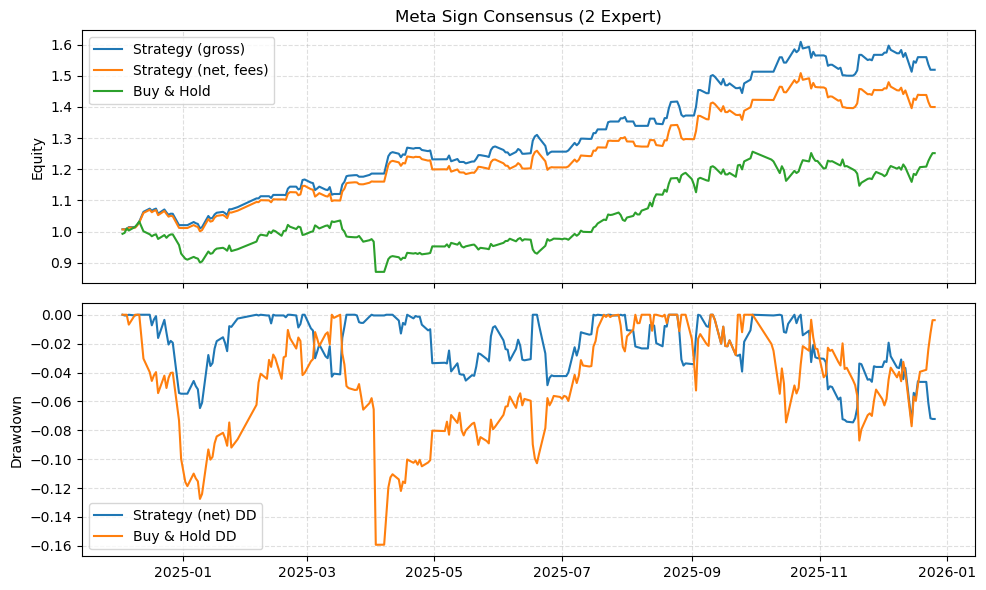

In [76]:
stats = backtest(meta_df,col_ret="y", col_signal="signal", cutoff_dt=model01.cutoff_dt,title="Meta Sign Consensus (2 Expert)")

It is worth noting that while the two-expert meta sign consensus delivers materially stronger performance than the best bagging ensemble constructed previously, its Sharpe ratio remains slightly below that of the strongest standalone LightGBM models. This behavior reflects an inherent trade-off in the consensus design: by combining a short-horizon momentum expert with a structural trend expert, the model prioritizes stability, diversification, and drawdown control over the aggressive exploitation of a single dominant signal. As a result, periods of strong alignment with one expert are partially diluted, leading to a modest reduction in peak Sharpe but improved robustness across market regimes.

需要指出的是，尽管双专家符号共识模型相较于此前构建的最佳 bagging 投票集成展现出更为显著的性能提升，其 Sharpe 比率仍略低于表现最优的单一 LightGBM 模型。这一现象反映了共识设计中的内在权衡：通过结合短周期动量专家与结构性趋势专家，模型更加侧重于稳定性、分散化与回撤控制，而非对单一强势信号的激进利用。因此，在某些专家高度占优的阶段，信号强度会被部分稀释，从而带来峰值 Sharpe 的小幅下降，但同时换取了跨不同市场环境下更稳健的整体表现。

**Three Expert Sharpe**

The reason we have not included the anti-trend model in the voting ensemble earlier is that its standalone performance is relatively weaker, and its underlying behavior differs fundamentally from trend- and momentum-based signals, which may introduce conflicts within a simple voting scheme. However, under a Sharpe-weighted aggregation framework, the anti-trend component may still provide incremental value by contributing diversification benefits rather than directional consensus. On this basis, it is reasonable to evaluate its role within a weighted ensemble setting.

此前未将反趋势模型纳入投票型集成，主要原因在于其单独表现相对较弱，且其信号机理与趋势及动量模型在本质上存在差异，在简单投票框架下容易引发信号冲突。然而，在基于 Sharpe 的加权集成中，反趋势模型仍可能通过提供分散化效应而产生增量价值，而非依赖方向一致性。因此，有必要在加权集成框架下进一步评估其作用。

In [77]:
engines_new = [model01, model02, model03]
P, y = collect_engine_signals(engines_new)
P.corr()

engine_0  engine_1  engine_2
engine_0  1.000000  0.637092  0.468266
engine_1  0.637092  1.000000  0.706781
engine_2  0.468266  0.706781  1.000000

The correlation structure indicates that engine_2 (anti-trend) is neither independent nor redundant relative to the trend-based engines. While its correlation with short-horizon momentum (engine_0, ≈0.47) is moderate, it exhibits higher alignment with the structural trend component (engine_1, ≈0.71), suggesting shared sensitivity to broader regime dynamics despite opposing directional logic.

相关性结构表明，engine_2（反趋势）相对于趋势类引擎既非独立，也不构成冗余。其与短周期动量引擎（engine_0，约 0.47）的相关性相对较低，而与结构性趋势引擎（engine_1，约 0.71）的相关性更高，说明二者在宏观或制度性行情阶段上可能存在一定共性，尽管方向逻辑相反。

=== Backtest summary ===
Name: Meta ensemble (Sharpe)
Sample size        : 261 obs
Directional Acc.   : 0.553
IC (Spearman)      : 0.115
IC (Pearson)       : 0.137
Trade days         : 87
Total turnover     : 173.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 49.38%
  Ann. vol         : 21.69%
  Sharpe           : 2.28
  Sortino          : 4.15
  Max drawdown     : -11.93%

Strategy (net after fees):
  Ann. return      : 41.03%
  Ann. vol         : 21.70%
  Sharpe           : 1.89
  Sortino          : 3.39
  Max drawdown     : -13.77%

Buy & Hold:
  Ann. return      : 24.12%
  Ann. vol         : 21.96%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


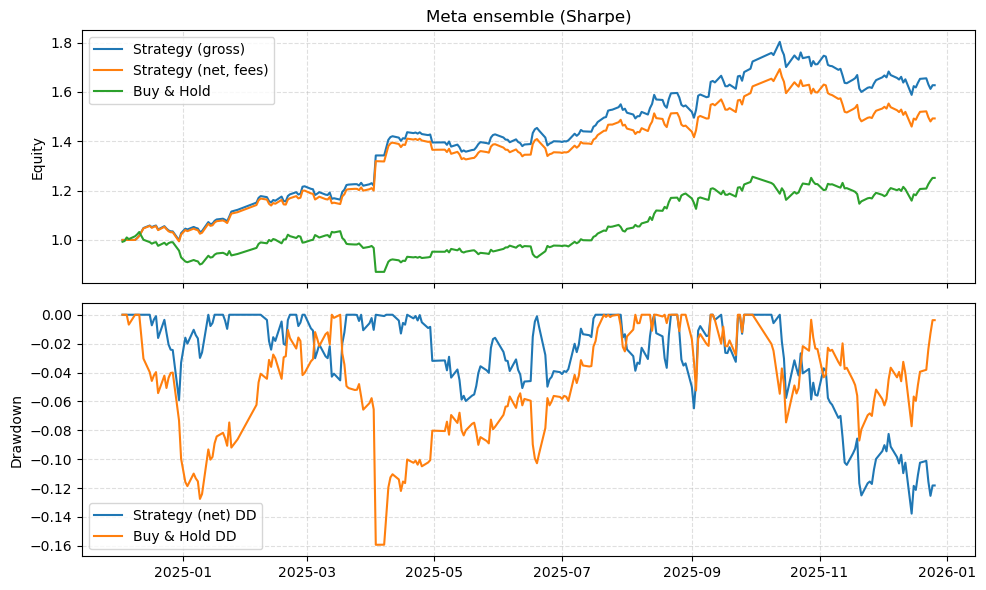

In [78]:
meta_df = sharpe_strategy(P,y,test_start_dt= model01.cutoff_dt,test_end_dt= None, sharpe_win = 120, use_vol_norm = True)
stats = backtest(meta_df['strategy'], col_ret="y", col_signal="signal", cutoff_dt= model01.cutoff_dt, title="Meta ensemble (Sharpe)",)

| Model / Ensemble                            | Experts | Net Ann. Return | Net Vol | Net Sharpe | Max Drawdown |
| ------------------------------------------- | ------- | --------------- | ------- | ---------- | ------------ |
| **2-Expert Sign Voting (Trend + Momentum)** | 2       | 35.86%          | 21.94%  | **1.98**   | −9.83%       |
| **Sharpe-Weighted Meta Ensemble**           | 3       | 41.03%          | 21.70%  | **1.89**   | −13.77%      |
| Expert 2 (Sign only, Structual Trend)                        | 1       | 35.86%          | 21.94%  | 1.63       | −9.83%       |
| Expert 1 (Sign only, Fast Momentum)                        | 1       | 30.53%          | 21.95%  | 1.39       | −10.77%      |
| Expert 3 (Sign only, Anti-trend)            | 1       | 20.24%          | 21.98%  | 0.92       | −13.08%      |
| Buy & Hold                                  | —       | 24.12%          | 21.96%  | 1.10       | −15.93%      |


From the table above, the Sharpe-weighted meta ensemble achieves the highest net return among all configurations, while clearly outperforming each individual expert in risk-adjusted terms. However, the highest Sharpe ratio and shallowest drawdown are still attained by the two-expert sign-based voting ensemble, which benefits from a more complementary pairing of trend and momentum signals with limited structural conflict.

The inclusion of an additional anti-trend expert in the Sharpe-weighted ensemble improves diversification and raises total return, but also introduces directional disagreement that moderates peak risk-adjusted performance and deepens drawdowns relative to the two-expert case. These results highlight a fundamental trade-off in ensemble design: broader expert coverage favors return potential and robustness, whereas carefully selected, structurally aligned experts maximize Sharpe efficiency under simple aggregation.

从上述表格可以看出，基于 Sharpe 加权的三专家 meta 集成在净收益率水平上达到最高，并在风险调整后表现上显著优于所有单一专家模型。然而，最高 Sharpe 比率与最浅回撤仍由双专家符号投票集成实现，该组合受益于趋势与动量信号之间更为清晰的结构互补性，且方向冲突较少。

在 Sharpe 加权框架下引入反趋势专家提升了整体分散化程度，并推动了收益上行，但同时也带来了方向性分歧，使得峰值风险调整后表现与回撤控制相较双专家方案有所下降。该结果清晰地反映了集成设计中的核心权衡：更广泛的专家覆盖有助于提升收益潜力与稳健性，而在简单聚合条件下，结构互补且冲突较少的专家组合更有利于实现 Sharpe 的最优表现。

#### **Randomized Augmentation**

As mentioned earlier, enabling random_mode = True introduces column-wise feature sampling within the boosting process, serving as a controlled source of stochasticity at the tree or split level rather than across independent learners. This mechanism is intended to reduce correlation by encouraging different boosted trees to condition on different subsets of features, thereby approximating a bagging-style diversification effect within a sequential learning framework. In this sense, random feature sampling functions primarily as a form of regularization, limiting over-reliance on specific feature combinations and smoothing the learning dynamics. It may also be viewed as an automatic form of boost augmentation, in which diversity is introduced implicitly through stochastic perturbations rather than explicitly designed expert structures. However, because all features remain accessible across the full boosting sequence, this approach does not enforce structurally distinct model behaviors or explicit expert specialization. Consequently, while randomized feature sampling can promote partial differentiation among boosted trees, it does not guarantee improved performance or robustness, and any observed gains should be interpreted as opportunistic rather than systematic.

如前所述，启用 random_mode = True 会在 Boosting 训练过程中引入特征列采样，该随机性作用于单棵树或分裂层面，而非独立学习器之间，从而作为一种受控的随机扰动来源。该机制旨在通过促使不同的 Boosted 树在构建过程中依赖不同的特征子集，降低序列学习过程中模型路径之间的相关性，在顺序学习框架内近似实现类似 bagging 的多样化效果。从这一角度看，随机特征采样本质上是一种正则化手段，用于限制模型对特定特征组合的过度依赖，并平滑整体学习过程。

同时，它也可以被视为一种自动化的 Boost 增强方式：模型多样性并非通过显式设计的专家结构引入，而是通过随机扰动在训练过程中隐式产生。然而，由于所有特征在完整的 Boosting 过程中始终是可访问的，这种方式并不会强制形成结构上彼此区分的模型行为，也无法实现明确的专家分工。因此，尽管随机特征采样可以在一定程度上促进 Boosted 树之间的差异化，其带来的性能提升并无必然性，相关结果更应被理解为机会性的改进，而非系统性保证。

In [79]:
np.random.seed(242)
seeds = np.random.randint(0, 100000, 5)
has_duplicate = len(seeds) != len(np.unique(seeds))
has_duplicate

False

In [80]:
start = time.time()
tree = train_bagged_tree_multi_seed(
    model_class= LGBM_Classic,
    config_class= Light_Config,
    seeds= seeds,
    ticker="ic_main",
    feature_cls=treemodel_factors_augment,
    loss="RMSE",
    random_mode=True,
    remove_columns=["Phase_Sin", "HT_DC_Period"],
    mask= True,
    light=False,)
end = time.time()
print(f"Total runtime: {(end - start)/60:.2f} minutes")

Total runtime: 5.09 minutes


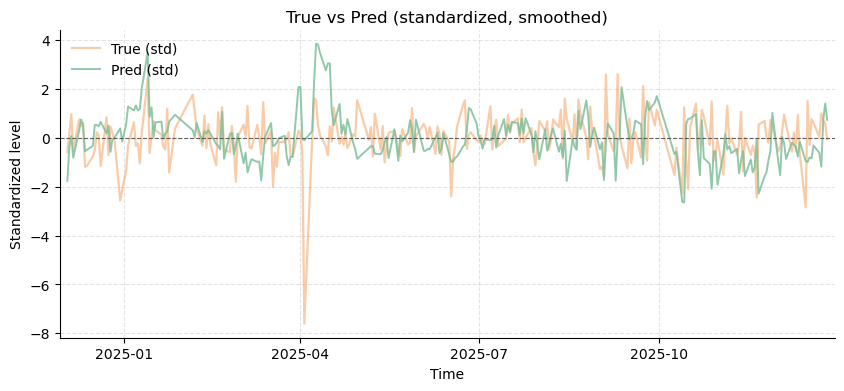

In [81]:
df = tree.diag(bins = 10)

(<Figure size 1000x350 with 1 Axes>,
 <Axes: title={'center': 'Rolling Information Coefficient'}, ylabel='IC'>)

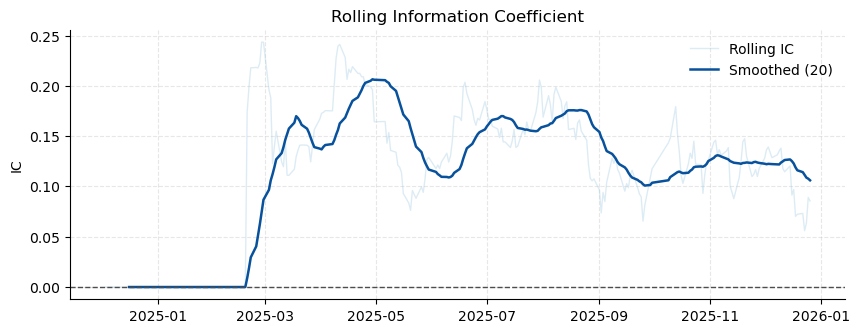

In [82]:
plot_rolling_ic(df['rolling_ic_series'])

In [83]:
df['rolling_ic_summary']

{'roll_ic_mean': 0.11625454210188729,
 'roll_ic_median': 0.12806073437655624,
 'roll_ic_q25': 0.09137941462586159,
 'roll_ic_q75': 0.16078352025197296,
 'roll_ic_frac_pos': 0.8122605363984674,
 'roll_ic_vol': 0.066584398821076,
 'roll_ic_mdd': -0.18758746197205028,
 'roll_ic_acf1': 0.9658257059902267,
 'roll_ic_half_life': 19.934124602614407}

Comparing the randomized and non-randomized configurations, the two exhibit broadly similar rolling IC characteristics, indicating that feature-level randomization does not fundamentally alter the nature of the learned signal. The non-randomized variant achieves a slightly higher mean and median rolling IC (≈ 0.130 vs. 0.116), suggesting marginally stronger average signal strength under this specific realization. However, this comes at the cost of higher IC volatility and longer persistence, as reflected by a larger rolling IC volatility (≈ 0.074 vs. 0.067), higher first-order autocorrelation, and a longer half-life.

In contrast, the randomized configuration displays lower IC volatility and a shorter half-life, indicating faster decay of signal persistence and reduced temporal clustering. This suggests that randomization primarily acts as a regularization mechanism, smoothing the learning dynamics and moderating regime anchoring, rather than improving peak signal strength. Importantly, both configurations share an identical fraction of positive rolling IC windows, implying that randomization affects stability and persistence more than directional consistency.

Overall, the comparison suggests a trade-off: non-randomized training delivers slightly stronger but more persistent and potentially regime-anchored signals, while randomized training yields a smoother, less persistent profile that may be more robust to local overfitting, without guaranteeing superior performance.

对比随机化与非随机化配置可以发现，两者在滚动 IC 的整体特征上高度相似，说明特征层面的随机化并未从根本上改变模型所学习到的信号结构。在当前实现下，非随机化版本的滚动 IC 均值与中位数略高（约 0.130 对 0.116），体现出略强的平均信号强度；但同时，其 IC 波动率更高、持续性更强，表现为更大的滚动 IC 波动、较高的一阶自相关系数以及更长的半衰期。

相比之下，随机化版本的 IC 波动率更低、半衰期更短，表明信号的时间聚集程度有所下降、衰减速度更快。这说明随机化更多起到的是一种正则化和平滑作用，用以缓解信号的状态锚定，而非提升峰值信号强度。值得注意的是，两种配置下滚动 IC 为正的比例完全一致，表明随机化主要影响的是稳定性与持续性，而非方向一致性。

综合来看，该结果反映了一种权衡关系：非随机化训练往往产生更强但更具状态依赖性的信号，而随机化训练则提供了更平滑、持续性更弱的信号形态，在一定程度上有助于降低局部过拟合风险，但并不保证性能上的绝对优势。

In [84]:
df['lag_ic']

{-10: 0.008987288939480174,
 -9: -0.13017157794569886,
 -8: -0.0803207405398436,
 -7: 0.03441536211135663,
 -6: -0.0473186371005095,
 -5: 0.044023947127489124,
 -4: 0.021327962401592616,
 -3: -0.04320823531754669,
 -2: 0.05921564293657316,
 -1: 0.07679676645193885,
 0: 0.11667982802491886,
 1: 0.06220005530350357,
 2: -0.02448871053522216,
 3: -0.006004103823305706,
 4: 0.037435808976563206,
 5: -0.020132610437170975,
 6: 0.07678685155164429,
 7: 0.03127600796006056,
 8: -0.08310843555622742,
 9: 0.03455254832355127,
 10: 0.009059381521532916}

In [85]:
df['residuals']['summary']['ljungbox_p']

{1: 0.9642827546032647,
 5: 0.8964513337619416,
 10: 0.7695382038185005,
 20: 0.2863454356258213}

The lagged IC profile shows that the strongest alignment occurs at lag 0 (IC ≈ 0.117), with small and mixed values at neighboring lags. While a few positive values appear at short positive lags (e.g., lag −1 and +1), their magnitudes are modest and do not form a clear monotonic decay or amplification pattern. Negative values at some negative lags suggest limited pre-alignment rather than systematic look-ahead or leakage.

The Ljung–Box test p-values remain comfortably high across multiple horizons (≈ 0.96 at lag 1, ≈ 0.90 at lag 5, ≈ 0.77 at lag 10, and ≈ 0.29 at lag 20), indicating no statistically significant residual autocorrelation. This suggests that, after conditioning on the model signal, remaining serial dependence is weak and does not violate basic independence assumptions.

从滞后 IC 分布可以看到，信号在 lag 0 处达到最大值（IC ≈ 0.117），相邻滞后期的 IC 值整体较小，正负交错，未呈现出清晰的单调衰减或放大结构。个别正滞后（如 −1、+1）存在一定正值，但幅度有限；部分负滞后出现负值，更像是有限样本下的弱对齐现象，而非系统性的前视或信息泄露。

Ljung–Box 检验在多个滞后阶数下的 p 值均处于较高水平（lag 1 约 0.96，lag 5 约 0.90，lag 10 约 0.77，lag 20 约 0.29），未拒绝“残差不存在显著自相关”的原假设。这表明在模型信号解释之后，剩余序列相关性较弱，不存在明显的结构性问题。

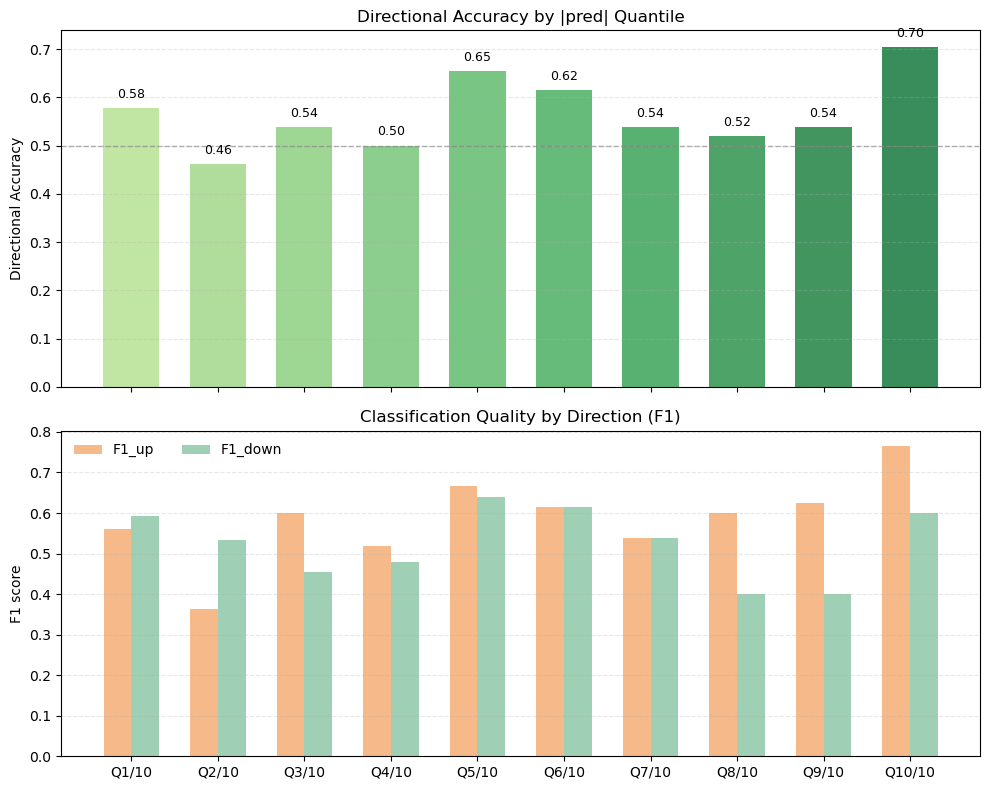

In [86]:
plot_pred_magnitude_diag(df['magnitude_table'])

Comparing the randomized and non-randomized configurations, both exhibit broadly similar patterns in prediction-quantile stratification, suggesting that feature-level randomization does not fundamentally change how the model ranks signals. In both cases, directional accuracy generally improves toward higher |pred| quantiles, indicating that the model retains a degree of confidence calibration: stronger predictions are, on average, more reliable.

That said, the non-randomized configuration shows a slightly clearer monotonic structure, particularly in the upper quantiles, where directional accuracy reaches marginally higher levels and remains more consistent. The randomized variant, by contrast, displays a somewhat noisier profile, with local fluctuations across mid-quantiles and less pronounced separation between adjacent bins. This is consistent with randomization acting as a smoothing or regularization mechanism, reducing sharp concentration of predictive power without introducing a new ranking structure.

The F1 breakdown by direction further supports this interpretation. While both configurations maintain reasonable balance between up and down predictions, the non-randomized model exhibits stronger asymmetry in certain quantiles, suggesting more decisive directional specialization. The randomized version appears more balanced but less sharp, again reflecting a trade-off between stability and peak discriminative strength.

Overall, these diagnostics indicate that randomization primarily moderates the expression of the signal rather than enhancing it. It can reduce over-concentration and smooth model behavior, but at the cost of slightly weaker quantile separation. As with earlier results, any benefit from randomization should be interpreted as conditional rather than systematic.

对比随机化与非随机化两种配置可以看到，两者在按预测分位分组的整体结构上较为相似，说明特征层面的随机化并未从根本上改变模型对信号的排序方式。在两种设定下，方向准确率均随着 |pred| 分位的上升而整体提高，表明模型仍具备一定的置信度校准能力，即预测幅度越大的样本，其方向判断相对更可靠。

不过，非随机化配置在高分位区间呈现出更为清晰、连续的单调结构，高分位下的方向准确率略高且稳定性更强；相比之下，随机化版本在中间分位存在一定起伏，相邻分位之间的区分度略弱。这与随机化作为一种正则化或平滑机制的作用一致：它抑制了预测能力在少数分位上的过度集中，但并未引入新的排序优势。

从方向 F1 的分解结果来看，两种配置在多数组间仍保持较为合理的上下方向平衡，但非随机化模型在部分分位上呈现出更明显的方向性偏置，体现出更强的判别强度；而随机化版本则整体更为均衡，但“锋芒”有所削弱。

综合来看，随机化更多是在调节信号的表达方式，而非提升其本身的区分能力。它有助于缓和模型行为、降低局部过拟合风险，但也可能削弱高置信度区间的判别力度，其效果更应被理解为条件性的稳定化手段，而非性能提升的保证。

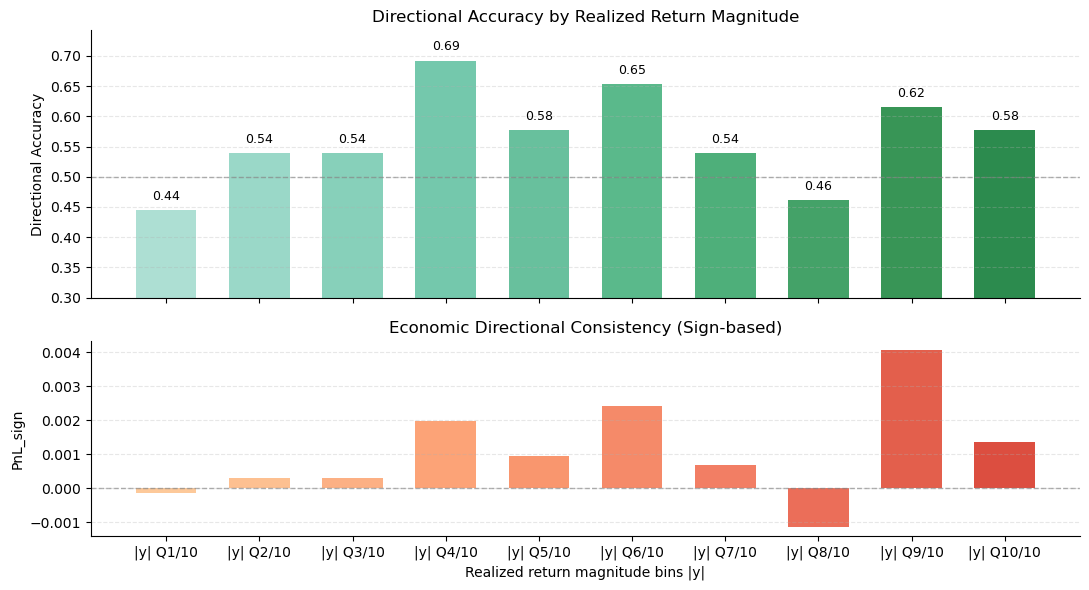

In [87]:
plot_true_magnitude_diag(df['true_mag_table'])

Under this configuration, both the return-magnitude–conditioned diagnostics and the overall backtest results indicate a clear weakening of the signal. Although directional accuracy in a few magnitude bins exceeds the random baseline, the overall structure remains fragmented and lacks stability, and the associated economic contribution is limited and not persistent. This suggests that the apparent “strength” observed in certain bins is more likely driven by random fluctuations rather than by a stable, reproducible ability to discriminate return magnitude.

These results highlight a clear trade-off. While randomization can help reduce overfitting by introducing noise and smoothing the learning process, it may also attenuate genuinely predictive structure and dilute tradable edge. In practice, this manifests as weaker magnitude selectivity and lower risk-adjusted performance, which cannot be effectively offset even by increasing ensemble size. Moreover, because the observed performance is sensitive to the choice of random seed, it is difficult to attribute any improvement to a stable structural mechanism rather than to incidental randomness.

By contrast, the expert-weighted framework introduced earlier achieves diversification through explicit and interpretable structural differences across models. This leads to more transparent model behavior and clearer economic interpretation, and is more readily validated across assets and sample regimes. Consequently, compared with approaches that rely primarily on stochastic feature sampling, expert-based weighted ensembles are more defensible both methodologically and economically.

在该设定下，无论是按收益幅度分组的诊断结果，还是整体回测表现，均显示出信号强度的明显削弱。尽管个别幅度区间的方向准确率高于随机水平，但整体结构较为零散、稳定性不足，对应的经济贡献也相对有限且缺乏持续性。这表明部分区间内的“亮点”更可能源于随机波动，而非模型具备稳定、可重复的幅度感知能力。

上述结果反映出一个清晰的权衡关系：随机化虽然通过引入噪声与平滑机制在一定程度上有助于降低过拟合风险，但同时也可能削弱模型中原本真实存在的预测结构，从而稀释可交易优势。在实际表现中，这通常体现为幅度选择能力下降以及风险调整后收益的减弱，即便通过扩大集成规模也难以有效弥补。此外，由于相关结果对随机种子较为敏感，很难将其合理归因于稳定的结构性改进，而更可能是偶然随机效应的体现。

相比之下，前文所采用的专家加权框架通过明确、可解释的结构差异来引入多样性，其模型行为与经济含义更为清晰，也更易于在不同资产与样本条件下进行验证。因此，与纯粹依赖随机特征采样的方式相比，基于专家结构的加权集成在方法论严谨性与经济解释层面均更具可辩护性

Sign of Ensemble only
=== Backtest summary ===
Sample size        : 260 obs
Directional Acc.   : 0.550
IC (Spearman)      : 0.084
IC (Pearson)       : 0.058
Trade days         : 76
Total turnover     : 151.00 (in units of |Δposition|)
Fee per turnover   : 0.0500%

Strategy (gross):
  Ann. return      : 22.00%
  Ann. vol         : 22.01%
  Sharpe           : 1.00
  Sortino          : 1.22
  Max drawdown     : -12.78%

Strategy (net after fees):
  Ann. return      : 14.68%
  Ann. vol         : 22.03%
  Sharpe           : 0.67
  Sortino          : 0.82
  Max drawdown     : -15.51%

Buy & Hold:
  Ann. return      : 24.21%
  Ann. vol         : 22.00%
  Sharpe           : 1.10
  Sortino          : 1.31
  Max drawdown     : -15.93%


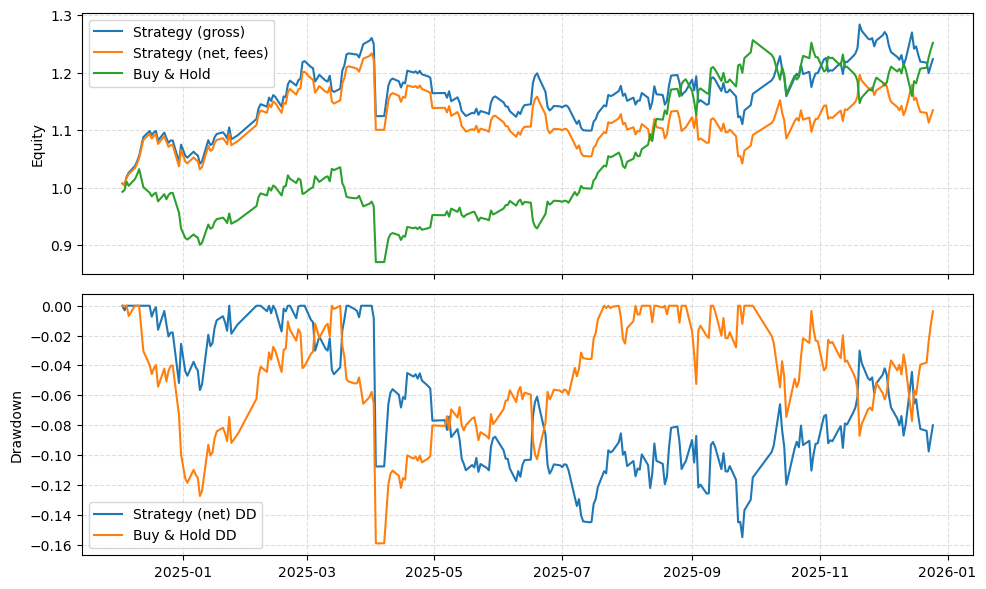

In [88]:
kimson = CTAStrategyEngine(tree , ticker = 'ic_main', cls = treemodel_factors_augment, strategy = 'raw_ensemble')
kimson.load(remove_columns = ['Phase_Sin', 'HT_DC_Period'],light = False, mask = True)
kimson.compute()
q = kimson.generate(naive_backtest = True)

An expanded ensemble with 100 estimators was also examined, yet it failed to deliver incremental gains over the baseline in terms of risk-adjusted performance, while incurring a significant increase in training time.

此外，我们还测试了由 100 个基模型组成的更大规模集成，但其整体表现并未相较基线模型取得实质性提升，同时计算开销却显著增加。

#### **Conclusion and Disclaimer**

Overall, at least within the CSI 500 universe considered here—and without any claim of generalization—boosting emerges as a more complex yet potentially more powerful tool than bagging. Its sequential learning structure allows the model to adaptively refine decision boundaries and focus on specific subsets of the feature space; however, this flexibility comes at the cost of increased sensitivity to configuration choices, making careful tuning essential. Based on approximately two weeks of independent forward experimentation, certain boosting configurations appear to exhibit better generalization and improved resilience to regime-level shocks compared with bagging-based ensembles.

At the same time, pronounced asset heterogeneity and evolving market regimes preclude any uniform conclusion that a single modeling technique is categorically superior. In practice, when time-series forecasting with tree-based models is required—as in the present study, motivated by Haitong’s research objectives—the coexistence of multiple modeling techniques and their underlying hypotheses provides a broader opportunity set for signal discovery as the data-generating process evolves. From this perspective, methodological diversity functions as a practical hedge against structural uncertainty, rather than as an attempt to identify a single dominant approach.

As noted earlier, the conclusions of this study should be interpreted as a research-level modeling exploration and methodological reflection, rather than as concrete trading recommendations. The reported results are inherently context-dependent and subject to the limitations of the experimental design, data scope, and validation framework.

总体而言，至少在本文所研究的 CSI 500 标的范围内（不主张其结论具有普适性），Boosting 相较于 Bagging 展现出更高的复杂性，但同时也具备更强的潜在建模能力。其序贯学习结构使模型能够自适应地细化决策边界，并在特征空间的不同子区域上进行刻画；然而，这种灵活性也伴随着对模型配置与参数设定更高的敏感性，因此需要更加审慎的调参与约束。基于约两周的独立前向实验结果，部分 Boosting 配置相较于基于 Bagging 的集成方法表现出更好的泛化能力，并在一定程度上对市场状态层面的冲击具有更强的适应性。

与此同时，不同资产之间显著的异质性以及市场状态的持续演化，使得难以得出某一种建模技术在所有情形下占优的统一结论。在实际研究中，尤其是在需要使用树模型进行时间序列预测的背景下（如本研究所对应的海通研究需求），并行探索多种建模方法及其背后的假设结构，有助于在数据生成机制发生变化时拓展信号挖掘的空间。从这一角度看，方法论多样性更像是一种应对结构性不确定性的实践性对冲，而非对单一“最优模型”的追求。

如前所述，本文结论更应被理解为一次研究层面的建模探索与方法论反思，而非具体的交易建议。相关结果具有明显的情境依赖性，并受到实验设计、样本范围及验证框架等因素的限制，其外推性需谨慎对待。